In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv


In [2]:
! pip3 install torch==2.1.2+cu118 torchvision==0.16.2+cpu torchaudio===2.1.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 356.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.5 MB/s eta 0:00:00:00:01
  Obtaining dependency information for triton==2.1.0 from https://files.pythonhosted.org/packages/4d/22/91a8af421c8a8902dde76e6ef3db01b258af16c53d81e8c0d0dc13900a9e/triton-2.1.0-0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 14.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1
    Uninstalling torchvision-0.15.1:
      Successfully uninstalled torchvision-0.15.1
  Attempting uni

In [3]:
from __future__ import print_function

import argparse, os, shutil, time, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F



bcl.py

In [4]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np



class BalSCL(nn.Module):
    def __init__(self, cls_num_list=None, temperature=0.1):
        super(BalSCL, self).__init__()
        self.temperature = temperature
        self.cls_num_list = cls_num_list

    def forward(self, centers1, features, targets, ):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        batch_size = features.shape[0]
        targets = targets.contiguous().view(-1, 1)
        targets_centers = torch.arange(len(self.cls_num_list), device=device).view(-1, 1)
        targets = torch.cat([targets.repeat(2, 1), targets_centers], dim=0)
        batch_cls_count = torch.eye(len(self.cls_num_list))[targets].sum(dim=0).squeeze()

        mask = torch.eq(targets[:2 * batch_size], targets.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # class-complement
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        features = torch.cat([features, centers1], dim=0)
        logits = features[:2 * batch_size].mm(features.T)
        logits = torch.div(logits, self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        # class-averaging
        exp_logits = torch.exp(logits) * logits_mask
        per_ins_weight = torch.tensor([batch_cls_count[i] for i in targets], device=device).view(1, -1).expand(
            2 * batch_size, 2 * batch_size + len(self.cls_num_list)) - mask
        exp_logits_sum = exp_logits.div(per_ins_weight).sum(dim=1, keepdim=True)
        
        log_prob = logits - torch.log(exp_logits_sum)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        return loss




class LogitAdjust(nn.Module):

    def __init__(self, cls_num_list, tau=1, weight=None):
        super(LogitAdjust, self).__init__()
        cls_num_list = torch.cuda.FloatTensor(cls_num_list)
        cls_p_list = cls_num_list / cls_num_list.sum()
        m_list = tau * torch.log(cls_p_list)
        self.m_list = m_list.view(1, -1)
        self.weight = weight

    def forward(self, x, target):
        x_m = x + self.m_list
        return F.cross_entropy(x_m, target, weight=self.weight)


class BCLLoss(nn.Module):
    def __init__(self, cls_num_list, tau=1, weight=None, temperature = 0.1, alpha=2.0, beta=0.6 ):
        super(BCLLoss, self).__init__()
        self.criterion_ce = LogitAdjust(cls_num_list).cuda()
        self.criterion_scl = BalSCL(cls_num_list, temperature).cuda()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, centers,  logits, features, targets):
        scl_loss = self.criterion_scl(centers, features, targets)
        ce_loss = self.criterion_ce(logits, targets)

        return self.alpha * ce_loss + self.beta * scl_loss


        


bs.py

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BS(nn.Module):
    def __init__(self, dist):
        super().__init__()
        dist = torch.from_numpy(np.array(dist)).float().cuda()
        self.prob = dist / sum(dist)
        self.log_prior = torch.log(self.prob).unsqueeze(0)
        
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        adjusted_logits = logits + self.log_prior
        return F.cross_entropy(adjusted_logits, targets, reduction = reduction)
        
        
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # logits = logits + torch.log(self.prob.view(1, -1).expand(logits.shape[0], -1)).cuda()
        
        # if reduction == 'none':
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

ce drw

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CE_DRW(nn.Module):
    
    def __init__(self, cls_num_list, reweight_epoch=160):
        super(CE_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch= reweight_epoch
        
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights

    def forward(self, x, target, epoch, reduction='mean'):
        self.drw(epoch)
        return F.cross_entropy(x, target, weight=self.weight, reduction=reduction)

ce

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CE(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # if reduction == 'mean':
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

        return F.cross_entropy(logits, targets, weight = self.weight, reduction = reduction)

ldam drw

In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LDAM_DRW(nn.Module):
    def __init__(self, cls_num_list, reweight_epoch, max_m=0.5, s=30):
        super(LDAM_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch = reweight_epoch
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
      
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights


    def forward(self, x, target, epoch=None, reduction='mean'):
        self.drw(epoch)
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight, reduction=reduction)

ncl

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def NBOD(inputs, factor):

    classifier_num = len(inputs)
    if classifier_num == 1:
        return 0
    logits_softmax = []
    logits_logsoftmax = []
    for i in range(classifier_num):
        logits_softmax.append(F.softmax(inputs[i], dim=1))
        logits_logsoftmax.append(torch.log(logits_softmax[i] + 1e-9))

    loss_mutual = 0
    for i in range(classifier_num):
        for j in range(classifier_num):
            if i == j:
                continue
            loss_mutual += factor * F.kl_div(logits_logsoftmax[i], logits_softmax[j],reduction='batchmean')
    loss_mutual /= (classifier_num - 1)
    return  loss_mutual

class NIL_NBOD(nn.Module):
    def __init__(self, args, num_class_list):
        super(NIL_NBOD, self).__init__()
        self.args = args
        self.num_class_list = num_class_list
        self.bsce_weight = torch.FloatTensor(self.num_class_list).cuda()


        self.multi_classifier_diversity_factor = 0.6
        self.multi_classifier_diversity_factor_hcm = 0.6
        self.ce_ratio = 1.0
        self.hcm_ratio = 1.0
        if self.args.dataset == 'cifar100':
            self.hcm_N = 30
        elif self.args.dataset == 'imgnet':
            self.hcm_N = 300
        elif self.args.dataset == 'places':
            self.hcm_N = 122
        elif self.args.dataset == 'inat':
            self.hcm_N = 2442



    def forward(self, inputs, targets, **kwargs):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (classifier_num, batch_size, num_classes)
            targets: ground truth labels with shape (classifier_num, batch_size)
        """
        classifier_num = len(inputs)
        loss_HCM = 0
        loss = 0
        los_ce = 0

        inputs_HCM_balance = []
        inputs_balance = []
        class_select = inputs[0].scatter(1, targets[0].unsqueeze(1), 999999)
        class_select_include_target = class_select.sort(descending=True, dim=1)[1][:, :self.hcm_N]
        mask = torch.zeros_like(inputs[0]).scatter(1, class_select_include_target, 1)
        for i in range(classifier_num):

            logits = inputs[i] + self.bsce_weight.unsqueeze(0).expand(inputs[i].shape[0], -1).log()
            inputs_balance.append(logits)
            inputs_HCM_balance.append(logits * mask)

            los_ce += F.cross_entropy(logits, targets[0])
            loss_HCM += F.cross_entropy(inputs_HCM_balance[i], targets[0])

        loss += NBOD(inputs_balance, factor=self.multi_classifier_diversity_factor)
        loss += NBOD(inputs_HCM_balance, factor=self.multi_classifier_diversity_factor_hcm)
        loss += los_ce * self.ce_ratio + loss_HCM * self.hcm_ratio
        return loss

    def update(self, epoch):
        """
        Args:
           code can be added for progressive loss.
        """
        pass


if __name__ == '__main__':
    pass

ride

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random

class RIDE(nn.Module):
    def __init__(self, cls_num_list=None, base_diversity_temperature=1.0, max_m=0.5, s=30, reweight=True, reweight_epoch=-1, 
        base_loss_factor=1.0, additional_diversity_factor=-0.2, reweight_factor=0.05):
        super().__init__()
        self.base_loss = F.cross_entropy
        self.base_loss_factor = base_loss_factor
        if not reweight:
            self.reweight_epoch = -1
        else:
            self.reweight_epoch = reweight_epoch

        # LDAM is a variant of cross entropy and we handle it with self.m_list.
        if cls_num_list is None:
            # No cls_num_list is provided, then we cannot adjust cross entropy with LDAM.

            self.m_list = None
            self.per_cls_weights_enabled = None
            self.per_cls_weights_enabled_diversity = None
        else:
            # We will use LDAM loss if we provide cls_num_list.

            m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
            m_list = m_list * (max_m / np.max(m_list))
            m_list = torch.tensor(m_list, dtype=torch.float, requires_grad=False)
            self.m_list = m_list
            self.s = s
            assert s > 0
            
            if reweight_epoch != -1:
                idx = 1 # condition could be put in order to set idx
                betas = [0, 0.9999]
                effective_num = 1.0 - np.power(betas[idx], cls_num_list)
                per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
                per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
                self.per_cls_weights_enabled = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False)
            else:
                self.per_cls_weights_enabled = None

            cls_num_list = np.array(cls_num_list) / np.sum(cls_num_list)
            C = len(cls_num_list)
            per_cls_weights = C * cls_num_list * reweight_factor + 1 - reweight_factor

            # Experimental normalization: This is for easier hyperparam tuning, the effect can be described in the learning rate so the math formulation keeps the same.
            # At the same time, the 1 - max trick that was previously used is not required since weights are already adjusted.
            per_cls_weights = per_cls_weights / np.max(per_cls_weights)

            assert np.all(per_cls_weights > 0), "reweight factor is too large: out of bounds"
            # save diversity per_cls_weights
            self.per_cls_weights_enabled_diversity = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False).cuda()

        self.base_diversity_temperature = base_diversity_temperature
        self.additional_diversity_factor = additional_diversity_factor

    def to(self, device):
        super().to(device)
        if self.m_list is not None:
            self.m_list = self.m_list.to(device)
        
        if self.per_cls_weights_enabled is not None:
            self.per_cls_weights_enabled = self.per_cls_weights_enabled.to(device)

        if self.per_cls_weights_enabled_diversity is not None:
            self.per_cls_weights_enabled_diversity = self.per_cls_weights_enabled_diversity.to(device)

        return self

    def _hook_before_epoch(self, epoch):
        if self.reweight_epoch != -1:
            self.epoch = epoch

            if epoch > self.reweight_epoch:
                self.per_cls_weights_base = self.per_cls_weights_enabled
                self.per_cls_weights_diversity = self.per_cls_weights_enabled_diversity
            else:
                self.per_cls_weights_base = None
                self.per_cls_weights_diversity = None

    def get_final_output(self, output_logits, target):
        x = output_logits

        index = torch.zeros_like(x, dtype=torch.uint8, device=x.device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.float()
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m * self.s

        final_output = torch.where(index, x_m, x)
        return final_output

    def forward(self, output_logits, target, extra_info=None, reduction='mean'):
        if extra_info is None:
            return self.base_loss(output_logits, target)

        if reduction == 'none':
            loss = torch.zeros_like(target).float()
        else:
            loss = 0


        # Adding RIDE Individual Loss for each expert
        for logits_item in extra_info['logits']:
            ride_loss_logits = output_logits if self.additional_diversity_factor == 0 else logits_item
            if self.m_list is None:
                loss += self.base_loss_factor * self.base_loss(ride_loss_logits, target, reduction=reduction)
            else:
                final_output = self.get_final_output(ride_loss_logits, target)
                loss += self.base_loss_factor * self.base_loss(final_output, target, weight=self.per_cls_weights_base, reduction=reduction)
            
            base_diversity_temperature = self.base_diversity_temperature

            if self.per_cls_weights_diversity is not None:
                diversity_temperature = base_diversity_temperature * self.per_cls_weights_diversity.view((1, -1))
                temperature_mean = diversity_temperature.mean().item()
            else:
                diversity_temperature = base_diversity_temperature
                temperature_mean = base_diversity_temperature
            
            output_dist = F.log_softmax(logits_item / diversity_temperature, dim=1)
            with torch.no_grad():
                # Using the mean takes only linear instead of quadratic time in computing and has only a slight difference so using the mean is preferred here
                mean_output_dist = F.softmax(output_logits / diversity_temperature, dim=1)
            
            loss += self.additional_diversity_factor * temperature_mean * temperature_mean * F.kl_div(output_dist, mean_output_dist, reduction='batchmean')
        
        return loss

class RIDEWithDistill(nn.Module):
    def __init__(self, cls_num_list=None, additional_distill_loss_factor=1.0, distill_temperature=1.5, ride_loss_factor=1.0, **kwargs):
        super().__init__()
        self.ride_loss = RIDE(cls_num_list=cls_num_list, **kwargs)
        self.distill_temperature = distill_temperature

        self.ride_loss_factor = ride_loss_factor
        self.additional_distill_loss_factor = additional_distill_loss_factor

    def to(self, device):
        super().to(device)
        self.ride_loss = self.ride_loss.to(device)
        return self

    def _hook_before_epoch(self, epoch):
        self.ride_loss._hook_before_epoch(epoch)

    def forward(self, student, target=None, teacher=None, extra_info=None):
        output_logits = student
        if extra_info is None:
            return self.ride_loss(output_logits, target)

        loss = 0
        num_experts = len(extra_info['logits'])
        for logits_item in extra_info['logits']:
            loss += self.ride_loss_factor * self.ride_loss(output_logits, target, extra_info)
            distill_temperature = self.distill_temperature

            student_dist = F.log_softmax(student / distill_temperature, dim=1)
            with torch.no_grad():
                teacher_dist = F.softmax(teacher / distill_temperature, dim=1)
            
            distill_loss = F.kl_div(student_dist, teacher_dist, reduction='batchmean')
            distill_loss = distill_temperature * distill_temperature * distill_loss
            loss += self.additional_distill_loss_factor * distill_loss
        return loss

common.py


In [11]:
from __future__ import print_function

import argparse, os, shutil, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

!pip install progress
# added on my own
import progress 
#end

from progress.bar import Bar as Bar

def make_imb_data(max_num, class_num, gamma):
    mu = np.power(1/gamma, 1/(class_num - 1))
    class_num_list = []
    for i in range(class_num):
        if i == (class_num - 1):
            class_num_list.append(int(max_num / gamma))
        else:
            class_num_list.append(int(max_num * np.power(mu, i)))
    print(class_num_list)
    return list(class_num_list)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_checkpoint(state, epoch, checkpoint='none', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    
    if epoch % 100 == 0:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_' + str(epoch) + '.pth.tar'))
        
def linear_rampup(current, rampup_length=0):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)
    
def adjust_learning_rate(optimizer, epoch, scheduler, args):
    if scheduler == None:
        if args.epochs == 200:
            epoch = epoch + 1
            if epoch <= args.warmup:
                lr = args.lr * epoch / args.warmup
            elif epoch > 180:
                lr = args.lr * args.lr_decay ** 2
            elif epoch > 160:
                lr = args.lr * args.lr_decay
            else:
                lr = args.lr

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            return lr

        elif args.epochs == 400:
            if args.loss_fn == 'bcl':
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 380:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 360:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
            else:
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 360:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 320:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
        else:
            return args.lr
    else:
        scheduler.step()
        return optimizer.param_groups[0]['lr']
    

  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9610 sha256=7a8b9ec9ba34434d2aec3c6bd2ff578d0a66063581a88e056932ea2d954dce47
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress


loss.py

In [12]:
import torch
import torch.optim as optim
from bisect import bisect_right



#from utils.common import adjust_learning_rate

from torch.optim import lr_scheduler

def get_optimizer(args, model):
    _model = model['model'] if args.loss_fn == 'ncl' else model
    return optim.SGD(_model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd,
                     nesterov=args.nesterov)

def get_scheduler(args, optimizer):
    if args.scheduler == 'cosine':
        return lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min = 0)
    elif args.scheduler == 'warmup':
        return None

def get_loss(args, N_SAMPLES_PER_CLASS):
    if args.loss_fn == 'ce':
        train_criterion = CE()
    elif args.loss_fn == 'ce_drw':
        train_criterion = CE_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160)
    elif args.loss_fn == 'bs':
        train_criterion = BS(N_SAMPLES_PER_CLASS)
    elif args.loss_fn == 'ldam_drw':
        train_criterion = LDAM_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160, max_m=0.5, s=30).cuda()
    elif args.loss_fn == 'ride':
        if args.num_experts == 3 and args.ride_distill:
            train_criterion = RIDEWithDistill(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        else:
            train_criterion = RIDE(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        train_criterion = train_criterion.to(torch.device('cuda'))
    elif args.loss_fn == 'ncl':
        train_criterion = NIL_NBOD(args, N_SAMPLES_PER_CLASS)

    elif args.loss_fn == 'bcl':
        train_criterion = BCLLoss(N_SAMPLES_PER_CLASS)

    else:
        raise NotImplementedError
        

    return train_criterion



cuda.py

In [13]:
import torch as t
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataset import Dataset

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def CUDA(img,m,n, rand=True, max_d=30):
    _augment_list = augment_list()
    ops = random.choices(_augment_list, k=n)
    m = float(m) / max_d
    for op, minval, maxval in ops:
        val = (float(m)) * float(maxval - minval) + minval
        img = op(img, val)
    return img

def Flip(img, _):
    return PIL.ImageOps.flip(img)

def Mirror(img, _):
    return PIL.ImageOps.mirror(img)

def EdgeEnhance(img, _):
    return img.filter(PIL.ImageFilter.EDGE_ENHANCE)

def Detail(img, _):
    return img.filter(PIL.ImageFilter.DETAIL)

def Smooth(img, _):
    return img.filter(PIL.ImageFilter.SMOOTH)
    
def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def GaussianBlur(img, v):
    # assert 0 <= v <= 5
    filter = PIL.ImageFilter.GaussianBlur(v)
    return img.filter(filter)

def ResizeCrop(img, v):
    # assert 1 <= v <= 2
    width, height = img.size
    enlarge = img.resize((int(width*v), int(height*v)), Image.ANTIALIAS)
    left = int(width*v)//2 - width//2
    right = int(width*v)//2 + width//2
    top = int(height*v)//2 - height//2
    bottom = int(height*v)//2 + height//2
    return enlarge.crop((left, top, right, bottom))

def Rotate(img, v):  # [-30, 30]
    # assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    # assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Color(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1,1.9]ƒ
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def augment_list():  
    l = [
        (Flip, 0, 1),
        (Mirror, 0, 1),
        (EdgeEnhance, 0, 1),
        (Detail, 0, 1),
        (Smooth, 0, 1),
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (GaussianBlur, 0, 2),
        (ResizeCrop,1, 1.5),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    

    return l



autoaug.py


In [14]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import torch



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

randaug.py


In [15]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)




def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img



cutout.py

In [16]:
import torch
import numpy as np



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    

transformer.py

In [17]:
from torchvision.transforms import transforms
from PIL import ImageFilter
import random
#from aug.cutout import *

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)



class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x



def get_transform(loss_fn, cutout = False):
    # Augmentations.
    if loss_fn in ['ce', 'ldam_drw', 'bs', 'ce_drw', 'ride']:
        train_before = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
            ]
        
        if cutout:
            train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]

        transform_train = [[transforms.Compose(train_before), transforms.Compose(train_after)]]

    elif loss_fn in ['ncl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]


        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]
        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]


    
    elif loss_fn in ['bcl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        
        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]

        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    
    return transform_train, transform_val
    





cifar100.py


In [18]:
import numpy as np
from PIL import Image
import random

import torchvision
import torch

from torch.utils.data import Dataset

from torchvision.transforms import transforms



    
def get_cifar100(root, args):
    transform_train, transform_val = get_transform(args.loss_fn, cutout = args.cutout)

    train_dataset = CIFAR100_train(root, args, imb_ratio = args.imb_ratio, train=True, transform = transform_train, aug_prob=args.aug_prob)
    test_dataset = CIFAR100_val(root, transform=transform_val)
    print (f"#Train: {len(train_dataset)}, #Test: {len(test_dataset)}")
    return train_dataset, test_dataset
    
class test_CIFAR100(Dataset):
    def __init__(self, indices, state, cifar_dataset):
        self.indices = indices
        self.state = state
        self.dataset = cifar_dataset

    def __getitem__(self,idx):
        data, label, _ = self.dataset.get_item(self.indices[idx], self.state[idx], train=False)
        return data, label, self.indices[idx], self.state[idx]
    
    def __len__(self):
        return len(self.indices)

class CIFAR100_train(torchvision.datasets.CIFAR100):
    def __init__(self, root , args, aug_prob, imb_type='exp', imb_ratio=100, train=True, transform=None, target_transform=None, download=True):
        super(CIFAR100_train,self).__init__(root, train=train, transform=transform, target_transform = target_transform, download= download)

        np.random.seed(0)
        self.args = args
        self.cls_num = 100
        self.img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, 1./imb_ratio)
        self.transform_train = transform
        self.gen_imbalanced_data(self.img_num_list)
        

        if 'autoaug_cifar' in args.aug_type:
            print('autoaug_cifar')
            self.aug_transform = transforms.Compose([CIFAR10Policy()])
        elif 'autoaug_svhn' in args.aug_type:
            print('autoaug_svhn')
            self.aug_transform = transforms.Compose([SVHNPolicy()])
        elif 'autoaug_imagenet' in args.aug_type:
            print('autoaug_imagenet')
            self.aug_transform = transforms.Compose([ImageNetPolicy()])
        #elif 'dada_cifar' in args.aug_type:
            print('dada_cifar')
            self.aug_transform = transforms.Compose([dada_cifar()])
        #elif 'dada_imagenet' in args.aug_type:
            print('dada_imagenet')
            self.aug_transform = transforms.Compose([dada_imagenet()])
        #elif 'faa_cifar' in args.aug_type:
            print('faa_cifar')
            self.aug_transform = transforms.Compose([faa_cifar()])
        #elif 'faa_imagenet' in args.aug_type:
            print('faa_imagenet')
            self.aug_transform = transforms.Compose([faa_imagenet()])
        elif 'randaug' in args.aug_type:
            print('randaug')
            self.aug_transform = transforms.Compose([RandAugment(2, 14)])
        elif 'none' in args.aug_type:
            self.aug_transform = transforms.Compose([])
        else:
            raise NotImplementedError
        



        # max_mag = 10
        # max_ops = 10
        max_mag = 10
        max_ops = 10
        self.min_state = 0
        self.max_state = max(max_mag, max_ops) + 1
        
        states = torch.arange(self.min_state, self.max_state)
        if self.max_state == 1:
            self.ops = torch.tensor([0])
            self.mag = torch.tensor([0])
            
        elif max_mag > max_ops:
            self.ops = (states * max_ops / max_mag).ceil().int()
            self.mag = states.int()
        else:
            self.mag = (states * max_mag / max_ops).ceil().int()
            self.ops = states.int()
        
        print(f"Magnitude set = {self.mag}")
        print(f"Operation set = {self.ops}")

        self.curr_state = torch.zeros(len(self.data))
        self.score_tmp = torch.zeros((len(self.targets), self.max_state))
        self.num_test = torch.zeros((len(self.targets), self.max_state))
        self.aug_prob = aug_prob



    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls


    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        #changed from np.int64
        targets_np = np.array(self.targets, dtype=int)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)

        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            # print(selec_idx)
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def sim_aug(self, img, state, type):
        if type == 'cuda':
            return  CUDA(img, self.mag[state], self.ops[state], max_d = self.args.max_d)
        else:
            return img
        

    
    def get_item(self, index, state, train=True):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if train:
            if len(self.transform_train) == 1:
                img = self.transform_train[0][0](img)
                img = self.aug_transform(img)
                img = CUDA(img, self.mag[state], self.ops[state])
                img = self.transform_train[0][1](img)
                return img, target, index

            elif len(self.transform_train) == 2:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                return (img1, img2), target, index
                
            elif len(self.transform_train) == 3:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                img3 = self.transform_train[2][0](img)
                img3 = self.sim_aug(img3, state, self.args.sim_type)
                img3 = self.transform_train[2][1](img3)
                return (img1, img2, img3), target, index

        else:
            img = self.transform_train[0][0](img)
            img = self.aug_transform(img)
            img = CUDA(img, self.mag[state], self.ops[state], rand=False , max_d = self.args.max_d)
            img = self.transform_train[0][1](img)
            return img, target, index
        
    def __getitem__(self, index):
        state = self.curr_state[index].int() if torch.rand(1) < self.aug_prob else 0
        
        img, target, index = self.get_item(index, state, train=True)
        return img, target, index
    
    def update_scores(self, correct, index, state):
        for s in np.unique(state):
            pos = np.where(state == s)
            score_result = np.bincount(index[pos], correct[pos], len(self.score_tmp))
            num_test_result = np.bincount(index[pos], np.ones(len(index))[pos], len(self.score_tmp))
            self.score_tmp[:,s] += score_result
            self.num_test[:,s] += num_test_result
            

    def update(self):
        # Increase
        pos = torch.where((self.score_tmp == self.num_test) & (self.num_test != 0))
        self.curr_state[pos] += 1
        
        # Decrease
        pos = torch.where(self.score_tmp != self.num_test)
        self.curr_state[pos] -= 1
        
        
        self.curr_state = torch.clamp(self.curr_state, self.min_state, self.max_state-1)
        self.score_tmp *= 0
        self.num_test *= 0
        
    
class CIFAR100_val(torchvision.datasets.CIFAR100):
    def __init__(self, root, transform=None, indexs=None,
                 target_transform=None, download=True):
        super(CIFAR100_val, self).__init__(root, train=False, transform=transform, target_transform=target_transform,download=download)
        
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
        self.data = [Image.fromarray(img) for img in self.data]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, index

accuracy.py

In [19]:
from __future__ import print_function, absolute_import

import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['accuracy', 'AverageMeter']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

cutmix.py

In [20]:
import torch
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data_f, data_b):
    lam = np.random.beta(1., 1.)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data_f.size(), lam)
    data_b[:, :, bbx1:bbx2, bby1:bby2] = data_f[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1-((bbx2 - bbx1) * (bby2 - bby1) / (data_f.size()[2] * data_f.size()[3]))
    
    return data_b, torch.tensor(lam)

# def cutmix(data_aug, data, label, param, percent=1.0):
    # data = data_aug
    # sample_num = int(len(param)*percent)
    # argsort = torch.argsort(param,descending=True)
    # param /= torch.max(param)
    
    # candidate = argsort[:sample_num]
    
    # data_f = data[candidate]
    # label_f = label[candidate]
    # param_f = param[candidate]
    
    # back_perm = candidate[torch.randperm(len(candidate))]
    # data_b = data[back_perm]
    # label_b = label[back_perm]
    # param_b = param[back_perm]
    
    # # lam = torch.exp(param_f) / (torch.exp(param_f)+torch.exp(param_b))
    # lam = torch.tensor(np.random.beta(1.,1.,(sample_num,)))
    
    # size = data.size()
    # W = size[2]
    # H = size[3]
    # cut_rat = torch.sqrt(1. - lam)
    # cut_w = (cut_rat * W).int()
    # cut_h = (cut_rat * H).int()

    # # uniform
    # cx = torch.randint(0,W,(len(candidate),))
    # cy = torch.randint(0,H,(len(candidate),))

    # bbx1 = torch.clip(cx - cut_w // 2, 0, W)
    # bby1 = torch.clip(cy - cut_h // 2, 0, H)
    # bbx2 = torch.clip(cx + cut_w // 2, 0, W)
    # bby2 = torch.clip(cy + cut_h // 2, 0, H)
    
    # for idx in range(len(data_b)):
    #     data_b[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]] = data_f[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]]
    # data_aug[candidate] = data_b
    
    # label[candidate] = label_b
    # label_aug = torch.zeros(len(label),dtype=int)
    # label_aug[candidate] = label_f.cpu()

    # ret_lbd = torch.ones(len(label))
    # ret_lbd[candidate] -= ((bbx2 - bbx1) * (bby2 - bby1) / (W*H))

    # return data_aug, label, label_aug, ret_lbd

basetrain

In [21]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time

#from datasets.cifar100 import test_CIFAR100
import random



def update_score_base(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            logit = model(data, output_type = None).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)

    

    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0


    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


# def update_score_base(loader, model, n_samples_per_class, posthoc_la):
#     model.eval()
    
#     if posthoc_la:
#         dist = torch.tensor(n_samples_per_class)
#         prob = dist / dist.sum()
    
#     # curr_state = loader.dataset.curr_state
#     # max_state = torch.max(curr_state).int() + 1
    
#     with torch.no_grad():
#         # pos, state = [], []
            
#         # for s in range(max_state):
#         #     _pos = torch.where(curr_state >= s)[0]
#         #     pos_list = _pos.tolist() * (s+1) 
#         #     pos +=  pos_list
#         #     state += [s] * len(pos_list)
#         # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
#         # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
#         #                                         shuffle=False, num_workers = 8)
        
#         n = 10
#         pos, state = [], []
#         for cidx in range(len(n_samples_per_class)):
#             class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
#             max_state = loader.dataset.curr_state[class_pos[0]].int() 
#             for s in range(max_state+1):
#                 _pos = random.choices(class_pos.tolist(), k = n * (s+1))
#                 pos += _pos 
#                 state += [s] * len(_pos)
 
#         tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
#         tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

#         for batch_idx, data_tuple in enumerate(tmp_loader):
#             data = data_tuple[0].cuda()
#             label = data_tuple[1]
#             idx = data_tuple[2]

#             logit = model(data, output_type = None).cpu()

#             if posthoc_la:
#                 logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

#             correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
#             loader.dataset.update_scores(correct,idx)
#     print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
#     # loader.dataset.update()
#     for cidx in range(len(n_samples_per_class)):
#         class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
#         correct_sum = torch.sum(loader.dataset.score_tmp[class_pos])
#         trial_sum = torch.sum(loader.dataset.num_test[class_pos])

#         # if correct_sum == trial_sum:
#         if float(correct_sum) >= float(trial_sum * 0.8):
#             loader.dataset.curr_state[class_pos] += 1
#         else:
#             loader.dataset.curr_state[class_pos] -= 1

#     loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
#     loader.dataset.score_tmp *= 0
#     loader.dataset.num_test *= 0




#     model.train()
    
#     # Debug
#     curr_state = loader.dataset.curr_state
#     label = loader.dataset.targets
#     print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

#     return curr_state, label





def train_base(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))

    if args.cmo and 3 < epoch < (args.epochs - 3):
        inverse_iter = iter(weighted_trainloader)

        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]


        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs - 3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)

            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)

        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)


        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch) * lam + criterion(outputs, targets_f, epoch) * (1.-lam)
        else:
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


bcltrain

In [22]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time
import random

#from datasets.cifar100 import test_CIFAR100



def update_score_bcl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            _, logit, _ = model(data)
            
            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.cpu().max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)



    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)

        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label





def train_bcl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))
        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo:
            raise "BCL not implemented for CMO..."
        else:
            inputs_b = torch.cat([inputs_b[0], inputs_b[1], inputs_b[2]], dim=0).cuda()
            batch_size = targets_b.shape[0]
            targets_b = targets_b.cuda()
            feat_mlp, logits, centers = model(inputs_b)
            centers = centers[:args.num_class]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            loss = criterion(centers, logits, features, targets_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


ncltrain

In [23]:

#from utils.accuracy import AverageMeter
import torch
import time
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ncl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model = model['model']
    model.eval()
     
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,   shuffle=False, num_workers = 8, drop_last=True)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            data_list = [data for i in range(model.network_num)]

            feature = model((data_list,data_list), label=label, feature_flag=True)
            output_ce, output, output_MA = model(feature, classifier_flag=True)
            logit = torch.mean(torch.stack(output_ce), dim=0).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1)).cuda()

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)
    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    
    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


def train_ncl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher=None):
    combiner = model['comb']
    model = model['model']
    network_num = 3

    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=len(trainloader))
    
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs = data_tuple[0]
        targets = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets.size(0)

        if args.cmo:
            raise "NCL not implemented for CMO..."
        else:
            image_list = [inputs] * network_num
            label_list = [targets] * network_num
            indexs_list = [indexs] * network_num

            loss = combiner.forward(model, criterion, image_list, label_list)

            if args.dataset in ['cifar100', 'places']:
                alpha = 0.999
                for net_id in range(network_num):
                    net = ['backbone', 'module']
                    for name in net:
                        for ema_param, param in zip(eval('model.' + name + '_MA').parameters(),
                                                    eval('model.' + name).parameters()):
                            ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # record
        losses.update(loss.data.item(), targets.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg



ridetrain

In [24]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ride(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            # logit = model(data, output_type = None).cpu()
            # if posthoc_la:
            #     logit = logit - tau * torch.log(prob.view(1, -1).expand(logit.shape[0],-1))
            # correct = (logit.max(dim=1)[1] == label).int().detach().cpu()

            outputs = model(data, output_type='dict')
            logit = outputs['logits'].cpu()

            for cor_idx in range(logit.size(1)):
                if cor_idx == 0:
                    correct = (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
                else:
                    correct += (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
            
            correct = torch.floor(correct/logit.size(1))
            loader.dataset.update_scores(correct,idx, state)


    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1

        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    

    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label



def ride_loss_wrap(criterion, student, teacher, target, extra_info):
    if teacher == None:
        return criterion(output_logits = student['output'], target = target, extra_info = extra_info)
    else:
        return criterion(student = student['output'], target = target, teacher = teacher, extra_info = extra_info)

def train_ride(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher):
    """
    Training logic for an epoch
    
    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    if hasattr(criterion, "_hook_before_epoch"):
        criterion._hook_before_epoch(epoch)
        
    bar = Bar('Training', max=len(trainloader))


    if args.cmo and 3 < epoch < (args.epochs-3):
        inverse_iter = iter(weighted_trainloader)

    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]
        
        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs-3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)
                
            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)


        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)

        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs =  model(inputs_b)
            extra_info = {}
            # logits = outputs["logits"]
            # extra_info.update({"logits" : logits.transpose(0,1)})
            # loss = criterion(output_logits = outputs['output'], target = targets_b, extra_info = extra_info) * lam + criterion(output_logits = outputs['output'], target = targets_f, extra_info = extra_info) * (1.-lam)
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
                
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info) * lam + ride_loss_wrap(criterion, outputs, teacher_outputs, targets_f, extra_info) * (1.-lam)
            
            
        else:
            extra_info = {}
            outputs = model(inputs_b)
            # logits = outputs["logits"]
            # extra_info.update({"logits": logits.transpose(0, 1)})
            # loss = criterion(output_logits=outputs['output'], target=targets_b, extra_info=extra_info)
            
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        
        bar.next()
    bar.finish()
    return losses.avg



train.py

In [25]:
#from train.train_fn.base import train_base, update_score_base
#from train.train_fn.ride import train_ride, update_score_ride
#from train.train_fn.ncl import train_ncl, update_score_ncl
#from train.train_fn.bcl import train_bcl, update_score_bcl

def get_train_fn(args):
    if args.loss_fn == 'ride':
        return train_ride
    elif args.loss_fn == 'ncl':
        return train_ncl
    elif args.loss_fn == 'bcl':
        return train_bcl
    else:
        return train_base

        
        
def get_update_score_fn(args):
    if args.loss_fn == 'ride':
        return update_score_ride
    elif args.loss_fn == 'ncl':
        return update_score_ncl
    elif args.loss_fn == 'bcl':
        return update_score_bcl
    else:
        return update_score_base




validate.py

In [26]:
#from utils.accuracy import AverageMeter, accuracy
from scipy import optimize
#from utils.common import Bar
import torch
import numpy as np
import time

def get_valid_fn(args):
    if args.loss_fn == 'ncl':
        return valid_ncl
    elif args.loss_fn == 'bcl':
        return valid_bcl
    else:
        return valid_normal


def valid_ncl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats'):
    combiner = model['comb']
    model = model['model']
    network_num = 3
    model.eval()
    network_num = 3
    cnt_all = 0
    every_network_result = [0 for _ in range(network_num)]


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            image = data_tuple[0]
            label = data_tuple[1]
            indexs = data_tuple[2]

            image, label = image.cuda(), label.cuda()
            image_list = [image for i in range(network_num)]

            if args.dataset in ['cifar100', 'places']:
                feature = model((image_list,image_list), label=label, feature_flag=True)
                output_ce, output, output_MA = model(feature, classifier_flag=True)
            else:
                feature = model(image_list, label=label, feature_flag=True)
                output_ce = model(feature, classifier_flag=True)


            
            for j, logit in enumerate(output_ce):
                every_network_result[j] += torch.sum(torch.argmax(logit, dim=1).cpu() == label.cpu())

            average_result = torch.mean(torch.stack(output_ce), dim=0)
            loss = criterion(average_result, label)

            prec1, prec5 = accuracy(average_result.cpu(), label.cpu(), topk=(1,5))
            losses.update(loss.data.item(), image.size(0))
            top1.update(prec1.item(), image.size(0))
            top5.update(prec5.item(), image.size(0))

            # classwise prediction
            pred_label = average_result.max(1)[1]
            pred_mask = (label == pred_label).float()
            for i in range(num_class):
                class_mask = (label == i).float()
                classwise_correct[i] += (class_mask * pred_mask).sum().detach().cpu()
                classwise_num[i] += class_mask.sum().detach().cpu()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        
    # Major, Neutral, Minor
    classwise_acc = (classwise_correct / classwise_num)
    
    per_class_num = torch.tensor(per_class_num)
    many_pos = torch.where(per_class_num > 100)
    med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
    few_pos = torch.where(per_class_num < 20)
    section_acc[0] = classwise_acc[many_pos].mean()
    section_acc[1] = classwise_acc[med_pos].mean()
    section_acc[2] = classwise_acc[few_pos].mean()
    
    return (losses.avg, top1.avg,  section_acc)

def valid_normal(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            outputs = model(inputs, None)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


def valid_bcl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            _, outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


resnetbcl

In [27]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.apply(_weights_init)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return out

class bcl_model(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(bcl_model, self).__init__()
        self.encoder = ResNet_s(BasicBlock, [5,5,5], num_classes)
        dim_in = 64 #2048
        mid_dim = 512 #2048
        feat_dim = 128 #1024
        self.use_norm = use_norm
        self.head = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))
        
        if self.use_norm:
            self.fc = NormedLinear(dim_in, num_classes)
        else:
            self.fc = nn.Linear(dim_in, num_classes)
        self.head_fc = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))

        self.apply(_weights_init)


    def forward(self, x):
        feat = self.encoder(x)
        feat_mlp = F.normalize(self.head(feat), dim=1)
        logits = self.fc(feat)
        if self.use_norm:
            centers_logits = F.normalize(self.head_fc(self.fc.weight.T), dim=1)
        else:
            centers_logits = F.normalize(self.head_fc(self.fc.weight), dim=1)
        return feat_mlp, logits, centers_logits


resnetncl

In [28]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import cv2
import os
import copy
import math
from torch.nn.parameter import Parameter



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, padding=1, bias=False, stride=1
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # self.downsample = downsample
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))

        out = self.relu2(self.bn2(self.conv2(out)))

        out = self.bn3(self.conv3(out))

        if self.downsample != None:
            residual = self.downsample(x)
        else:
            residual = x
        out = out + residual
        out = self.relu(out)
        return out

##kaiming init missing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class ResNet(nn.Module):
    def __init__(
        self,
        args,
        block_type,
        num_blocks,
        last_layer_stride=2,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.block = block_type
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(num_blocks[0], 64)
        self.layer2 = self._make_layer(
            num_blocks[1], 128, stride=2
        )
        self.layer3 = self._make_layer(
            num_blocks[2], 256, stride=2
        )
        self.layer4 = self._make_layer(
            num_blocks[3],
            512,
            stride=last_layer_stride,
        )

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "fc" not in k and "classifier" not in k:
                k = k.replace("backbone.", "")
                new_dict[k] = v

        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def _make_layer(self, num_block, planes, stride=1):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for now_stride in strides:
            layers.append(
                self.block(
                    self.inplanes, planes, stride=now_stride
                )
            )
            self.inplanes = planes * self.block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer4(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer4':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res50(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 4, 6, 3],last_layer_stride=last_layer_stride)
    

def res152(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 8, 36, 3],last_layer_stride=last_layer_stride)
    




def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "last_linear" not in k and "classifier" not in k and "linear" not in k and "fd" not in k:
                k = k.replace("backbone.", "")
                k = k.replace("fr", "layer3.4")
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res32_cifar(args,last_layer_stride):
    return ResNet_Cifar(BasicBlock, [5, 5, 5])
    



def ncl_model(args, num_class_list):
    if args.dataset in ['cifar100', 'places']:
        model = multi_Network_MOCO(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    else:
        model = multi_Network(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    return {'comb': comb, 'model': model}

class Combiner:
    def __init__(self, args, num_class_list=None):
        self.args = args

        if self.args.dataset in ['cifar100', 'places']:
            self.type = 'multi_network_default_CON'
        else:
            self.type = 'multi_network_default'
        
        self.num_class_list = torch.FloatTensor(num_class_list)
        self.epoch_number = self.args.epochs
        self.initilize_all_parameters()

    def initilize_all_parameters(self):

        if self.args.dataset == 'cifar100':
            self.show_step = 100
            self.CON_ratio = 1.0    
            self.distributed = False
        elif self.args.dataset == 'places':
            self.show_step = 200
            self.CON_ratio = 1.0    
            self.distributed = True
        elif self.args.dataset == 'imgnet':
            self.show_step = 200
            self.CON_ratio = 0.0
            self.distributed = True
        elif self.args.dataset == 'inat':
            self.show_step = 500
            self.CON_ratio = 0.0
            self.distributed = True

    def update(self, epoch):
        self.epoch = epoch


    def forward(self, model, criterion, image, label):
        return eval("self.{}".format(self.type))(model, criterion, image, label)


    def multi_network_default(self, model, criterion, image, label):

        for i in range(len(image)):
            image[i], label[i] = image[i].cuda(), label[i].cuda()


        feature = model(image, feature_flag=True, label=label)
        output = model(feature, classifier_flag=True)

        loss = criterion(output, label)

        average_result = torch.mean(torch.stack(output), dim=0)
        
        return loss

    def multi_network_default_CON(self, model, criterion, image, label):

        image_p = []
        image_k = []
        for i in range(len(image)):
            image_p.append(image[i][0].cuda())
            image_k.append(image[i][1].cuda())
            label[i] = label[i].cuda()

        # shuffle BN
        if self.distributed:
            image_k, idx_unshuffle = shuffle_BN_DDP(image_k)
            pass
        else:
            image_k, idx_unshuffle = shuffle_BN(image_k)


        feature = model((image_p, image_k), feature_flag=True, label=label)
        output_ce, output_p, output_k = model(feature, classifier_flag=True)

        # unshuffle
        if self.distributed:
            output_k = unshuffle_BN_DDP(output_k, idx_unshuffle)
        else:
            output_k = unshuffle_BN(output_k, idx_unshuffle)

        loss_ce = criterion(output_ce, label, feature=feature, classifier=model.classifier)

        average_result = torch.mean(torch.stack(output_ce), dim=0)
        
        # contrastive_loss
        loss_CON = 0
        for i, (q, k) in enumerate(zip(output_p, output_k)):
            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)
            # compute logits
            # Einstein sum is more intuitive
            # positive logits: Nx1
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,ck->nk', [q, model.MOCO[i].queue.clone().detach()])

            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= model.MOCO[i].T

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

            # dequeue and enqueue
            if self.distributed:
                model.MOCO[i]._dequeue_and_enqueue_DDP(k)
            else:
                model.MOCO[i]._dequeue_and_enqueue(k)


            loss_CON += F.cross_entropy(logits, labels)

        loss = loss_ce + loss_CON * self.CON_ratio

        return loss



class FCNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FCNorm, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.linear(F.normalize(x), F.normalize(self.weight))
        return out


class GAP(nn.Module):
    """Global Average pooling
        Widely used in ResNet, Inception, DenseNet, etc.
     """

    def __init__(self):
        super(GAP, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.avgpool(x)
        #         x = x.view(x.shape[0], -1)
        return x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    #with torch.no_grad():
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

@torch.no_grad()
def shuffle_BN(image):
    #with torch.no_grad():
    batch_size = image[0].shape[0]
    idx_shuffle = torch.randperm(batch_size).cuda()
    for i in range(len(image)):
        image[i] = image[i][idx_shuffle]
    idx_unshuffle = torch.argsort(idx_shuffle)
    return image, idx_unshuffle

@torch.no_grad()
def shuffle_BN_DDP(x):
    """
    Batch shuffle, for making use of BatchNorm.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus

    #with torch.no_grad():
    shuffle_list = []
    idx_shuffle = 0
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        if i == 0:
            idx_shuffle = torch.randperm(batch_size_all).cuda()
            # index for restoring
            idx_unshuffle = torch.argsort(idx_shuffle)

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)



        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]
        shuffle_list.append(x_gather[idx_this])

    return shuffle_list, idx_unshuffle

@torch.no_grad()
def unshuffle_BN(x, idx_unshuffle):
    #with torch.no_grad():
    for i in range(len(x)):
        x[i] = x[i][idx_unshuffle]
    return x

@torch.no_grad()
def unshuffle_BN_DDP(x, idx_unshuffle):
    """
    Undo batch shuffle.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus
   # with torch.no_grad():
    unshuffle_list = []
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]
        unshuffle_list.append(x_gather[idx_this])

    return unshuffle_list

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))



    @torch.no_grad()
    def _dequeue_and_enqueue_DDP(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys, **kwargs):

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

class Cos_Classifier(nn.Module):
    """ plain cosine classifier """

    def __init__(self, num_classes=10, in_dim=640, scale=16, bias=False):
        super(Cos_Classifier, self).__init__()
        self.scale = scale
        self.weight = Parameter(torch.Tensor(num_classes, in_dim).cuda())
        self.bias = Parameter(torch.Tensor(num_classes).cuda(), requires_grad=bias)
        self.init_weights()

    def init_weights(self):
        self.bias.data.fill_(0.)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, **kwargs):
        ex = x / torch.norm(x.clone(), 2, 1, keepdim=True)
        ew = self.weight / torch.norm(self.weight, 2, 1, keepdim=True)
        out = torch.mm(ex, self.scale * ew.t()) + self.bias
        return out

class multi_Network(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network, self).__init__()
        
        self.num_classes = num_classes
        self.args = args
        self.network_num = 3
        
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.cos_scale = 16
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16
        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32
            

        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.cf)
            for i in range(self.network_num))

    def forward(self, input, **kwargs):

        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(x))
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature(self, input, **kwargs):

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        return feature

    def get_logits(self, input, **kwargs):

        logits = []
        for i in range(self.network_num):
            x = input[i]
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.num_classes)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.num_classes, bias=bias_flag)
        elif type == 'cos':
            classifier = Cos_Classifier(self.num_classes, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier

class multi_Network_MOCO(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network_MOCO, self).__init__()
        
        self.args = args
        self.num_classes = num_classes
        self.network_num = 3
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.scf = 'mlp'
            self.args.cos_scale = 16
            self.args.moco_dim = 64
            self.args.mlp_dim = self.args.moco_dim
            self.args.moco_k = 1024
            self.args.moco_t = 0.2
        
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16

        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32

        self.MOCO = nn.ModuleList(
            MoCo(dim=self.args.moco_dim, K=self.args.moco_k, T=self.args.moco_t)
            for i in range(self.network_num))


        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))


        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        self.feat = []

        self.backbone_MA = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        for i in range(self.network_num):
            for param in self.backbone_MA[i].parameters():
                param.detach_()

        self.module_MA = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.module_MA[i].parameters():
                param.detach_()

        
        self.classifier_MA = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.classifier_MA[i].parameters():
                param.detach_()
        self.feat_MA = []

        if self.args.cf == 'FC':
            self.classifier_ce = nn.ModuleList(
                nn.Linear(self.get_feature_length(), self.num_classes, True)
                for i in range(self.network_num))
        elif self.args.cf == 'cos':
            self.classifier_ce = nn.ModuleList(
                Cos_Classifier(self.num_classes, in_dim=self.get_feature_length(), scale=self.args.cos_scale, bias=True)
                for i in range(self.network_num))

    def forward(self, input, **kwargs):


        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        logits_ce = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            feature = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(feature))
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input[i], **kwargs)
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat_MA.append(copy.deepcopy(x))
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature(self, input_all, **kwargs):

        input, input_MA = input_all

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], label=kwargs['label'][i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        feature_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input_MA[i], label=kwargs['label'][i])
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            feature_MA.append(x)
        return feature, feature_MA

    def get_logits(self, input_all, **kwargs):

        input, input_MA = input_all
        logits = []
        logits_ce = []
        for i in range(self.network_num):
            feature = input[i]
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = input_MA[i]
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                    continue
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.args.mlp_dim)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag)
        elif type == "mlp":
            classifier = nn.Sequential(nn.Linear(num_features, num_features, bias=bias_flag), \
                                       nn.ReLU(), \
                                       nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag))
        elif type == 'cos':
            classifier = Cos_Classifier(self.args.mlp_dim, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier


resnetride

In [29]:

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

import random

__all__ = ['resnet32_ride']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet_s(nn.Module):
    def __init__(self, block, num_blocks, num_experts=3, num_classes=10, 
                 reduce_dimension=False, layer2_output_dim=None, 
                 layer3_output_dim=None, use_norm=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes
        
        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32
                
        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64
                
        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1
            
        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]
            
        self.s = s
        self.apply(_weights_init)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1
                    
        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)
            
    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        self.feat_before_GAP.append(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out
    
    def forward(self, x, output_type = 'dict'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
            
        for ind in use_experts:
            outs.append(self._separate_part(out, ind))
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_type == 'dict':
            return {"output": final_out, "logits": torch.stack(outs, dim=1)}
        else:
            return final_out
        
def resnet32_ride(num_class, use_norm=True, num_experts=3):
    return ResNet_s(BasicBlock, [5, 5, 5], num_experts=num_experts, num_classes=num_class, use_norm=use_norm, reduce_dimension=True)


def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith("resnet"):
            print(net_name)
            test(globals()[net_name](2))
            print()


resnet32_ride
Total number of params 774784
Total layers 80



resnet

In [30]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['resnet32', 'NormedLinear']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        if use_norm:
            self.linear = NormedLinear(64, num_classes)
        else:
            self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, output_type='feat'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out1 = out.view(out.size(0), -1)
        out = self.linear(out1)
        if output_type == 'feat':
            return out, out1
        else:
            return out

def resnet32(num_class, use_norm):
    return ResNet_s(BasicBlock, [5,5,5], num_class, use_norm=use_norm)


net.py

In [31]:
import torch
import shutil
#from models.resnet import *
#from models.resnet_ride import *
#from models.resnet_bcl import *
#from models.resnet_ncl import *

import torch.nn as nn
import torchvision.models as models

def get_model(args, num_class_list):
    if args.loss_fn in ['ride']:
        model = resnet32_ride(args.num_class, num_experts=args.num_experts).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    elif args.loss_fn in ['ncl']:
        model = ncl_model(args, num_class_list)
        print('    Total params: %.2fM' % (sum(p.numel() for p in model['model'].parameters())/1000000.0))

    elif args.loss_fn in ['bcl']:
        model = bcl_model(args.num_class, use_norm=args.use_norm).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))


    else:
        model = resnet32(args.num_class, use_norm= args.loss_fn == 'ldam_drw').cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
        
    torch.backends.cudnn.benchmark = True
    return model

def load_model(args):
    if args.loss_fn == 'ride' and args.num_experts == 3 and args.ride_distill:
        print("---- ride teacher load ----")
        filepath = os.path.join(args.out, 'checkpoint_teacher.pth.tar')
        if os.path.isfile(filepath):
            pass      
        else:
            shutil.copy2(os.path.join(args.out, 'checkpoint.pth.tar'), os.path.join(args.out, 'checkpoint_teacher.pth.tar'))
        checkpoint = torch.load(filepath)
        teacher = resnet32_ride(args.num_class, num_experts = 6).cuda()
        teacher.load_state_dict(checkpoint['state_dict'])
    else:
        teacher = None
    return teacher
    
        

config

In [32]:
import argparse, torch, os, random
import numpy as np

def parse_args(run_type = 'terminal'):
    parser = argparse.ArgumentParser(description='Python Training')
    
    # Optimization options
    parser.add_argument('--network', default='resnet32', help='Network: resnet32')
    parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='train batchsize')
    parser.add_argument('--update-epoch', default=1, type=int, metavar='N', help='Update epoch')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
    parser.add_argument('--lr_decay', default=0.01, type=float, help='learnign rate decay')
    parser.add_argument('--momentum', default=0.9, type=float, help='SGD momentum')
    parser.add_argument('--wd', default=2e-4, type=float, help='weight decay factor for optimizer')
    parser.add_argument('--nesterov', action='store_true', help="Utilizing Nesterov")
    parser.add_argument('--scheduler', default='warmup', type=str, help='LR scheduler')
    parser.add_argument('--warmup', default=5, type=int, help='Warmup epochs')
        
    parser.add_argument('--aug_prob', default=0.5, type=float, help='Augmentation Coin-tossing Probability')
    parser.add_argument('--cutout', action='store_true', help='Utilizing Cutout')
    parser.add_argument('--cmo', action='store_true', help='Utilizing CMO')
    parser.add_argument('--posthoc_la', action='store_true', help='Posthoc LA for state update')
    parser.add_argument('--cuda', action='store_true', help='Use CUDA')
    parser.add_argument('--aug_type', default='none')
    parser.add_argument('--sim_type', default='none')
    parser.add_argument('--max_d', type=int, default=30, help='max_d')

    parser.add_argument('--num_test', default=10, type=int, help='Curriculum Test')
    parser.add_argument('--accept_rate', type=float, default=0.6, help='Increasing accept ratio')
    parser.add_argument('--verbose', action='store_true', help='Debug on/off')
    parser.add_argument('--use_norm', action='store_true', help='Utilize Normed Linear')
    
    # Checkpoints
    parser.add_argument('--out', default='./results/', help='Directory to output the result')
    parser.add_argument('--data_dir', default='~/dataset/')
    
    # Miscs
    parser.add_argument('--workers', type=int, default=4, help='# workers')
    parser.add_argument('--seed', type=str, default='None', help='manual seed')
    parser.add_argument('--gpu', default=None, type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    
    # Dataset options
    parser.add_argument('--dataset', default='cifar100', help='Dataset: cifar100')
    parser.add_argument('--num_max', type=int, default=500, help='Number of samples in the maximal class')
    parser.add_argument('--imb_ratio', type=int, default=100, help='Imbalance ratio for data')
    
    # Method options
    parser.add_argument('--loss_fn', type=str, default='ce', help='Loss function for training')
    parser.add_argument('--num_experts', type=int, default=3, help='Number of experts for RIDE')
    parser.add_argument('--ride_distill', action='store_true', help='Use RIDEWithDistill Loss')
    
    if run_type == 'terminal':
        args = parser.parse_args()
    elif run_type =='jupyter':
        args = parser.parse_args(args=[])
        
    args.out = f'{args.out}{args.dataset}/{args.loss_fn}@N_{args.num_max}_ir_{args.imb_ratio}/'
    
    if args.gpu:
        os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return args


def reproducibility(seed):
    if seed == 'None':
        return
    else:
        seed = int(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)
        random.seed(seed)

def dataset_argument(args):
    if args.dataset == 'cifar100':
        args.num_class = 100
    else:
        args.num_class = 10

    return args


logger

In [33]:
import logging
from datetime import datetime
import os
import torch as t

import pandas as pd

class logger:
    def __init__(self, args):
            
        self.logger = logging.getLogger('Evaluation')
        self.logger.setLevel(logging.INFO)
        self.args = args
        
        formatter = logging.Formatter('%(message)s')
        
        strm_handler = logging.StreamHandler()
        strm_handler.setFormatter(formatter)
        
        now = datetime.now()
        time = f'{now.hour}:{now.minute}:{now.second}-{now.year}-{now.month}-{now.day}'
        os.makedirs(f'{args.out}',exist_ok=True)
        file_handler = logging.FileHandler(f'{args.out}/{time.replace(":", "-")}.txt')


        file_handler.setFormatter(formatter)
                        
        self.logger.addHandler(strm_handler)
        self.logger.addHandler(file_handler)

        message = f'---{args.dataset}---'
        self(message, level=1)
        self.arg_logging(args)

    def __call__(self,message, level):
        if level == 1:
            prefix = '--->' 
        else:
            prefix = '  '*level + '>'
        
        self.logger.info(f'{prefix} {message}')


    def arg_logging(self, argument):
        self('Argument', level=1)
        arg_dict = vars(argument)
        for key in arg_dict.keys():
            if key == 'logger':
                pass
            else:
                self(f'{key:12s}: {arg_dict[key]}', level=2)

    def map_save(self, map):
        map_df = pd.DataFrame(map)
        map_df.to_csv(f'{self.args.out}/curriculum.csv',encoding='utf-8')

plot

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import numpy as np
import os
import pandas as pd

sns.set_palette("bright")
sns.set_style("darkgrid")


def plot_score_epoch(curr_state, label, epoch, maps, out, name='heat'):
    label = t.tensor(label)
    
    num_samples_per_class = t.sum(t.nn.functional.one_hot(label, num_classes = len(t.unique(label))), dim=0)
    num_samples_sort = t.argsort(num_samples_per_class)
    
    for cidx in t.unique(label):
        pos = t.where(cidx == label)
        maps[epoch,cidx] = t.mean(curr_state[pos]).numpy()

    # sns.heatmap(maps,cmap='YlGnBu', vmin=0, vmax=10)
    # plt.xlabel('Class index')
    # plt.ylabel('Epoch')

    # os.makedirs(f'{out}/score_epoch_plot/', exist_ok=True)
    # plt.savefig(f'{out}/score_epoch_plot/{name}.png')
    # plt.close()
    
    return maps
            
    

In [35]:
print(torch.__version__)
print(f"CUDA version: {torch.version.cuda}")
torch.has_mps

2.1.2+cu118
CUDA version: 11.8


/tmp/ipykernel_42/364343998.py:3: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps


False

In [36]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values



num_test_values = [1,10,100]
best_acc_values = [0,0,0,0,0]



def main():
    global num_test
    global num_test_values
    best_acc=0
    
    args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=True, cmo=False,
               posthoc_la=True, cuda=True, aug_type='none', sim_type='none', max_d=30,
               num_test=num_test, accept_rate=0.6, verbose=False, use_norm=True,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed=1,
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ldam_drw', num_experts=3, ride_distill=False)
    
    reproducibility(args.seed)
    args = dataset_argument(args)
    args.logger = logger(args)
    
    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state, label = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)

            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state,label, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)

        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state))}, min_state: {int(torch.min(curr_state))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)
    
    best_acc_values[int(np.log10(num_test))]=np.max(test_accs)
    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    for num_test in num_test_values:
        main()

    
    


---> ---cifar100---
---> Argument
    > network     : resnet32
    > epochs      : 200
    > batch_size  : 128
    > update_epoch: 1
    > lr          : 0.1
    > lr_decay    : 0.01
    > momentum    : 0.9
    > wd          : 0.0002
    > nesterov    : False
    > scheduler   : warmup
    > warmup      : 5
    > aug_prob    : 0.5
    > cutout      : True
    > cmo         : False
    > posthoc_la  : True
    > cuda        : True
    > aug_type    : none
    > sim_type    : none
    > max_d       : 30
    > num_test    : 1
    > accept_rate : 0.6
    > verbose     : False
    > use_norm    : True
    > out         : /kaggle/working/log3
    > data_dir    : ~/dataset/
    > workers     : 4
    > seed        : 1
    > gpu         : 0
    > dataset     : cifar100
    > num_max     : 500
    > imb_ratio   : 100
    > loss_fn     : ldam_drw
    > num_experts : 3
    > ride_distill: False
    > num_class   : 100


==> Preparing imbalanced CIFAR-100


100%|██████████| 169001437/169001437 [00:04<00:00, 35002562.48it/s]


Extracting /root/dataset/cifar100/cifar-100-python.tar.gz to /root/dataset/cifar100/
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


/tmp/ipykernel_42/608782339.py:14: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  m_list = torch.cuda.FloatTensor(m_list)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0


/tmp/ipykernel_42/608782339.py:39: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:519.)
  output = torch.where(index, x_m, x)
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.5616
    > [Test ]	Loss:	4.5803	Acc:	2.9200
    > [Stats]	Many:	0.0829	Medium:	0.0006	Few:	0.0000
    > [Best ]	Acc:	2.9200	Many:	8.2857	Medium:	0.0571	Few:	0.0000
    > [Param]	LR:	0.02000000


Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.1072
    > [Test ]	Loss:	4.5610	Acc:	6.4900
    > [Stats]	Many:	0.1829	Medium:	0.0026	Few:	0.0000
    > [Best ]	Acc:	6.4900	Many:	18.2857	Medium:	0.2571	Few:	0.0000
    > [Param]	LR:	0.04000000


Max state: 1 // Min state: 0


---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.7823
    > [Test ]	Loss:	4.5441	Acc:	7.1800
    > [Stats]	Many:	0.1954	Medium:	0.0097	Few:	0.0000
    > [Best ]	Acc:	7.1800	Many:	19.5429	Medium:	0.9714	Few:	0.0000
    > [Param]	LR:	0.06000000


Max state: 1 // Min state: 0


---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.6532
    > [Test ]	Loss:	4.5339	Acc:	9.1900
    > [Stats]	Many:	0.2426	Medium:	0.0197	Few:	0.0003
    > [Best ]	Acc:	9.1900	Many:	24.2571	Medium:	1.9714	Few:	0.0333
    > [Param]	LR:	0.08000000


Max state: 1 // Min state: 0


---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.3901
    > [Test ]	Loss:	4.5162	Acc:	8.5200
    > [Stats]	Many:	0.2200	Medium:	0.0220	Few:	0.0017
    > [Best ]	Acc:	9.1900	Many:	24.2571	Medium:	1.9714	Few:	0.0333
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.1396
    > [Test ]	Loss:	4.5093	Acc:	10.5100
    > [Stats]	Many:	0.2643	Medium:	0.0351	Few:	0.0010
    > [Best ]	Acc:	10.5100	Many:	26.4286	Medium:	3.5143	Few:	0.1000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.9454
    > [Test ]	Loss:	4.4995	Acc:	12.6700
    > [Stats]	Many:	0.3000	Medium:	0.0586	Few:	0.0040
    > [Best ]	Acc:	12.6700	Many:	30.0000	Medium:	5.8571	Few:	0.4000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [8 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.7607
    > [Test ]	Loss:	4.4971	Acc:	9.6000
    > [Stats]	Many:	0.2431	Medium:	0.0297	Few:	0.0017
    > [Best ]	Acc:	12.6700	Many:	30.0000	Medium:	5.8571	Few:	0.4000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.5559
    > [Test ]	Loss:	4.4873	Acc:	11.2900
    > [Stats]	Many:	0.2889	Medium:	0.0311	Few:	0.0030
    > [Best ]	Acc:	12.6700	Many:	30.0000	Medium:	5.8571	Few:	0.4000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [10 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.3920
    > [Test ]	Loss:	4.4775	Acc:	14.5100
    > [Stats]	Many:	0.3434	Medium:	0.0711	Few:	0.0000
    > [Best ]	Acc:	14.5100	Many:	34.3429	Medium:	7.1143	Few:	0.0000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [11 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.2111
    > [Test ]	Loss:	4.4763	Acc:	13.4800
    > [Stats]	Many:	0.3177	Medium:	0.0657	Few:	0.0020
    > [Best ]	Acc:	14.5100	Many:	34.3429	Medium:	7.1143	Few:	0.0000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [12 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.0751
    > [Test ]	Loss:	4.4535	Acc:	15.0800
    > [Stats]	Many:	0.3540	Medium:	0.0754	Few:	0.0017
    > [Best ]	Acc:	15.0800	Many:	35.4000	Medium:	7.5429	Few:	0.1667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [13 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.8829
    > [Test ]	Loss:	4.4605	Acc:	15.4200
    > [Stats]	Many:	0.3469	Medium:	0.0917	Few:	0.0023
    > [Best ]	Acc:	15.4200	Many:	34.6857	Medium:	9.1714	Few:	0.2333
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [14 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.7670
    > [Test ]	Loss:	4.4458	Acc:	17.0300
    > [Stats]	Many:	0.4146	Medium:	0.0660	Few:	0.0070
    > [Best ]	Acc:	17.0300	Many:	41.4571	Medium:	6.6000	Few:	0.7000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [15 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.6447
    > [Test ]	Loss:	4.4446	Acc:	18.1800
    > [Stats]	Many:	0.4111	Medium:	0.1014	Few:	0.0080
    > [Best ]	Acc:	18.1800	Many:	41.1143	Medium:	10.1429	Few:	0.8000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [16 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.5099
    > [Test ]	Loss:	4.4514	Acc:	15.2100
    > [Stats]	Many:	0.3331	Medium:	0.0991	Few:	0.0027
    > [Best ]	Acc:	18.1800	Many:	41.1143	Medium:	10.1429	Few:	0.8000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [17 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.4046
    > [Test ]	Loss:	4.4415	Acc:	20.1400
    > [Stats]	Many:	0.4257	Medium:	0.1423	Few:	0.0087
    > [Best ]	Acc:	20.1400	Many:	42.5714	Medium:	14.2286	Few:	0.8667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [18 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.2622
    > [Test ]	Loss:	4.4229	Acc:	20.7000
    > [Stats]	Many:	0.4560	Medium:	0.1340	Few:	0.0017
    > [Best ]	Acc:	20.7000	Many:	45.6000	Medium:	13.4000	Few:	0.1667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [19 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.1627
    > [Test ]	Loss:	4.4176	Acc:	21.0000
    > [Stats]	Many:	0.4766	Medium:	0.1206	Few:	0.0033
    > [Best ]	Acc:	21.0000	Many:	47.6571	Medium:	12.0571	Few:	0.3333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [20 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.0679
    > [Test ]	Loss:	4.4218	Acc:	19.1800
    > [Stats]	Many:	0.4311	Medium:	0.1126	Few:	0.0050
    > [Best ]	Acc:	21.0000	Many:	47.6571	Medium:	12.0571	Few:	0.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [21 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.9756
    > [Test ]	Loss:	4.4157	Acc:	22.3600
    > [Stats]	Many:	0.4923	Medium:	0.1434	Few:	0.0037
    > [Best ]	Acc:	22.3600	Many:	49.2286	Medium:	14.3429	Few:	0.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [22 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.8535
    > [Test ]	Loss:	4.4103	Acc:	20.6000
    > [Stats]	Many:	0.4343	Medium:	0.1486	Few:	0.0067
    > [Best ]	Acc:	22.3600	Many:	49.2286	Medium:	14.3429	Few:	0.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [23 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.8006
    > [Test ]	Loss:	4.4052	Acc:	22.0600
    > [Stats]	Many:	0.4846	Medium:	0.1423	Few:	0.0040
    > [Best ]	Acc:	22.3600	Many:	49.2286	Medium:	14.3429	Few:	0.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [24 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7083
    > [Test ]	Loss:	4.3977	Acc:	21.1700
    > [Stats]	Many:	0.4683	Medium:	0.1294	Few:	0.0083
    > [Best ]	Acc:	22.3600	Many:	49.2286	Medium:	14.3429	Few:	0.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [25 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.6244
    > [Test ]	Loss:	4.3969	Acc:	23.8400
    > [Stats]	Many:	0.5051	Medium:	0.1663	Few:	0.0113
    > [Best ]	Acc:	23.8400	Many:	50.5143	Medium:	16.6286	Few:	1.1333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [26 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.4968
    > [Test ]	Loss:	4.3939	Acc:	23.7800
    > [Stats]	Many:	0.4989	Medium:	0.1623	Few:	0.0213
    > [Best ]	Acc:	23.8400	Many:	50.5143	Medium:	16.6286	Few:	1.1333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [27 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.4827
    > [Test ]	Loss:	4.3963	Acc:	23.4300
    > [Stats]	Many:	0.5106	Medium:	0.1526	Few:	0.0073
    > [Best ]	Acc:	23.8400	Many:	50.5143	Medium:	16.6286	Few:	1.1333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [28 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.3661
    > [Test ]	Loss:	4.3929	Acc:	23.1200
    > [Stats]	Many:	0.4983	Medium:	0.1523	Few:	0.0117
    > [Best ]	Acc:	23.8400	Many:	50.5143	Medium:	16.6286	Few:	1.1333
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [29 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.3061
    > [Test ]	Loss:	4.3881	Acc:	22.7400
    > [Stats]	Many:	0.5097	Medium:	0.1329	Few:	0.0083
    > [Best ]	Acc:	23.8400	Many:	50.5143	Medium:	16.6286	Few:	1.1333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [30 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.2588
    > [Test ]	Loss:	4.3777	Acc:	25.1300
    > [Stats]	Many:	0.5289	Medium:	0.1774	Few:	0.0137
    > [Best ]	Acc:	25.1300	Many:	52.8857	Medium:	17.7429	Few:	1.3667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [31 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1890
    > [Test ]	Loss:	4.3841	Acc:	25.7300
    > [Stats]	Many:	0.5340	Medium:	0.1843	Few:	0.0197
    > [Best ]	Acc:	25.7300	Many:	53.4000	Medium:	18.4286	Few:	1.9667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [32 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.1307
    > [Test ]	Loss:	4.3814	Acc:	22.7600
    > [Stats]	Many:	0.4949	Medium:	0.1483	Few:	0.0083
    > [Best ]	Acc:	25.7300	Many:	53.4000	Medium:	18.4286	Few:	1.9667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [33 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.1028
    > [Test ]	Loss:	4.3768	Acc:	24.2400
    > [Stats]	Many:	0.5194	Medium:	0.1654	Few:	0.0090
    > [Best ]	Acc:	25.7300	Many:	53.4000	Medium:	18.4286	Few:	1.9667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [34 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.9963
    > [Test ]	Loss:	4.3915	Acc:	19.5200
    > [Stats]	Many:	0.4420	Medium:	0.1037	Few:	0.0140
    > [Best ]	Acc:	25.7300	Many:	53.4000	Medium:	18.4286	Few:	1.9667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [35 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.9814
    > [Test ]	Loss:	4.3603	Acc:	27.4500
    > [Stats]	Many:	0.5729	Medium:	0.2000	Few:	0.0133
    > [Best ]	Acc:	27.4500	Many:	57.2857	Medium:	20.0000	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [36 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.8509
    > [Test ]	Loss:	4.3714	Acc:	24.7100
    > [Stats]	Many:	0.5234	Medium:	0.1734	Few:	0.0107
    > [Best ]	Acc:	27.4500	Many:	57.2857	Medium:	20.0000	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [37 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.9327
    > [Test ]	Loss:	4.3770	Acc:	26.5200
    > [Stats]	Many:	0.5266	Medium:	0.2209	Few:	0.0120
    > [Best ]	Acc:	27.4500	Many:	57.2857	Medium:	20.0000	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [38 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.7824
    > [Test ]	Loss:	4.3688	Acc:	25.7600
    > [Stats]	Many:	0.5397	Medium:	0.1874	Few:	0.0103
    > [Best ]	Acc:	27.4500	Many:	57.2857	Medium:	20.0000	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [39 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.7919
    > [Test ]	Loss:	4.3619	Acc:	25.2400
    > [Stats]	Many:	0.5251	Medium:	0.1846	Few:	0.0133
    > [Best ]	Acc:	27.4500	Many:	57.2857	Medium:	20.0000	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [40 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.6995
    > [Test ]	Loss:	4.3732	Acc:	23.5900
    > [Stats]	Many:	0.5143	Medium:	0.1520	Few:	0.0090
    > [Best ]	Acc:	27.4500	Many:	57.2857	Medium:	20.0000	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [41 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.6482
    > [Test ]	Loss:	4.3702	Acc:	24.3300
    > [Stats]	Many:	0.5291	Medium:	0.1637	Few:	0.0027
    > [Best ]	Acc:	27.4500	Many:	57.2857	Medium:	20.0000	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [42 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.6230
    > [Test ]	Loss:	4.3585	Acc:	28.2600
    > [Stats]	Many:	0.5851	Medium:	0.2134	Few:	0.0103
    > [Best ]	Acc:	28.2600	Many:	58.5143	Medium:	21.3429	Few:	1.0333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [43 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.5675
    > [Test ]	Loss:	4.3511	Acc:	28.6100
    > [Stats]	Many:	0.5591	Medium:	0.2389	Few:	0.0227
    > [Best ]	Acc:	28.6100	Many:	55.9143	Medium:	23.8857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [44 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.5381
    > [Test ]	Loss:	4.3620	Acc:	26.7600
    > [Stats]	Many:	0.5426	Medium:	0.2109	Few:	0.0130
    > [Best ]	Acc:	28.6100	Many:	55.9143	Medium:	23.8857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [45 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.4941
    > [Test ]	Loss:	4.3740	Acc:	25.2300
    > [Stats]	Many:	0.5306	Medium:	0.1829	Few:	0.0087
    > [Best ]	Acc:	28.6100	Many:	55.9143	Medium:	23.8857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [46 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.4779
    > [Test ]	Loss:	4.3562	Acc:	26.8400
    > [Stats]	Many:	0.5829	Medium:	0.1746	Few:	0.0110
    > [Best ]	Acc:	28.6100	Many:	55.9143	Medium:	23.8857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [47 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.4530
    > [Test ]	Loss:	4.3546	Acc:	27.1700
    > [Stats]	Many:	0.5646	Medium:	0.1954	Few:	0.0190
    > [Best ]	Acc:	28.6100	Many:	55.9143	Medium:	23.8857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [48 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.4140
    > [Test ]	Loss:	4.3472	Acc:	29.1200
    > [Stats]	Many:	0.6074	Medium:	0.2131	Few:	0.0133
    > [Best ]	Acc:	29.1200	Many:	60.7429	Medium:	21.3143	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [49 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.3643
    > [Test ]	Loss:	4.3517	Acc:	26.2500
    > [Stats]	Many:	0.5534	Medium:	0.1869	Few:	0.0113
    > [Best ]	Acc:	29.1200	Many:	60.7429	Medium:	21.3143	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [50 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.3097
    > [Test ]	Loss:	4.3500	Acc:	28.7300
    > [Stats]	Many:	0.5860	Medium:	0.2149	Few:	0.0233
    > [Best ]	Acc:	29.1200	Many:	60.7429	Medium:	21.3143	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [51 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.2742
    > [Test ]	Loss:	4.3462	Acc:	27.9900
    > [Stats]	Many:	0.5886	Medium:	0.1966	Few:	0.0170
    > [Best ]	Acc:	29.1200	Many:	60.7429	Medium:	21.3143	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [52 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.2194
    > [Test ]	Loss:	4.3475	Acc:	28.9800
    > [Stats]	Many:	0.5891	Medium:	0.2249	Few:	0.0163
    > [Best ]	Acc:	29.1200	Many:	60.7429	Medium:	21.3143	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [53 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.2975
    > [Test ]	Loss:	4.3477	Acc:	28.7500
    > [Stats]	Many:	0.5654	Medium:	0.2449	Few:	0.0130
    > [Best ]	Acc:	29.1200	Many:	60.7429	Medium:	21.3143	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [54 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.1706
    > [Test ]	Loss:	4.3428	Acc:	29.3800
    > [Stats]	Many:	0.5791	Medium:	0.2460	Few:	0.0167
    > [Best ]	Acc:	29.3800	Many:	57.9143	Medium:	24.6000	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [55 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	5.1211
    > [Test ]	Loss:	4.3386	Acc:	28.9000
    > [Stats]	Many:	0.5834	Medium:	0.2277	Few:	0.0170
    > [Best ]	Acc:	29.3800	Many:	57.9143	Medium:	24.6000	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [56 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.1992
    > [Test ]	Loss:	4.3508	Acc:	27.4400
    > [Stats]	Many:	0.5420	Medium:	0.2289	Few:	0.0153
    > [Best ]	Acc:	29.3800	Many:	57.9143	Medium:	24.6000	Few:	1.6667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [57 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.1802
    > [Test ]	Loss:	4.3388	Acc:	29.8500
    > [Stats]	Many:	0.5651	Medium:	0.2623	Few:	0.0297
    > [Best ]	Acc:	29.8500	Many:	56.5143	Medium:	26.2286	Few:	2.9667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [58 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.0508
    > [Test ]	Loss:	4.3365	Acc:	30.6100
    > [Stats]	Many:	0.5846	Medium:	0.2740	Few:	0.0187
    > [Best ]	Acc:	30.6100	Many:	58.4571	Medium:	27.4000	Few:	1.8667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [59 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.0204
    > [Test ]	Loss:	4.3359	Acc:	29.2400
    > [Stats]	Many:	0.6026	Medium:	0.2154	Few:	0.0203
    > [Best ]	Acc:	30.6100	Many:	58.4571	Medium:	27.4000	Few:	1.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [60 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.9928
    > [Test ]	Loss:	4.3357	Acc:	31.3100
    > [Stats]	Many:	0.6180	Medium:	0.2540	Few:	0.0263
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [61 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.9380
    > [Test ]	Loss:	4.3424	Acc:	28.7800
    > [Stats]	Many:	0.5631	Medium:	0.2371	Few:	0.0257
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [62 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.0596
    > [Test ]	Loss:	4.3325	Acc:	30.9800
    > [Stats]	Many:	0.6069	Medium:	0.2583	Few:	0.0233
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [63 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.9999
    > [Test ]	Loss:	4.3449	Acc:	27.6500
    > [Stats]	Many:	0.5820	Medium:	0.2020	Few:	0.0070
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [64 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.9867
    > [Test ]	Loss:	4.3358	Acc:	29.5600
    > [Stats]	Many:	0.6091	Medium:	0.2169	Few:	0.0217
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [65 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.8679
    > [Test ]	Loss:	4.3348	Acc:	29.8900
    > [Stats]	Many:	0.5874	Medium:	0.2511	Few:	0.0180
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [66 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.9271
    > [Test ]	Loss:	4.3428	Acc:	27.5400
    > [Stats]	Many:	0.5534	Medium:	0.2091	Few:	0.0283
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [67 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.8457
    > [Test ]	Loss:	4.3407	Acc:	29.8500
    > [Stats]	Many:	0.5920	Medium:	0.2391	Few:	0.0253
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [68 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.8367
    > [Test ]	Loss:	4.3456	Acc:	29.0000
    > [Stats]	Many:	0.5449	Medium:	0.2720	Few:	0.0137
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [69 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.8370
    > [Test ]	Loss:	4.3342	Acc:	29.1700
    > [Stats]	Many:	0.5957	Medium:	0.2240	Few:	0.0160
    > [Best ]	Acc:	31.3100	Many:	61.8000	Medium:	25.4000	Few:	2.6333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [70 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.7217
    > [Test ]	Loss:	4.3250	Acc:	31.5000
    > [Stats]	Many:	0.5997	Medium:	0.2889	Few:	0.0133
    > [Best ]	Acc:	31.5000	Many:	59.9714	Medium:	28.8857	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [71 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.8117
    > [Test ]	Loss:	4.3315	Acc:	29.9900
    > [Stats]	Many:	0.5643	Medium:	0.2757	Few:	0.0197
    > [Best ]	Acc:	31.5000	Many:	59.9714	Medium:	28.8857	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [72 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.7547
    > [Test ]	Loss:	4.3338	Acc:	27.7800
    > [Stats]	Many:	0.5817	Medium:	0.1914	Few:	0.0240
    > [Best ]	Acc:	31.5000	Many:	59.9714	Medium:	28.8857	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [73 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.7051
    > [Test ]	Loss:	4.3249	Acc:	31.1300
    > [Stats]	Many:	0.5883	Medium:	0.2820	Few:	0.0223
    > [Best ]	Acc:	31.5000	Many:	59.9714	Medium:	28.8857	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [74 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.7020
    > [Test ]	Loss:	4.3320	Acc:	29.7700
    > [Stats]	Many:	0.5689	Medium:	0.2583	Few:	0.0273
    > [Best ]	Acc:	31.5000	Many:	59.9714	Medium:	28.8857	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [75 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.6826
    > [Test ]	Loss:	4.3236	Acc:	31.4200
    > [Stats]	Many:	0.6106	Medium:	0.2717	Few:	0.0180
    > [Best ]	Acc:	31.5000	Many:	59.9714	Medium:	28.8857	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [76 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.7025
    > [Test ]	Loss:	4.3349	Acc:	29.7800
    > [Stats]	Many:	0.5677	Medium:	0.2683	Few:	0.0173
    > [Best ]	Acc:	31.5000	Many:	59.9714	Medium:	28.8857	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [77 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.7189
    > [Test ]	Loss:	4.3293	Acc:	31.0900
    > [Stats]	Many:	0.5914	Medium:	0.2720	Few:	0.0290
    > [Best ]	Acc:	31.5000	Many:	59.9714	Medium:	28.8857	Few:	1.3333
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [78 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.6358
    > [Test ]	Loss:	4.3172	Acc:	32.5200
    > [Stats]	Many:	0.6137	Medium:	0.2871	Few:	0.0330
    > [Best ]	Acc:	32.5200	Many:	61.3714	Medium:	28.7143	Few:	3.3000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [79 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.5986
    > [Test ]	Loss:	4.3198	Acc:	30.2900
    > [Stats]	Many:	0.5860	Medium:	0.2591	Few:	0.0237
    > [Best ]	Acc:	32.5200	Many:	61.3714	Medium:	28.7143	Few:	3.3000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [80 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.5959
    > [Test ]	Loss:	4.3316	Acc:	29.4800
    > [Stats]	Many:	0.5577	Medium:	0.2689	Few:	0.0183
    > [Best ]	Acc:	32.5200	Many:	61.3714	Medium:	28.7143	Few:	3.3000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [81 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.5834
    > [Test ]	Loss:	4.3306	Acc:	29.2700
    > [Stats]	Many:	0.5877	Medium:	0.2243	Few:	0.0283
    > [Best ]	Acc:	32.5200	Many:	61.3714	Medium:	28.7143	Few:	3.3000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [82 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.5453
    > [Test ]	Loss:	4.3297	Acc:	31.0800
    > [Stats]	Many:	0.5989	Medium:	0.2666	Few:	0.0263
    > [Best ]	Acc:	32.5200	Many:	61.3714	Medium:	28.7143	Few:	3.3000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [83 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.5627
    > [Test ]	Loss:	4.3240	Acc:	30.8200
    > [Stats]	Many:	0.6337	Medium:	0.2306	Few:	0.0190
    > [Best ]	Acc:	32.5200	Many:	61.3714	Medium:	28.7143	Few:	3.3000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [84 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.5573
    > [Test ]	Loss:	4.3218	Acc:	32.1000
    > [Stats]	Many:	0.6094	Medium:	0.2843	Few:	0.0273
    > [Best ]	Acc:	32.5200	Many:	61.3714	Medium:	28.7143	Few:	3.3000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [85 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.4855
    > [Test ]	Loss:	4.3206	Acc:	32.8300
    > [Stats]	Many:	0.6157	Medium:	0.3029	Few:	0.0227
    > [Best ]	Acc:	32.8300	Many:	61.5714	Medium:	30.2857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [86 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.4799
    > [Test ]	Loss:	4.3322	Acc:	30.0000
    > [Stats]	Many:	0.5566	Medium:	0.2797	Few:	0.0243
    > [Best ]	Acc:	32.8300	Many:	61.5714	Medium:	30.2857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [87 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.4991
    > [Test ]	Loss:	4.3204	Acc:	31.0300
    > [Stats]	Many:	0.6189	Medium:	0.2491	Few:	0.0217
    > [Best ]	Acc:	32.8300	Many:	61.5714	Medium:	30.2857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [88 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.4979
    > [Test ]	Loss:	4.3403	Acc:	29.0800
    > [Stats]	Many:	0.5806	Medium:	0.2226	Few:	0.0323
    > [Best ]	Acc:	32.8300	Many:	61.5714	Medium:	30.2857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [89 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.5222
    > [Test ]	Loss:	4.3451	Acc:	28.4700
    > [Stats]	Many:	0.5443	Medium:	0.2497	Few:	0.0227
    > [Best ]	Acc:	32.8300	Many:	61.5714	Medium:	30.2857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [90 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.4488
    > [Test ]	Loss:	4.3252	Acc:	30.9700
    > [Stats]	Many:	0.5843	Medium:	0.2809	Few:	0.0230
    > [Best ]	Acc:	32.8300	Many:	61.5714	Medium:	30.2857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [91 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.4445
    > [Test ]	Loss:	4.3199	Acc:	31.3600
    > [Stats]	Many:	0.6069	Medium:	0.2726	Few:	0.0193
    > [Best ]	Acc:	32.8300	Many:	61.5714	Medium:	30.2857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [92 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.4116
    > [Test ]	Loss:	4.3223	Acc:	31.2600
    > [Stats]	Many:	0.6120	Medium:	0.2683	Few:	0.0150
    > [Best ]	Acc:	32.8300	Many:	61.5714	Medium:	30.2857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [93 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.4174
    > [Test ]	Loss:	4.3275	Acc:	30.0500
    > [Stats]	Many:	0.5894	Medium:	0.2423	Few:	0.0313
    > [Best ]	Acc:	32.8300	Many:	61.5714	Medium:	30.2857	Few:	2.2667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [94 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4178
    > [Test ]	Loss:	4.3094	Acc:	33.5000
    > [Stats]	Many:	0.6154	Medium:	0.3129	Few:	0.0337
    > [Best ]	Acc:	33.5000	Many:	61.5429	Medium:	31.2857	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [95 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.2932
    > [Test ]	Loss:	4.3287	Acc:	30.2200
    > [Stats]	Many:	0.6014	Medium:	0.2480	Few:	0.0163
    > [Best ]	Acc:	33.5000	Many:	61.5429	Medium:	31.2857	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [96 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.3694
    > [Test ]	Loss:	4.3273	Acc:	30.7600
    > [Stats]	Many:	0.6103	Medium:	0.2511	Few:	0.0203
    > [Best ]	Acc:	33.5000	Many:	61.5429	Medium:	31.2857	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [97 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.3461
    > [Test ]	Loss:	4.3219	Acc:	31.8100
    > [Stats]	Many:	0.6003	Medium:	0.2943	Few:	0.0167
    > [Best ]	Acc:	33.5000	Many:	61.5429	Medium:	31.2857	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [98 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.3849
    > [Test ]	Loss:	4.3072	Acc:	33.7400
    > [Stats]	Many:	0.6217	Medium:	0.3177	Few:	0.0287
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [99 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.3685
    > [Test ]	Loss:	4.3231	Acc:	31.5300
    > [Stats]	Many:	0.6043	Medium:	0.2660	Few:	0.0357
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [100 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.2925
    > [Test ]	Loss:	4.3186	Acc:	32.9200
    > [Stats]	Many:	0.6123	Medium:	0.2986	Few:	0.0347
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [101 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.3315
    > [Test ]	Loss:	4.3153	Acc:	32.0900
    > [Stats]	Many:	0.6091	Medium:	0.2743	Few:	0.0390
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [102 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.3419
    > [Test ]	Loss:	4.3240	Acc:	31.0700
    > [Stats]	Many:	0.5886	Medium:	0.2783	Few:	0.0243
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [103 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.2224
    > [Test ]	Loss:	4.3332	Acc:	29.4800
    > [Stats]	Many:	0.5789	Medium:	0.2486	Few:	0.0173
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [104 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.2922
    > [Test ]	Loss:	4.3179	Acc:	31.5500
    > [Stats]	Many:	0.6074	Medium:	0.2729	Few:	0.0247
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [105 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.2630
    > [Test ]	Loss:	4.3182	Acc:	31.7800
    > [Stats]	Many:	0.6271	Medium:	0.2577	Few:	0.0270
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [106 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.2276
    > [Test ]	Loss:	4.3237	Acc:	30.7600
    > [Stats]	Many:	0.5757	Medium:	0.2786	Few:	0.0287
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [107 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.2054
    > [Test ]	Loss:	4.3176	Acc:	31.7000
    > [Stats]	Many:	0.5929	Medium:	0.2920	Few:	0.0243
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [108 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.2543
    > [Test ]	Loss:	4.3186	Acc:	30.5900
    > [Stats]	Many:	0.5580	Medium:	0.3014	Few:	0.0170
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [109 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2630
    > [Test ]	Loss:	4.3135	Acc:	32.0900
    > [Stats]	Many:	0.6194	Medium:	0.2711	Few:	0.0307
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [110 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.1718
    > [Test ]	Loss:	4.3200	Acc:	31.5300
    > [Stats]	Many:	0.5940	Medium:	0.2894	Few:	0.0203
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [111 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.1514
    > [Test ]	Loss:	4.3197	Acc:	30.4700
    > [Stats]	Many:	0.5980	Medium:	0.2540	Few:	0.0217
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [112 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.1336
    > [Test ]	Loss:	4.3143	Acc:	31.9700
    > [Stats]	Many:	0.6063	Medium:	0.2846	Few:	0.0263
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [113 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.2179
    > [Test ]	Loss:	4.3122	Acc:	32.8800
    > [Stats]	Many:	0.6317	Medium:	0.2820	Few:	0.0300
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [114 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.2373
    > [Test ]	Loss:	4.3302	Acc:	29.7900
    > [Stats]	Many:	0.5714	Medium:	0.2651	Few:	0.0170
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [115 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.2446
    > [Test ]	Loss:	4.3119	Acc:	32.5100
    > [Stats]	Many:	0.6137	Medium:	0.2894	Few:	0.0300
    > [Best ]	Acc:	33.7400	Many:	62.1714	Medium:	31.7714	Few:	2.8667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [116 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.1325
    > [Test ]	Loss:	4.3087	Acc:	34.3900
    > [Stats]	Many:	0.6151	Medium:	0.3471	Few:	0.0237
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [117 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	4.1993
    > [Test ]	Loss:	4.3095	Acc:	33.1400
    > [Stats]	Many:	0.6094	Medium:	0.3229	Few:	0.0170
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [118 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.1975
    > [Test ]	Loss:	4.3084	Acc:	33.9100
    > [Stats]	Many:	0.6340	Medium:	0.3063	Few:	0.0333
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [119 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.1077
    > [Test ]	Loss:	4.3097	Acc:	32.9800
    > [Stats]	Many:	0.6217	Medium:	0.2920	Few:	0.0333
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [120 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.1190
    > [Test ]	Loss:	4.3174	Acc:	30.3500
    > [Stats]	Many:	0.5791	Medium:	0.2617	Few:	0.0307
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [121 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.0211
    > [Test ]	Loss:	4.3085	Acc:	31.8200
    > [Stats]	Many:	0.6074	Medium:	0.2671	Few:	0.0403
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [122 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0935
    > [Test ]	Loss:	4.3199	Acc:	30.6000
    > [Stats]	Many:	0.5880	Medium:	0.2680	Few:	0.0213
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [123 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.1355
    > [Test ]	Loss:	4.3307	Acc:	30.1600
    > [Stats]	Many:	0.5523	Medium:	0.2891	Few:	0.0237
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [124 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.1301
    > [Test ]	Loss:	4.3094	Acc:	31.9200
    > [Stats]	Many:	0.5949	Medium:	0.2837	Few:	0.0390
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [125 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0543
    > [Test ]	Loss:	4.3018	Acc:	33.8400
    > [Stats]	Many:	0.6369	Medium:	0.3029	Few:	0.0317
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [126 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0720
    > [Test ]	Loss:	4.3173	Acc:	31.5500
    > [Stats]	Many:	0.5971	Medium:	0.2780	Few:	0.0307
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [127 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0976
    > [Test ]	Loss:	4.3205	Acc:	31.6100
    > [Stats]	Many:	0.6057	Medium:	0.2666	Few:	0.0360
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [128 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0891
    > [Test ]	Loss:	4.3106	Acc:	33.2700
    > [Stats]	Many:	0.6406	Medium:	0.2949	Few:	0.0177
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [129 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.0264
    > [Test ]	Loss:	4.3133	Acc:	32.2200
    > [Stats]	Many:	0.5889	Medium:	0.3026	Few:	0.0340
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [130 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0006
    > [Test ]	Loss:	4.3157	Acc:	32.1600
    > [Stats]	Many:	0.5949	Medium:	0.2934	Few:	0.0357
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [131 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.0172
    > [Test ]	Loss:	4.3113	Acc:	32.8700
    > [Stats]	Many:	0.6071	Medium:	0.3074	Few:	0.0287
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [132 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0682
    > [Test ]	Loss:	4.3173	Acc:	31.2800
    > [Stats]	Many:	0.5831	Medium:	0.2871	Few:	0.0273
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [133 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.0483
    > [Test ]	Loss:	4.3472	Acc:	29.1000
    > [Stats]	Many:	0.5403	Medium:	0.2791	Few:	0.0140
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [134 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0094
    > [Test ]	Loss:	4.3158	Acc:	30.9800
    > [Stats]	Many:	0.5969	Medium:	0.2629	Few:	0.0297
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [135 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9441
    > [Test ]	Loss:	4.3009	Acc:	33.7500
    > [Stats]	Many:	0.6214	Medium:	0.3203	Few:	0.0263
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [136 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9745
    > [Test ]	Loss:	4.3086	Acc:	32.0900
    > [Stats]	Many:	0.6354	Medium:	0.2640	Few:	0.0203
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [137 | 200]
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0037
    > [Test ]	Loss:	4.3064	Acc:	32.2500
    > [Stats]	Many:	0.6051	Medium:	0.2917	Few:	0.0287
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [138 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0111
    > [Test ]	Loss:	4.3068	Acc:	32.9000
    > [Stats]	Many:	0.6089	Medium:	0.3011	Few:	0.0350
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [139 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0175
    > [Test ]	Loss:	4.3009	Acc:	33.0500
    > [Stats]	Many:	0.6083	Medium:	0.3146	Few:	0.0250
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [140 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.9162
    > [Test ]	Loss:	4.3112	Acc:	32.7200
    > [Stats]	Many:	0.5986	Medium:	0.3131	Few:	0.0270
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [141 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	3.9771
    > [Test ]	Loss:	4.2986	Acc:	34.1100
    > [Stats]	Many:	0.6117	Medium:	0.3257	Few:	0.0433
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [142 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.0135
    > [Test ]	Loss:	4.3048	Acc:	32.4200
    > [Stats]	Many:	0.6157	Medium:	0.2914	Few:	0.0223
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [143 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	3.8909
    > [Test ]	Loss:	4.3004	Acc:	33.7400
    > [Stats]	Many:	0.5943	Medium:	0.3229	Few:	0.0547
    > [Best ]	Acc:	34.3900	Many:	61.5143	Medium:	34.7143	Few:	2.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [144 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	3.9477
    > [Test ]	Loss:	4.2928	Acc:	36.0500
    > [Stats]	Many:	0.6366	Medium:	0.3646	Few:	0.0337
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [145 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	3.9357
    > [Test ]	Loss:	4.2945	Acc:	34.3800
    > [Stats]	Many:	0.6251	Medium:	0.3274	Few:	0.0347
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [146 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	3.9623
    > [Test ]	Loss:	4.3090	Acc:	33.2200
    > [Stats]	Many:	0.6106	Medium:	0.3189	Few:	0.0230
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [147 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	3.9824
    > [Test ]	Loss:	4.3118	Acc:	32.7500
    > [Stats]	Many:	0.6183	Medium:	0.2851	Few:	0.0377
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [148 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	3.9302
    > [Test ]	Loss:	4.3196	Acc:	30.4700
    > [Stats]	Many:	0.5891	Medium:	0.2631	Few:	0.0213
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [149 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	3.9693
    > [Test ]	Loss:	4.3105	Acc:	33.5200
    > [Stats]	Many:	0.5857	Medium:	0.3329	Few:	0.0457
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [150 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.8769
    > [Test ]	Loss:	4.3100	Acc:	31.9300
    > [Stats]	Many:	0.6166	Medium:	0.2706	Few:	0.0293
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [151 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	3.8752
    > [Test ]	Loss:	4.3051	Acc:	32.6500
    > [Stats]	Many:	0.6183	Medium:	0.2823	Few:	0.0377
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [152 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.8772
    > [Test ]	Loss:	4.3047	Acc:	32.9400
    > [Stats]	Many:	0.6026	Medium:	0.3003	Few:	0.0447
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [153 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	3.8766
    > [Test ]	Loss:	4.3273	Acc:	29.6200
    > [Stats]	Many:	0.5514	Medium:	0.2634	Few:	0.0367
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [154 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	3.9573
    > [Test ]	Loss:	4.2976	Acc:	34.2100
    > [Stats]	Many:	0.6197	Medium:	0.3434	Few:	0.0167
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [155 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	3.9630
    > [Test ]	Loss:	4.3287	Acc:	28.9000
    > [Stats]	Many:	0.5700	Medium:	0.2400	Few:	0.0183
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [156 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	3.8493
    > [Test ]	Loss:	4.2964	Acc:	34.8800
    > [Stats]	Many:	0.6437	Medium:	0.3251	Few:	0.0323
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [157 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	3.8029
    > [Test ]	Loss:	4.3114	Acc:	31.5500
    > [Stats]	Many:	0.5957	Medium:	0.2729	Few:	0.0383
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [158 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	3.8953
    > [Test ]	Loss:	4.3020	Acc:	34.4100
    > [Stats]	Many:	0.6249	Medium:	0.3320	Few:	0.0307
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [159 | 200]
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.8854
    > [Test ]	Loss:	4.3009	Acc:	33.2900
    > [Stats]	Many:	0.6143	Medium:	0.3103	Few:	0.0310
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [160 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	3.8906
    > [Test ]	Loss:	4.2961	Acc:	34.0600
    > [Stats]	Many:	0.6397	Medium:	0.3074	Few:	0.0303
    > [Best ]	Acc:	36.0500	Many:	63.6571	Medium:	36.4571	Few:	3.3667
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [161 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.2467
    > [Test ]	Loss:	4.2731	Acc:	39.2000
    > [Stats]	Many:	0.6777	Medium:	0.3951	Few:	0.0550
    > [Best ]	Acc:	39.2000	Many:	67.7714	Medium:	39.5143	Few:	5.5000
    > [Param]	LR:	0.00100000


Max state: 2 // Min state: 0


---> Epoch: [162 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.4917
    > [Test ]	Loss:	4.2677	Acc:	40.9100
    > [Stats]	Many:	0.6709	Medium:	0.4260	Few:	0.0840
    > [Best ]	Acc:	40.9100	Many:	67.0857	Medium:	42.6000	Few:	8.4000
    > [Param]	LR:	0.00100000


Max state: 3 // Min state: 0


---> Epoch: [163 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.0875
    > [Test ]	Loss:	4.2639	Acc:	42.1700
    > [Stats]	Many:	0.6611	Medium:	0.4457	Few:	0.1143
    > [Best ]	Acc:	42.1700	Many:	66.1143	Medium:	44.5714	Few:	11.4333
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [164 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.0953
    > [Test ]	Loss:	4.2623	Acc:	42.7400
    > [Stats]	Many:	0.6557	Medium:	0.4517	Few:	0.1327
    > [Best ]	Acc:	42.7400	Many:	65.5714	Medium:	45.1714	Few:	13.2667
    > [Param]	LR:	0.00100000


Max state: 3 // Min state: 0


---> Epoch: [165 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.7410
    > [Test ]	Loss:	4.2596	Acc:	43.2400
    > [Stats]	Many:	0.6546	Medium:	0.4566	Few:	0.1450
    > [Best ]	Acc:	43.2400	Many:	65.4571	Medium:	45.6571	Few:	14.5000
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [166 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.7761
    > [Test ]	Loss:	4.2582	Acc:	44.0100
    > [Stats]	Many:	0.6486	Medium:	0.4663	Few:	0.1663
    > [Best ]	Acc:	44.0100	Many:	64.8571	Medium:	46.6286	Few:	16.6333
    > [Param]	LR:	0.00100000


Max state: 3 // Min state: 0


---> Epoch: [167 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.5919
    > [Test ]	Loss:	4.2563	Acc:	44.0900
    > [Stats]	Many:	0.6491	Medium:	0.4646	Few:	0.1703
    > [Best ]	Acc:	44.0900	Many:	64.9143	Medium:	46.4571	Few:	17.0333
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [168 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.5816
    > [Test ]	Loss:	4.2564	Acc:	44.2600
    > [Stats]	Many:	0.6437	Medium:	0.4677	Few:	0.1787
    > [Best ]	Acc:	44.2600	Many:	64.3714	Medium:	46.7714	Few:	17.8667
    > [Param]	LR:	0.00100000


Max state: 3 // Min state: 0


---> Epoch: [169 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.4603
    > [Test ]	Loss:	4.2550	Acc:	44.4200
    > [Stats]	Many:	0.6414	Medium:	0.4743	Few:	0.1790
    > [Best ]	Acc:	44.4200	Many:	64.1429	Medium:	47.4286	Few:	17.9000
    > [Param]	LR:	0.00100000


Max state: 2 // Min state: 0


---> Epoch: [170 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.4593
    > [Test ]	Loss:	4.2542	Acc:	44.5200
    > [Stats]	Many:	0.6437	Medium:	0.4714	Few:	0.1830
    > [Best ]	Acc:	44.5200	Many:	64.3714	Medium:	47.1429	Few:	18.3000
    > [Param]	LR:	0.00100000


Max state: 2 // Min state: 0


---> Epoch: [171 | 200]
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.4567
    > [Test ]	Loss:	4.2527	Acc:	44.9800
    > [Stats]	Many:	0.6451	Medium:	0.4734	Few:	0.1943
    > [Best ]	Acc:	44.9800	Many:	64.5143	Medium:	47.3429	Few:	19.4333
    > [Param]	LR:	0.00100000


Max state: 3 // Min state: 0


---> Epoch: [172 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.3766
    > [Test ]	Loss:	4.2525	Acc:	44.8800
    > [Stats]	Many:	0.6420	Medium:	0.4720	Few:	0.1963
    > [Best ]	Acc:	44.9800	Many:	64.5143	Medium:	47.3429	Few:	19.4333
    > [Param]	LR:	0.00100000


Max state: 3 // Min state: 0


---> Epoch: [173 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.2779
    > [Test ]	Loss:	4.2513	Acc:	44.9900
    > [Stats]	Many:	0.6409	Medium:	0.4740	Few:	0.1990
    > [Best ]	Acc:	44.9900	Many:	64.0857	Medium:	47.4000	Few:	19.9000
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [174 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1938
    > [Test ]	Loss:	4.2507	Acc:	45.0500
    > [Stats]	Many:	0.6417	Medium:	0.4746	Few:	0.1993
    > [Best ]	Acc:	45.0500	Many:	64.1714	Medium:	47.4571	Few:	19.9333
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [175 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.2955
    > [Test ]	Loss:	4.2499	Acc:	45.0000
    > [Stats]	Many:	0.6363	Medium:	0.4777	Few:	0.2003
    > [Best ]	Acc:	45.0500	Many:	64.1714	Medium:	47.4571	Few:	19.9333
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [176 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1138
    > [Test ]	Loss:	4.2490	Acc:	45.1300
    > [Stats]	Many:	0.6391	Medium:	0.4769	Few:	0.2023
    > [Best ]	Acc:	45.1300	Many:	63.9143	Medium:	47.6857	Few:	20.2333
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [177 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.1256
    > [Test ]	Loss:	4.2491	Acc:	45.2600
    > [Stats]	Many:	0.6446	Medium:	0.4723	Few:	0.2057
    > [Best ]	Acc:	45.2600	Many:	64.4571	Medium:	47.2286	Few:	20.5667
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [178 | 200]
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.1060
    > [Test ]	Loss:	4.2482	Acc:	45.1300
    > [Stats]	Many:	0.6400	Medium:	0.4769	Few:	0.2013
    > [Best ]	Acc:	45.2600	Many:	64.4571	Medium:	47.2286	Few:	20.5667
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [179 | 200]
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.0516
    > [Test ]	Loss:	4.2475	Acc:	45.2000
    > [Stats]	Many:	0.6394	Medium:	0.4740	Few:	0.2077
    > [Best ]	Acc:	45.2600	Many:	64.4571	Medium:	47.2286	Few:	20.5667
    > [Param]	LR:	0.00100000


Max state: 4 // Min state: 0


---> Epoch: [180 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.0019
    > [Test ]	Loss:	4.2474	Acc:	45.2800
    > [Stats]	Many:	0.6380	Medium:	0.4754	Few:	0.2103
    > [Best ]	Acc:	45.2800	Many:	63.8000	Medium:	47.5429	Few:	21.0333
    > [Param]	LR:	0.00100000


Max state: 3 // Min state: 0


---> Epoch: [181 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9461
    > [Test ]	Loss:	4.2476	Acc:	45.2700
    > [Stats]	Many:	0.6380	Medium:	0.4766	Few:	0.2087
    > [Best ]	Acc:	45.2800	Many:	63.8000	Medium:	47.5429	Few:	21.0333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [182 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.9196
    > [Test ]	Loss:	4.2473	Acc:	45.2800
    > [Stats]	Many:	0.6374	Medium:	0.4754	Few:	0.2110
    > [Best ]	Acc:	45.2800	Many:	63.7429	Medium:	47.5429	Few:	21.1000
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [183 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.8216
    > [Test ]	Loss:	4.2470	Acc:	45.1500
    > [Stats]	Many:	0.6394	Medium:	0.4743	Few:	0.2057
    > [Best ]	Acc:	45.2800	Many:	63.7429	Medium:	47.5429	Few:	21.1000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [184 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1062
    > [Test ]	Loss:	4.2473	Acc:	45.4300
    > [Stats]	Many:	0.6403	Medium:	0.4766	Few:	0.2113
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [185 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.0510
    > [Test ]	Loss:	4.2481	Acc:	45.2200
    > [Stats]	Many:	0.6377	Medium:	0.4749	Few:	0.2093
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [186 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.0752
    > [Test ]	Loss:	4.2469	Acc:	45.4000
    > [Stats]	Many:	0.6389	Medium:	0.4783	Few:	0.2100
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [187 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.0345
    > [Test ]	Loss:	4.2467	Acc:	45.1800
    > [Stats]	Many:	0.6354	Medium:	0.4754	Few:	0.2100
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [188 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.0481
    > [Test ]	Loss:	4.2472	Acc:	45.2800
    > [Stats]	Many:	0.6391	Medium:	0.4754	Few:	0.2090
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [189 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9431
    > [Test ]	Loss:	4.2470	Acc:	45.2400
    > [Stats]	Many:	0.6371	Medium:	0.4757	Few:	0.2097
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [190 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9060
    > [Test ]	Loss:	4.2472	Acc:	45.3900
    > [Stats]	Many:	0.6394	Medium:	0.4794	Few:	0.2077
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [191 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9635
    > [Test ]	Loss:	4.2479	Acc:	45.2300
    > [Stats]	Many:	0.6369	Medium:	0.4746	Few:	0.2110
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [192 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9147
    > [Test ]	Loss:	4.2472	Acc:	45.3400
    > [Stats]	Many:	0.6383	Medium:	0.4783	Few:	0.2087
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [193 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.8896
    > [Test ]	Loss:	4.2473	Acc:	45.3300
    > [Stats]	Many:	0.6369	Medium:	0.4783	Few:	0.2100
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [194 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.8753
    > [Test ]	Loss:	4.2474	Acc:	45.2400
    > [Stats]	Many:	0.6354	Medium:	0.4771	Few:	0.2100
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [195 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9590
    > [Test ]	Loss:	4.2471	Acc:	45.3500
    > [Stats]	Many:	0.6400	Medium:	0.4757	Few:	0.2100
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [196 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.0045
    > [Test ]	Loss:	4.2473	Acc:	45.3100
    > [Stats]	Many:	0.6397	Medium:	0.4743	Few:	0.2107
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [197 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.8938
    > [Test ]	Loss:	4.2472	Acc:	45.3200
    > [Stats]	Many:	0.6371	Medium:	0.4771	Few:	0.2107
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [198 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.9712
    > [Test ]	Loss:	4.2469	Acc:	45.1800
    > [Stats]	Many:	0.6386	Medium:	0.4763	Few:	0.2053
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 3 // Min state: 0


---> Epoch: [199 | 200]
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.0320
    > [Test ]	Loss:	4.2470	Acc:	45.3500
    > [Stats]	Many:	0.6400	Medium:	0.4751	Few:	0.2107
    > [Best ]	Acc:	45.4300	Many:	64.0286	Medium:	47.6571	Few:	21.1333
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [200 | 200]
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.0350
    > [Test ]	Loss:	4.2473	Acc:	45.5500
    > [Stats]	Many:	0.6417	Medium:	0.4794	Few:	0.2103
    > [Best ]	Acc:	45.5500	Many:	64.1714	Medium:	47.9429	Few:	21.0333
    > [Param]	LR:	0.00001000
---> Final performance...
    > best bAcc (test):	45.55
    > best statistics:	Many:	0.641714334487915	Med:	0.4794285297393799	Few:	0.21033330261707306
---> Training Time: 0:23:17.49
---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > momentum    : 0.9
    > momentum    : 0.9
    > wd          : 0.0002
    > wd          : 0.0002
    > nesterov    : False
    > nesterov    : False
    > scheduler   : wa

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.5616
    > [Train]	Loss:	10.5616
    > [Test ]	Loss:	4.5803	Acc:	2.9200
    > [Test ]	Loss:	4.5803	Acc:	2.9200
    > [Stats]	Many:	0.0829	Medium:	0.0006	Few:	0.0000
    > [Stats]	Many:	0.0829	Medium:	0.0006	Few:	0.0000
    > [Best ]	Acc:	2.9200	Many:	8.2857	Medium:	0.0571	Few:	0.0000
    > [Best ]	Acc:	2.9200	Many:	8.2857	Medium:	0.0571	Few:	0.0000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


Max state: 0 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 0, min_state: 0
    > Max_state: 0, min_state: 0
    > [Train]	Loss:	10.1022
    > [Train]	Loss:	10.1022
    > [Test ]	Loss:	4.5586	Acc:	6.5800
    > [Test ]	Loss:	4.5586	Acc:	6.5800
    > [Stats]	Many:	0.1831	Medium:	0.0049	Few:	0.0000
    > [Stats]	Many:	0.1831	Medium:	0.0049	Few:	0.0000
    > [Best ]	Acc:	6.5800	Many:	18.3143	Medium:	0.4857	Few:	0.0000
    > [Best ]	Acc:	6.5800	Many:	18.3143	Medium:	0.4857	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


Max state: 1 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.7774
    > [Train]	Loss:	9.7774
    > [Test ]	Loss:	4.5425	Acc:	7.4000
    > [Test ]	Loss:	4.5425	Acc:	7.4000
    > [Stats]	Many:	0.2023	Medium:	0.0091	Few:	0.0000
    > [Stats]	Many:	0.2023	Medium:	0.0091	Few:	0.0000
    > [Best ]	Acc:	7.4000	Many:	20.2286	Medium:	0.9143	Few:	0.0000
    > [Best ]	Acc:	7.4000	Many:	20.2286	Medium:	0.9143	Few:	0.0000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


Max state: 1 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.6480
    > [Train]	Loss:	9.6480
    > [Test ]	Loss:	4.5406	Acc:	8.4500
    > [Test ]	Loss:	4.5406	Acc:	8.4500
    > [Stats]	Many:	0.2223	Medium:	0.0186	Few:	0.0007
    > [Stats]	Many:	0.2223	Medium:	0.0186	Few:	0.0007
    > [Best ]	Acc:	8.4500	Many:	22.2286	Medium:	1.8571	Few:	0.0667
    > [Best ]	Acc:	8.4500	Many:	22.2286	Medium:	1.8571	Few:	0.0667
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


Max state: 1 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.3745
    > [Train]	Loss:	9.3745
    > [Test ]	Loss:	4.5183	Acc:	8.3300
    > [Test ]	Loss:	4.5183	Acc:	8.3300
    > [Stats]	Many:	0.2186	Medium:	0.0171	Few:	0.0027
    > [Stats]	Many:	0.2186	Medium:	0.0171	Few:	0.0027
    > [Best ]	Acc:	8.4500	Many:	22.2286	Medium:	1.8571	Few:	0.0667
    > [Best ]	Acc:	8.4500	Many:	22.2286	Medium:	1.8571	Few:	0.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.1059
    > [Train]	Loss:	9.1059
    > [Test ]	Loss:	4.5116	Acc:	11.3000
    > [Test ]	Loss:	4.5116	Acc:	11.3000
    > [Stats]	Many:	0.2794	Medium:	0.0397	Few:	0.0043
    > [Stats]	Many:	0.2794	Medium:	0.0397	Few:	0.0043
    > [Best ]	Acc:	11.3000	Many:	27.9429	Medium:	3.9714	Few:	0.4333
    > [Best ]	Acc:	11.3000	Many:	27.9429	Medium:	3.9714	Few:	0.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.9253
    > [Train]	Loss:	8.9253
    > [Test ]	Loss:	4.5008	Acc:	11.6900
    > [Test ]	Loss:	4.5008	Acc:	11.6900
    > [Stats]	Many:	0.2769	Medium:	0.0563	Few:	0.0010
    > [Stats]	Many:	0.2769	Medium:	0.0563	Few:	0.0010
    > [Best ]	Acc:	11.6900	Many:	27.6857	Medium:	5.6286	Few:	0.1000
    > [Best ]	Acc:	11.6900	Many:	27.6857	Medium:	5.6286	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.7254
    > [Train]	Loss:	8.7254
    > [Test ]	Loss:	4.4942	Acc:	11.5300
    > [Test ]	Loss:	4.4942	Acc:	11.5300
    > [Stats]	Many:	0.2880	Medium:	0.0411	Few:	0.0003
    > [Stats]	Many:	0.2880	Medium:	0.0411	Few:	0.0003
    > [Best ]	Acc:	11.6900	Many:	27.6857	Medium:	5.6286	Few:	0.1000
    > [Best ]	Acc:	11.6900	Many:	27.6857	Medium:	5.6286	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.4949
    > [Train]	Loss:	8.4949
    > [Test ]	Loss:	4.4908	Acc:	10.6200
    > [Test ]	Loss:	4.4908	Acc:	10.6200
    > [Stats]	Many:	0.2780	Medium:	0.0226	Few:	0.0033
    > [Stats]	Many:	0.2780	Medium:	0.0226	Few:	0.0033
    > [Best ]	Acc:	11.6900	Many:	27.6857	Medium:	5.6286	Few:	0.1000
    > [Best ]	Acc:	11.6900	Many:	27.6857	Medium:	5.6286	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.3510
    > [Train]	Loss:	8.3510
    > [Test ]	Loss:	4.4710	Acc:	14.5300
    > [Test ]	Loss:	4.4710	Acc:	14.5300
    > [Stats]	Many:	0.3446	Medium:	0.0706	Few:	0.0000
    > [Stats]	Many:	0.3446	Medium:	0.0706	Few:	0.0000
    > [Best ]	Acc:	14.5300	Many:	34.4571	Medium:	7.0571	Few:	0.0000
    > [Best ]	Acc:	14.5300	Many:	34.4571	Medium:	7.0571	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.1905
    > [Train]	Loss:	8.1905
    > [Test ]	Loss:	4.4753	Acc:	13.1500
    > [Test ]	Loss:	4.4753	Acc:	13.1500
    > [Stats]	Many:	0.3200	Medium:	0.0543	Few:	0.0017
    > [Stats]	Many:	0.3200	Medium:	0.0543	Few:	0.0017
    > [Best ]	Acc:	14.5300	Many:	34.4571	Medium:	7.0571	Few:	0.0000
    > [Best ]	Acc:	14.5300	Many:	34.4571	Medium:	7.0571	Few:	0.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.0329
    > [Train]	Loss:	8.0329
    > [Test ]	Loss:	4.4547	Acc:	16.3100
    > [Test ]	Loss:	4.4547	Acc:	16.3100
    > [Stats]	Many:	0.3854	Medium:	0.0783	Few:	0.0027
    > [Stats]	Many:	0.3854	Medium:	0.0783	Few:	0.0027
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.8566
    > [Train]	Loss:	7.8566
    > [Test ]	Loss:	4.4573	Acc:	13.8500
    > [Test ]	Loss:	4.4573	Acc:	13.8500
    > [Stats]	Many:	0.3391	Medium:	0.0520	Few:	0.0053
    > [Stats]	Many:	0.3391	Medium:	0.0520	Few:	0.0053
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.7247
    > [Train]	Loss:	7.7247
    > [Test ]	Loss:	4.4539	Acc:	15.6200
    > [Test ]	Loss:	4.4539	Acc:	15.6200
    > [Stats]	Many:	0.3791	Medium:	0.0643	Few:	0.0033
    > [Stats]	Many:	0.3791	Medium:	0.0643	Few:	0.0033
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.5973
    > [Train]	Loss:	7.5973
    > [Test ]	Loss:	4.4552	Acc:	15.9300
    > [Test ]	Loss:	4.4552	Acc:	15.9300
    > [Stats]	Many:	0.3669	Medium:	0.0860	Few:	0.0027
    > [Stats]	Many:	0.3669	Medium:	0.0860	Few:	0.0027
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.4678
    > [Train]	Loss:	7.4678
    > [Test ]	Loss:	4.4550	Acc:	13.8200
    > [Test ]	Loss:	4.4550	Acc:	13.8200
    > [Stats]	Many:	0.3054	Medium:	0.0877	Few:	0.0020
    > [Stats]	Many:	0.3054	Medium:	0.0877	Few:	0.0020
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Best ]	Acc:	16.3100	Many:	38.5429	Medium:	7.8286	Few:	0.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.3969
    > [Train]	Loss:	7.3969
    > [Test ]	Loss:	4.4403	Acc:	18.2800
    > [Test ]	Loss:	4.4403	Acc:	18.2800
    > [Stats]	Many:	0.4186	Medium:	0.0994	Few:	0.0050
    > [Stats]	Many:	0.4186	Medium:	0.0994	Few:	0.0050
    > [Best ]	Acc:	18.2800	Many:	41.8571	Medium:	9.9429	Few:	0.5000
    > [Best ]	Acc:	18.2800	Many:	41.8571	Medium:	9.9429	Few:	0.5000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.2221
    > [Train]	Loss:	7.2221
    > [Test ]	Loss:	4.4452	Acc:	15.5100
    > [Test ]	Loss:	4.4452	Acc:	15.5100
    > [Stats]	Many:	0.3420	Medium:	0.1009	Few:	0.0003
    > [Stats]	Many:	0.3420	Medium:	0.1009	Few:	0.0003
    > [Best ]	Acc:	18.2800	Many:	41.8571	Medium:	9.9429	Few:	0.5000
    > [Best ]	Acc:	18.2800	Many:	41.8571	Medium:	9.9429	Few:	0.5000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.1309
    > [Train]	Loss:	7.1309
    > [Test ]	Loss:	4.4225	Acc:	21.6300
    > [Test ]	Loss:	4.4225	Acc:	21.6300
    > [Stats]	Many:	0.4729	Medium:	0.1366	Few:	0.0100
    > [Stats]	Many:	0.4729	Medium:	0.1366	Few:	0.0100
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.0408
    > [Train]	Loss:	7.0408
    > [Test ]	Loss:	4.4256	Acc:	17.1100
    > [Test ]	Loss:	4.4256	Acc:	17.1100
    > [Stats]	Many:	0.3894	Medium:	0.0957	Few:	0.0043
    > [Stats]	Many:	0.3894	Medium:	0.0957	Few:	0.0043
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	6.8985
    > [Train]	Loss:	6.8985
    > [Test ]	Loss:	4.4090	Acc:	20.6200
    > [Test ]	Loss:	4.4090	Acc:	20.6200
    > [Stats]	Many:	0.4686	Medium:	0.1163	Few:	0.0050
    > [Stats]	Many:	0.4686	Medium:	0.1163	Few:	0.0050
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.8460
    > [Train]	Loss:	6.8460
    > [Test ]	Loss:	4.4046	Acc:	20.5300
    > [Test ]	Loss:	4.4046	Acc:	20.5300
    > [Stats]	Many:	0.4620	Medium:	0.1220	Few:	0.0030
    > [Stats]	Many:	0.4620	Medium:	0.1220	Few:	0.0030
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.7658
    > [Train]	Loss:	6.7658
    > [Test ]	Loss:	4.4064	Acc:	19.7500
    > [Test ]	Loss:	4.4064	Acc:	19.7500
    > [Stats]	Many:	0.4511	Medium:	0.1086	Few:	0.0053
    > [Stats]	Many:	0.4511	Medium:	0.1086	Few:	0.0053
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Best ]	Acc:	21.6300	Many:	47.2857	Medium:	13.6571	Few:	1.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.6821
    > [Train]	Loss:	6.6821
    > [Test ]	Loss:	4.3957	Acc:	22.5600
    > [Test ]	Loss:	4.3957	Acc:	22.5600
    > [Stats]	Many:	0.4854	Medium:	0.1491	Few:	0.0117
    > [Stats]	Many:	0.4854	Medium:	0.1491	Few:	0.0117
    > [Best ]	Acc:	22.5600	Many:	48.5429	Medium:	14.9143	Few:	1.1667
    > [Best ]	Acc:	22.5600	Many:	48.5429	Medium:	14.9143	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.5770
    > [Train]	Loss:	6.5770
    > [Test ]	Loss:	4.3909	Acc:	24.1200
    > [Test ]	Loss:	4.3909	Acc:	24.1200
    > [Stats]	Many:	0.5197	Medium:	0.1594	Few:	0.0117
    > [Stats]	Many:	0.5197	Medium:	0.1594	Few:	0.0117
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.5341
    > [Train]	Loss:	6.5341
    > [Test ]	Loss:	4.3900	Acc:	22.8100
    > [Test ]	Loss:	4.3900	Acc:	22.8100
    > [Stats]	Many:	0.4963	Medium:	0.1474	Few:	0.0093
    > [Stats]	Many:	0.4963	Medium:	0.1474	Few:	0.0093
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.4605
    > [Train]	Loss:	6.4605
    > [Test ]	Loss:	4.4004	Acc:	20.9100
    > [Test ]	Loss:	4.4004	Acc:	20.9100
    > [Stats]	Many:	0.4706	Medium:	0.1251	Few:	0.0020
    > [Stats]	Many:	0.4706	Medium:	0.1251	Few:	0.0020
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.3553
    > [Train]	Loss:	6.3553
    > [Test ]	Loss:	4.3865	Acc:	23.7300
    > [Test ]	Loss:	4.3865	Acc:	23.7300
    > [Stats]	Many:	0.5063	Medium:	0.1660	Few:	0.0067
    > [Stats]	Many:	0.5063	Medium:	0.1660	Few:	0.0067
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.2739
    > [Train]	Loss:	6.2739
    > [Test ]	Loss:	4.3866	Acc:	23.1900
    > [Test ]	Loss:	4.3866	Acc:	23.1900
    > [Stats]	Many:	0.4817	Medium:	0.1654	Few:	0.0180
    > [Stats]	Many:	0.4817	Medium:	0.1654	Few:	0.0180
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.2221
    > [Train]	Loss:	6.2221
    > [Test ]	Loss:	4.3830	Acc:	22.4900
    > [Test ]	Loss:	4.3830	Acc:	22.4900
    > [Stats]	Many:	0.5140	Medium:	0.1229	Few:	0.0067
    > [Stats]	Many:	0.5140	Medium:	0.1229	Few:	0.0067
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Best ]	Acc:	24.1200	Many:	51.9714	Medium:	15.9429	Few:	1.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.2425
    > [Train]	Loss:	6.2425
    > [Test ]	Loss:	4.3807	Acc:	24.3100
    > [Test ]	Loss:	4.3807	Acc:	24.3100
    > [Stats]	Many:	0.5006	Medium:	0.1849	Few:	0.0107
    > [Stats]	Many:	0.5006	Medium:	0.1849	Few:	0.0107
    > [Best ]	Acc:	24.3100	Many:	50.0571	Medium:	18.4857	Few:	1.0667
    > [Best ]	Acc:	24.3100	Many:	50.0571	Medium:	18.4857	Few:	1.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.1171
    > [Train]	Loss:	6.1171
    > [Test ]	Loss:	4.3762	Acc:	24.6300
    > [Test ]	Loss:	4.3762	Acc:	24.6300
    > [Stats]	Many:	0.5120	Medium:	0.1794	Few:	0.0143
    > [Stats]	Many:	0.5120	Medium:	0.1794	Few:	0.0143
    > [Best ]	Acc:	24.6300	Many:	51.2000	Medium:	17.9429	Few:	1.4333
    > [Best ]	Acc:	24.6300	Many:	51.2000	Medium:	17.9429	Few:	1.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.0503
    > [Train]	Loss:	6.0503
    > [Test ]	Loss:	4.3700	Acc:	25.4000
    > [Test ]	Loss:	4.3700	Acc:	25.4000
    > [Stats]	Many:	0.5309	Medium:	0.1889	Few:	0.0070
    > [Stats]	Many:	0.5309	Medium:	0.1889	Few:	0.0070
    > [Best ]	Acc:	25.4000	Many:	53.0857	Medium:	18.8857	Few:	0.7000
    > [Best ]	Acc:	25.4000	Many:	53.0857	Medium:	18.8857	Few:	0.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.9827
    > [Train]	Loss:	5.9827
    > [Test ]	Loss:	4.3904	Acc:	20.0600
    > [Test ]	Loss:	4.3904	Acc:	20.0600
    > [Stats]	Many:	0.4463	Medium:	0.1214	Few:	0.0063
    > [Stats]	Many:	0.4463	Medium:	0.1214	Few:	0.0063
    > [Best ]	Acc:	25.4000	Many:	53.0857	Medium:	18.8857	Few:	0.7000
    > [Best ]	Acc:	25.4000	Many:	53.0857	Medium:	18.8857	Few:	0.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9618
    > [Train]	Loss:	5.9618
    > [Test ]	Loss:	4.3663	Acc:	26.3600
    > [Test ]	Loss:	4.3663	Acc:	26.3600
    > [Stats]	Many:	0.5440	Medium:	0.1937	Few:	0.0180
    > [Stats]	Many:	0.5440	Medium:	0.1937	Few:	0.0180
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.8428
    > [Train]	Loss:	5.8428
    > [Test ]	Loss:	4.3628	Acc:	25.5300
    > [Test ]	Loss:	4.3628	Acc:	25.5300
    > [Stats]	Many:	0.5389	Medium:	0.1791	Few:	0.0133
    > [Stats]	Many:	0.5389	Medium:	0.1791	Few:	0.0133
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.8737
    > [Train]	Loss:	5.8737
    > [Test ]	Loss:	4.3742	Acc:	24.9800
    > [Test ]	Loss:	4.3742	Acc:	24.9800
    > [Stats]	Many:	0.5006	Medium:	0.2089	Few:	0.0050
    > [Stats]	Many:	0.5006	Medium:	0.2089	Few:	0.0050
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.7702
    > [Train]	Loss:	5.7702
    > [Test ]	Loss:	4.3753	Acc:	25.0900
    > [Test ]	Loss:	4.3753	Acc:	25.0900
    > [Stats]	Many:	0.5223	Medium:	0.1866	Few:	0.0093
    > [Stats]	Many:	0.5223	Medium:	0.1866	Few:	0.0093
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.7678
    > [Train]	Loss:	5.7678
    > [Test ]	Loss:	4.3720	Acc:	24.9100
    > [Test ]	Loss:	4.3720	Acc:	24.9100
    > [Stats]	Many:	0.5049	Medium:	0.1929	Few:	0.0163
    > [Stats]	Many:	0.5049	Medium:	0.1929	Few:	0.0163
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.7094
    > [Train]	Loss:	5.7094
    > [Test ]	Loss:	4.3627	Acc:	25.8000
    > [Test ]	Loss:	4.3627	Acc:	25.8000
    > [Stats]	Many:	0.5480	Medium:	0.1783	Few:	0.0127
    > [Stats]	Many:	0.5480	Medium:	0.1783	Few:	0.0127
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.6576
    > [Train]	Loss:	5.6576
    > [Test ]	Loss:	4.3770	Acc:	23.8200
    > [Test ]	Loss:	4.3770	Acc:	23.8200
    > [Stats]	Many:	0.5000	Medium:	0.1757	Few:	0.0057
    > [Stats]	Many:	0.5000	Medium:	0.1757	Few:	0.0057
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Best ]	Acc:	26.3600	Many:	54.4000	Medium:	19.3714	Few:	1.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	5.6325
    > [Train]	Loss:	5.6325
    > [Test ]	Loss:	4.3619	Acc:	27.4100
    > [Test ]	Loss:	4.3619	Acc:	27.4100
    > [Stats]	Many:	0.5729	Medium:	0.1946	Few:	0.0183
    > [Stats]	Many:	0.5729	Medium:	0.1946	Few:	0.0183
    > [Best ]	Acc:	27.4100	Many:	57.2857	Medium:	19.4571	Few:	1.8333
    > [Best ]	Acc:	27.4100	Many:	57.2857	Medium:	19.4571	Few:	1.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.5663
    > [Train]	Loss:	5.5663
    > [Test ]	Loss:	4.3500	Acc:	27.5600
    > [Test ]	Loss:	4.3500	Acc:	27.5600
    > [Stats]	Many:	0.5506	Medium:	0.2209	Few:	0.0187
    > [Stats]	Many:	0.5506	Medium:	0.2209	Few:	0.0187
    > [Best ]	Acc:	27.5600	Many:	55.0571	Medium:	22.0857	Few:	1.8667
    > [Best ]	Acc:	27.5600	Many:	55.0571	Medium:	22.0857	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.5367
    > [Train]	Loss:	5.5367
    > [Test ]	Loss:	4.3607	Acc:	26.0200
    > [Test ]	Loss:	4.3607	Acc:	26.0200
    > [Stats]	Many:	0.5563	Medium:	0.1729	Few:	0.0167
    > [Stats]	Many:	0.5563	Medium:	0.1729	Few:	0.0167
    > [Best ]	Acc:	27.5600	Many:	55.0571	Medium:	22.0857	Few:	1.8667
    > [Best ]	Acc:	27.5600	Many:	55.0571	Medium:	22.0857	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.5422
    > [Train]	Loss:	5.5422
    > [Test ]	Loss:	4.3576	Acc:	28.2400
    > [Test ]	Loss:	4.3576	Acc:	28.2400
    > [Stats]	Many:	0.5834	Medium:	0.2074	Few:	0.0187
    > [Stats]	Many:	0.5834	Medium:	0.2074	Few:	0.0187
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.4757
    > [Train]	Loss:	5.4757
    > [Test ]	Loss:	4.3597	Acc:	25.9500
    > [Test ]	Loss:	4.3597	Acc:	25.9500
    > [Stats]	Many:	0.5500	Medium:	0.1846	Few:	0.0080
    > [Stats]	Many:	0.5500	Medium:	0.1846	Few:	0.0080
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.4231
    > [Train]	Loss:	5.4231
    > [Test ]	Loss:	4.3526	Acc:	28.1900
    > [Test ]	Loss:	4.3526	Acc:	28.1900
    > [Stats]	Many:	0.5694	Medium:	0.2234	Few:	0.0147
    > [Stats]	Many:	0.5694	Medium:	0.2234	Few:	0.0147
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3600
    > [Train]	Loss:	5.3600
    > [Test ]	Loss:	4.3611	Acc:	26.9500
    > [Test ]	Loss:	4.3611	Acc:	26.9500
    > [Stats]	Many:	0.5769	Medium:	0.1840	Few:	0.0107
    > [Stats]	Many:	0.5769	Medium:	0.1840	Few:	0.0107
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.3695
    > [Train]	Loss:	5.3695
    > [Test ]	Loss:	4.3577	Acc:	26.6100
    > [Test ]	Loss:	4.3577	Acc:	26.6100
    > [Stats]	Many:	0.5731	Medium:	0.1803	Few:	0.0080
    > [Stats]	Many:	0.5731	Medium:	0.1803	Few:	0.0080
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.2872
    > [Train]	Loss:	5.2872
    > [Test ]	Loss:	4.3496	Acc:	27.1200
    > [Test ]	Loss:	4.3496	Acc:	27.1200
    > [Stats]	Many:	0.5506	Medium:	0.2140	Few:	0.0120
    > [Stats]	Many:	0.5506	Medium:	0.2140	Few:	0.0120
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.2652
    > [Train]	Loss:	5.2652
    > [Test ]	Loss:	4.3522	Acc:	27.5600
    > [Test ]	Loss:	4.3522	Acc:	27.5600
    > [Stats]	Many:	0.5660	Medium:	0.2094	Few:	0.0140
    > [Stats]	Many:	0.5660	Medium:	0.2094	Few:	0.0140
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Best ]	Acc:	28.2400	Many:	58.3429	Medium:	20.7429	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2471
    > [Train]	Loss:	5.2471
    > [Test ]	Loss:	4.3432	Acc:	28.4600
    > [Test ]	Loss:	4.3432	Acc:	28.4600
    > [Stats]	Many:	0.5720	Medium:	0.2351	Few:	0.0070
    > [Stats]	Many:	0.5720	Medium:	0.2351	Few:	0.0070
    > [Best ]	Acc:	28.4600	Many:	57.2000	Medium:	23.5143	Few:	0.7000
    > [Best ]	Acc:	28.4600	Many:	57.2000	Medium:	23.5143	Few:	0.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.2518
    > [Train]	Loss:	5.2518
    > [Test ]	Loss:	4.3377	Acc:	29.4400
    > [Test ]	Loss:	4.3377	Acc:	29.4400
    > [Stats]	Many:	0.5806	Medium:	0.2414	Few:	0.0223
    > [Stats]	Many:	0.5806	Medium:	0.2414	Few:	0.0223
    > [Best ]	Acc:	29.4400	Many:	58.0571	Medium:	24.1429	Few:	2.2333
    > [Best ]	Acc:	29.4400	Many:	58.0571	Medium:	24.1429	Few:	2.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.1164
    > [Train]	Loss:	5.1164
    > [Test ]	Loss:	4.3384	Acc:	30.6100
    > [Test ]	Loss:	4.3384	Acc:	30.6100
    > [Stats]	Many:	0.5903	Medium:	0.2697	Few:	0.0170
    > [Stats]	Many:	0.5903	Medium:	0.2697	Few:	0.0170
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1258
    > [Train]	Loss:	5.1258
    > [Test ]	Loss:	4.3498	Acc:	27.7800
    > [Test ]	Loss:	4.3498	Acc:	27.7800
    > [Stats]	Many:	0.5700	Medium:	0.2120	Few:	0.0137
    > [Stats]	Many:	0.5700	Medium:	0.2120	Few:	0.0137
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.1835
    > [Train]	Loss:	5.1835
    > [Test ]	Loss:	4.3443	Acc:	29.2300
    > [Test ]	Loss:	4.3443	Acc:	29.2300
    > [Stats]	Many:	0.5623	Medium:	0.2454	Few:	0.0320
    > [Stats]	Many:	0.5623	Medium:	0.2454	Few:	0.0320
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1234
    > [Train]	Loss:	5.1234
    > [Test ]	Loss:	4.3373	Acc:	29.9600
    > [Test ]	Loss:	4.3373	Acc:	29.9600
    > [Stats]	Many:	0.5829	Medium:	0.2460	Few:	0.0317
    > [Stats]	Many:	0.5829	Medium:	0.2460	Few:	0.0317
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.0676
    > [Train]	Loss:	5.0676
    > [Test ]	Loss:	4.3486	Acc:	28.2600
    > [Test ]	Loss:	4.3486	Acc:	28.2600
    > [Stats]	Many:	0.5580	Medium:	0.2369	Few:	0.0147
    > [Stats]	Many:	0.5580	Medium:	0.2369	Few:	0.0147
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0310
    > [Train]	Loss:	5.0310
    > [Test ]	Loss:	4.3403	Acc:	29.9400
    > [Test ]	Loss:	4.3403	Acc:	29.9400
    > [Stats]	Many:	0.5749	Medium:	0.2551	Few:	0.0297
    > [Stats]	Many:	0.5749	Medium:	0.2551	Few:	0.0297
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.9828
    > [Train]	Loss:	4.9828
    > [Test ]	Loss:	4.3376	Acc:	29.5300
    > [Test ]	Loss:	4.3376	Acc:	29.5300
    > [Stats]	Many:	0.6069	Medium:	0.2286	Few:	0.0097
    > [Stats]	Many:	0.6069	Medium:	0.2286	Few:	0.0097
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.9549
    > [Train]	Loss:	4.9549
    > [Test ]	Loss:	4.3358	Acc:	30.3300
    > [Test ]	Loss:	4.3358	Acc:	30.3300
    > [Stats]	Many:	0.6014	Medium:	0.2334	Few:	0.0370
    > [Stats]	Many:	0.6014	Medium:	0.2334	Few:	0.0370
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.0123
    > [Train]	Loss:	5.0123
    > [Test ]	Loss:	4.3349	Acc:	30.4100
    > [Test ]	Loss:	4.3349	Acc:	30.4100
    > [Stats]	Many:	0.5794	Medium:	0.2709	Few:	0.0217
    > [Stats]	Many:	0.5794	Medium:	0.2709	Few:	0.0217
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9739
    > [Train]	Loss:	4.9739
    > [Test ]	Loss:	4.3440	Acc:	29.2200
    > [Test ]	Loss:	4.3440	Acc:	29.2200
    > [Stats]	Many:	0.5763	Medium:	0.2420	Few:	0.0193
    > [Stats]	Many:	0.5763	Medium:	0.2420	Few:	0.0193
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.9198
    > [Train]	Loss:	4.9198
    > [Test ]	Loss:	4.3532	Acc:	25.9100
    > [Test ]	Loss:	4.3532	Acc:	25.9100
    > [Stats]	Many:	0.5251	Medium:	0.2014	Few:	0.0160
    > [Stats]	Many:	0.5251	Medium:	0.2014	Few:	0.0160
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.9028
    > [Train]	Loss:	4.9028
    > [Test ]	Loss:	4.3428	Acc:	29.5000
    > [Test ]	Loss:	4.3428	Acc:	29.5000
    > [Stats]	Many:	0.5894	Medium:	0.2351	Few:	0.0213
    > [Stats]	Many:	0.5894	Medium:	0.2351	Few:	0.0213
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.9754
    > [Train]	Loss:	4.9754
    > [Test ]	Loss:	4.3411	Acc:	28.2600
    > [Test ]	Loss:	4.3411	Acc:	28.2600
    > [Stats]	Many:	0.5637	Medium:	0.2297	Few:	0.0163
    > [Stats]	Many:	0.5637	Medium:	0.2297	Few:	0.0163
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.8651
    > [Train]	Loss:	4.8651
    > [Test ]	Loss:	4.3374	Acc:	30.3300
    > [Test ]	Loss:	4.3374	Acc:	30.3300
    > [Stats]	Many:	0.5929	Medium:	0.2551	Few:	0.0217
    > [Stats]	Many:	0.5929	Medium:	0.2551	Few:	0.0217
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Best ]	Acc:	30.6100	Many:	59.0286	Medium:	26.9714	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.9003
    > [Train]	Loss:	4.9003
    > [Test ]	Loss:	4.3378	Acc:	31.3400
    > [Test ]	Loss:	4.3378	Acc:	31.3400
    > [Stats]	Many:	0.6000	Medium:	0.2791	Few:	0.0190
    > [Stats]	Many:	0.6000	Medium:	0.2791	Few:	0.0190
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8430
    > [Train]	Loss:	4.8430
    > [Test ]	Loss:	4.3250	Acc:	30.9700
    > [Test ]	Loss:	4.3250	Acc:	30.9700
    > [Stats]	Many:	0.6040	Medium:	0.2629	Few:	0.0210
    > [Stats]	Many:	0.6040	Medium:	0.2629	Few:	0.0210
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7717
    > [Train]	Loss:	4.7717
    > [Test ]	Loss:	4.3379	Acc:	29.3000
    > [Test ]	Loss:	4.3379	Acc:	29.3000
    > [Stats]	Many:	0.5729	Medium:	0.2494	Few:	0.0173
    > [Stats]	Many:	0.5729	Medium:	0.2494	Few:	0.0173
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.8469
    > [Train]	Loss:	4.8469
    > [Test ]	Loss:	4.3173	Acc:	31.1800
    > [Test ]	Loss:	4.3173	Acc:	31.1800
    > [Stats]	Many:	0.6117	Medium:	0.2680	Few:	0.0130
    > [Stats]	Many:	0.6117	Medium:	0.2680	Few:	0.0130
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7448
    > [Train]	Loss:	4.7448
    > [Test ]	Loss:	4.3456	Acc:	27.3200
    > [Test ]	Loss:	4.3456	Acc:	27.3200
    > [Stats]	Many:	0.5529	Medium:	0.2111	Few:	0.0193
    > [Stats]	Many:	0.5529	Medium:	0.2111	Few:	0.0193
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.7204
    > [Train]	Loss:	4.7204
    > [Test ]	Loss:	4.3278	Acc:	31.0200
    > [Test ]	Loss:	4.3278	Acc:	31.0200
    > [Stats]	Many:	0.5829	Medium:	0.2774	Few:	0.0303
    > [Stats]	Many:	0.5829	Medium:	0.2774	Few:	0.0303
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6793
    > [Train]	Loss:	4.6793
    > [Test ]	Loss:	4.3386	Acc:	29.4800
    > [Test ]	Loss:	4.3386	Acc:	29.4800
    > [Stats]	Many:	0.5669	Medium:	0.2617	Few:	0.0160
    > [Stats]	Many:	0.5669	Medium:	0.2617	Few:	0.0160
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.6962
    > [Train]	Loss:	4.6962
    > [Test ]	Loss:	4.3266	Acc:	30.2900
    > [Test ]	Loss:	4.3266	Acc:	30.2900
    > [Stats]	Many:	0.5903	Medium:	0.2609	Few:	0.0167
    > [Stats]	Many:	0.5903	Medium:	0.2609	Few:	0.0167
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.6325
    > [Train]	Loss:	4.6325
    > [Test ]	Loss:	4.3314	Acc:	30.0400
    > [Test ]	Loss:	4.3314	Acc:	30.0400
    > [Stats]	Many:	0.5826	Medium:	0.2557	Few:	0.0233
    > [Stats]	Many:	0.5826	Medium:	0.2557	Few:	0.0233
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Best ]	Acc:	31.3400	Many:	60.0000	Medium:	27.9143	Few:	1.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.6632
    > [Train]	Loss:	4.6632
    > [Test ]	Loss:	4.3130	Acc:	32.3000
    > [Test ]	Loss:	4.3130	Acc:	32.3000
    > [Stats]	Many:	0.6106	Medium:	0.2874	Few:	0.0290
    > [Stats]	Many:	0.6106	Medium:	0.2874	Few:	0.0290
    > [Best ]	Acc:	32.3000	Many:	61.0571	Medium:	28.7429	Few:	2.9000
    > [Best ]	Acc:	32.3000	Many:	61.0571	Medium:	28.7429	Few:	2.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.6771
    > [Train]	Loss:	4.6771
    > [Test ]	Loss:	4.3226	Acc:	32.4000
    > [Test ]	Loss:	4.3226	Acc:	32.4000
    > [Stats]	Many:	0.6014	Medium:	0.2951	Few:	0.0340
    > [Stats]	Many:	0.6014	Medium:	0.2951	Few:	0.0340
    > [Best ]	Acc:	32.4000	Many:	60.1429	Medium:	29.5143	Few:	3.4000
    > [Best ]	Acc:	32.4000	Many:	60.1429	Medium:	29.5143	Few:	3.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.5548
    > [Train]	Loss:	4.5548
    > [Test ]	Loss:	4.3190	Acc:	31.8500
    > [Test ]	Loss:	4.3190	Acc:	31.8500
    > [Stats]	Many:	0.5989	Medium:	0.2866	Few:	0.0287
    > [Stats]	Many:	0.5989	Medium:	0.2866	Few:	0.0287
    > [Best ]	Acc:	32.4000	Many:	60.1429	Medium:	29.5143	Few:	3.4000
    > [Best ]	Acc:	32.4000	Many:	60.1429	Medium:	29.5143	Few:	3.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6287
    > [Train]	Loss:	4.6287
    > [Test ]	Loss:	4.3162	Acc:	32.4100
    > [Test ]	Loss:	4.3162	Acc:	32.4100
    > [Stats]	Many:	0.6051	Medium:	0.2954	Few:	0.0297
    > [Stats]	Many:	0.6051	Medium:	0.2954	Few:	0.0297
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6616
    > [Train]	Loss:	4.6616
    > [Test ]	Loss:	4.3380	Acc:	27.6100
    > [Test ]	Loss:	4.3380	Acc:	27.6100
    > [Stats]	Many:	0.5500	Medium:	0.2180	Few:	0.0243
    > [Stats]	Many:	0.5500	Medium:	0.2180	Few:	0.0243
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.5547
    > [Train]	Loss:	4.5547
    > [Test ]	Loss:	4.3184	Acc:	31.4500
    > [Test ]	Loss:	4.3184	Acc:	31.4500
    > [Stats]	Many:	0.6174	Medium:	0.2651	Few:	0.0187
    > [Stats]	Many:	0.6174	Medium:	0.2651	Few:	0.0187
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5370
    > [Train]	Loss:	4.5370
    > [Test ]	Loss:	4.3222	Acc:	31.2200
    > [Test ]	Loss:	4.3222	Acc:	31.2200
    > [Stats]	Many:	0.6086	Medium:	0.2680	Few:	0.0180
    > [Stats]	Many:	0.6086	Medium:	0.2680	Few:	0.0180
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4471
    > [Train]	Loss:	4.4471
    > [Test ]	Loss:	4.3181	Acc:	31.1300
    > [Test ]	Loss:	4.3181	Acc:	31.1300
    > [Stats]	Many:	0.6051	Medium:	0.2654	Few:	0.0220
    > [Stats]	Many:	0.6051	Medium:	0.2654	Few:	0.0220
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6050
    > [Train]	Loss:	4.6050
    > [Test ]	Loss:	4.3324	Acc:	30.6800
    > [Test ]	Loss:	4.3324	Acc:	30.6800
    > [Stats]	Many:	0.5843	Medium:	0.2791	Few:	0.0153
    > [Stats]	Many:	0.5843	Medium:	0.2791	Few:	0.0153
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4834
    > [Train]	Loss:	4.4834
    > [Test ]	Loss:	4.3293	Acc:	28.6000
    > [Test ]	Loss:	4.3293	Acc:	28.6000
    > [Stats]	Many:	0.5683	Medium:	0.2337	Few:	0.0177
    > [Stats]	Many:	0.5683	Medium:	0.2337	Few:	0.0177
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.6081
    > [Train]	Loss:	4.6081
    > [Test ]	Loss:	4.3251	Acc:	29.4000
    > [Test ]	Loss:	4.3251	Acc:	29.4000
    > [Stats]	Many:	0.6034	Medium:	0.2271	Few:	0.0110
    > [Stats]	Many:	0.6034	Medium:	0.2271	Few:	0.0110
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4870
    > [Train]	Loss:	4.4870
    > [Test ]	Loss:	4.3390	Acc:	29.9800
    > [Test ]	Loss:	4.3390	Acc:	29.9800
    > [Stats]	Many:	0.5840	Medium:	0.2489	Few:	0.0277
    > [Stats]	Many:	0.5840	Medium:	0.2489	Few:	0.0277
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4768
    > [Train]	Loss:	4.4768
    > [Test ]	Loss:	4.3194	Acc:	31.1100
    > [Test ]	Loss:	4.3194	Acc:	31.1100
    > [Stats]	Many:	0.5963	Medium:	0.2760	Few:	0.0193
    > [Stats]	Many:	0.5963	Medium:	0.2760	Few:	0.0193
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Best ]	Acc:	32.4100	Many:	60.5143	Medium:	29.5429	Few:	2.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4243
    > [Train]	Loss:	4.4243
    > [Test ]	Loss:	4.3180	Acc:	32.4100
    > [Test ]	Loss:	4.3180	Acc:	32.4100
    > [Stats]	Many:	0.6097	Medium:	0.2966	Few:	0.0230
    > [Stats]	Many:	0.6097	Medium:	0.2966	Few:	0.0230
    > [Best ]	Acc:	32.4100	Many:	60.9714	Medium:	29.6571	Few:	2.3000
    > [Best ]	Acc:	32.4100	Many:	60.9714	Medium:	29.6571	Few:	2.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4265
    > [Train]	Loss:	4.4265
    > [Test ]	Loss:	4.3127	Acc:	33.2700
    > [Test ]	Loss:	4.3127	Acc:	33.2700
    > [Stats]	Many:	0.6266	Medium:	0.3011	Few:	0.0267
    > [Stats]	Many:	0.6266	Medium:	0.3011	Few:	0.0267
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4078
    > [Train]	Loss:	4.4078
    > [Test ]	Loss:	4.3312	Acc:	28.5400
    > [Test ]	Loss:	4.3312	Acc:	28.5400
    > [Stats]	Many:	0.5717	Medium:	0.2300	Few:	0.0160
    > [Stats]	Many:	0.5717	Medium:	0.2300	Few:	0.0160
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4056
    > [Train]	Loss:	4.4056
    > [Test ]	Loss:	4.3192	Acc:	31.4600
    > [Test ]	Loss:	4.3192	Acc:	31.4600
    > [Stats]	Many:	0.6051	Medium:	0.2594	Few:	0.0400
    > [Stats]	Many:	0.6051	Medium:	0.2594	Few:	0.0400
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3933
    > [Train]	Loss:	4.3933
    > [Test ]	Loss:	4.3302	Acc:	31.2100
    > [Test ]	Loss:	4.3302	Acc:	31.2100
    > [Stats]	Many:	0.6060	Medium:	0.2680	Few:	0.0207
    > [Stats]	Many:	0.6060	Medium:	0.2680	Few:	0.0207
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3816
    > [Train]	Loss:	4.3816
    > [Test ]	Loss:	4.3359	Acc:	29.5800
    > [Test ]	Loss:	4.3359	Acc:	29.5800
    > [Stats]	Many:	0.5749	Medium:	0.2483	Few:	0.0257
    > [Stats]	Many:	0.5749	Medium:	0.2483	Few:	0.0257
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4160
    > [Train]	Loss:	4.4160
    > [Test ]	Loss:	4.3208	Acc:	30.9900
    > [Test ]	Loss:	4.3208	Acc:	30.9900
    > [Stats]	Many:	0.6126	Medium:	0.2540	Few:	0.0220
    > [Stats]	Many:	0.6126	Medium:	0.2540	Few:	0.0220
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3769
    > [Train]	Loss:	4.3769
    > [Test ]	Loss:	4.3208	Acc:	32.0600
    > [Test ]	Loss:	4.3208	Acc:	32.0600
    > [Stats]	Many:	0.6134	Medium:	0.2854	Few:	0.0200
    > [Stats]	Many:	0.6134	Medium:	0.2854	Few:	0.0200
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.3270
    > [Train]	Loss:	4.3270
    > [Test ]	Loss:	4.3194	Acc:	32.4300
    > [Test ]	Loss:	4.3194	Acc:	32.4300
    > [Stats]	Many:	0.6097	Medium:	0.2914	Few:	0.0297
    > [Stats]	Many:	0.6097	Medium:	0.2914	Few:	0.0297
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Best ]	Acc:	33.2700	Many:	62.6571	Medium:	30.1143	Few:	2.6667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3993
    > [Train]	Loss:	4.3993
    > [Test ]	Loss:	4.3105	Acc:	34.0700
    > [Test ]	Loss:	4.3105	Acc:	34.0700
    > [Stats]	Many:	0.6157	Medium:	0.3226	Few:	0.0410
    > [Stats]	Many:	0.6157	Medium:	0.3226	Few:	0.0410
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3276
    > [Train]	Loss:	4.3276
    > [Test ]	Loss:	4.3223	Acc:	32.8000
    > [Test ]	Loss:	4.3223	Acc:	32.8000
    > [Stats]	Many:	0.6031	Medium:	0.3089	Few:	0.0293
    > [Stats]	Many:	0.6031	Medium:	0.3089	Few:	0.0293
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3392
    > [Train]	Loss:	4.3392
    > [Test ]	Loss:	4.3271	Acc:	30.3600
    > [Test ]	Loss:	4.3271	Acc:	30.3600
    > [Stats]	Many:	0.6026	Medium:	0.2329	Few:	0.0373
    > [Stats]	Many:	0.6026	Medium:	0.2329	Few:	0.0373
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3482
    > [Train]	Loss:	4.3482
    > [Test ]	Loss:	4.3226	Acc:	31.4000
    > [Test ]	Loss:	4.3226	Acc:	31.4000
    > [Stats]	Many:	0.5797	Medium:	0.2920	Few:	0.0297
    > [Stats]	Many:	0.5797	Medium:	0.2920	Few:	0.0297
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3511
    > [Train]	Loss:	4.3511
    > [Test ]	Loss:	4.3257	Acc:	30.5900
    > [Test ]	Loss:	4.3257	Acc:	30.5900
    > [Stats]	Many:	0.6051	Medium:	0.2523	Few:	0.0193
    > [Stats]	Many:	0.6051	Medium:	0.2523	Few:	0.0193
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3234
    > [Train]	Loss:	4.3234
    > [Test ]	Loss:	4.3291	Acc:	29.3300
    > [Test ]	Loss:	4.3291	Acc:	29.3300
    > [Stats]	Many:	0.5894	Medium:	0.2351	Few:	0.0157
    > [Stats]	Many:	0.5894	Medium:	0.2351	Few:	0.0157
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3030
    > [Train]	Loss:	4.3030
    > [Test ]	Loss:	4.3205	Acc:	31.4700
    > [Test ]	Loss:	4.3205	Acc:	31.4700
    > [Stats]	Many:	0.6174	Medium:	0.2611	Few:	0.0240
    > [Stats]	Many:	0.6174	Medium:	0.2611	Few:	0.0240
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1733
    > [Train]	Loss:	4.1733
    > [Test ]	Loss:	4.3207	Acc:	31.9000
    > [Test ]	Loss:	4.3207	Acc:	31.9000
    > [Stats]	Many:	0.6080	Medium:	0.2746	Few:	0.0337
    > [Stats]	Many:	0.6080	Medium:	0.2746	Few:	0.0337
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2240
    > [Train]	Loss:	4.2240
    > [Test ]	Loss:	4.3081	Acc:	32.8300
    > [Test ]	Loss:	4.3081	Acc:	32.8300
    > [Stats]	Many:	0.6217	Medium:	0.2980	Few:	0.0213
    > [Stats]	Many:	0.6217	Medium:	0.2980	Few:	0.0213
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.2799
    > [Train]	Loss:	4.2799
    > [Test ]	Loss:	4.3179	Acc:	31.6500
    > [Test ]	Loss:	4.3179	Acc:	31.6500
    > [Stats]	Many:	0.5957	Medium:	0.2926	Few:	0.0187
    > [Stats]	Many:	0.5957	Medium:	0.2926	Few:	0.0187
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2281
    > [Train]	Loss:	4.2281
    > [Test ]	Loss:	4.3242	Acc:	30.9300
    > [Test ]	Loss:	4.3242	Acc:	30.9300
    > [Stats]	Many:	0.5831	Medium:	0.2811	Few:	0.0227
    > [Stats]	Many:	0.5831	Medium:	0.2811	Few:	0.0227
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1962
    > [Train]	Loss:	4.1962
    > [Test ]	Loss:	4.3118	Acc:	32.6700
    > [Test ]	Loss:	4.3118	Acc:	32.6700
    > [Stats]	Many:	0.6271	Medium:	0.2894	Few:	0.0197
    > [Stats]	Many:	0.6271	Medium:	0.2894	Few:	0.0197
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1798
    > [Train]	Loss:	4.1798
    > [Test ]	Loss:	4.3122	Acc:	31.6300
    > [Test ]	Loss:	4.3122	Acc:	31.6300
    > [Stats]	Many:	0.6200	Medium:	0.2669	Few:	0.0197
    > [Stats]	Many:	0.6200	Medium:	0.2669	Few:	0.0197
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1746
    > [Train]	Loss:	4.1746
    > [Test ]	Loss:	4.3104	Acc:	33.0600
    > [Test ]	Loss:	4.3104	Acc:	33.0600
    > [Stats]	Many:	0.6314	Medium:	0.2977	Few:	0.0180
    > [Stats]	Many:	0.6314	Medium:	0.2977	Few:	0.0180
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2419
    > [Train]	Loss:	4.2419
    > [Test ]	Loss:	4.3197	Acc:	31.9600
    > [Test ]	Loss:	4.3197	Acc:	31.9600
    > [Stats]	Many:	0.6040	Medium:	0.2803	Few:	0.0337
    > [Stats]	Many:	0.6040	Medium:	0.2803	Few:	0.0337
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2500
    > [Train]	Loss:	4.2500
    > [Test ]	Loss:	4.3195	Acc:	31.9400
    > [Test ]	Loss:	4.3195	Acc:	31.9400
    > [Stats]	Many:	0.6051	Medium:	0.2786	Few:	0.0337
    > [Stats]	Many:	0.6051	Medium:	0.2786	Few:	0.0337
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2363
    > [Train]	Loss:	4.2363
    > [Test ]	Loss:	4.3162	Acc:	31.7200
    > [Test ]	Loss:	4.3162	Acc:	31.7200
    > [Stats]	Many:	0.6026	Medium:	0.2711	Few:	0.0380
    > [Stats]	Many:	0.6026	Medium:	0.2711	Few:	0.0380
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.1281
    > [Train]	Loss:	4.1281
    > [Test ]	Loss:	4.3159	Acc:	33.1200
    > [Test ]	Loss:	4.3159	Acc:	33.1200
    > [Stats]	Many:	0.6049	Medium:	0.3194	Few:	0.0257
    > [Stats]	Many:	0.6049	Medium:	0.3194	Few:	0.0257
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.1718
    > [Train]	Loss:	4.1718
    > [Test ]	Loss:	4.3038	Acc:	34.0600
    > [Test ]	Loss:	4.3038	Acc:	34.0600
    > [Stats]	Many:	0.6309	Medium:	0.3197	Few:	0.0263
    > [Stats]	Many:	0.6309	Medium:	0.3197	Few:	0.0263
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Best ]	Acc:	34.0700	Many:	61.5714	Medium:	32.2571	Few:	4.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.1837
    > [Train]	Loss:	4.1837
    > [Test ]	Loss:	4.3080	Acc:	34.4200
    > [Test ]	Loss:	4.3080	Acc:	34.4200
    > [Stats]	Many:	0.6137	Medium:	0.3234	Few:	0.0540
    > [Stats]	Many:	0.6137	Medium:	0.3234	Few:	0.0540
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1178
    > [Train]	Loss:	4.1178
    > [Test ]	Loss:	4.3127	Acc:	32.7600
    > [Test ]	Loss:	4.3127	Acc:	32.7600
    > [Stats]	Many:	0.5960	Medium:	0.3003	Few:	0.0463
    > [Stats]	Many:	0.5960	Medium:	0.3003	Few:	0.0463
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0402
    > [Train]	Loss:	4.0402
    > [Test ]	Loss:	4.3327	Acc:	28.8800
    > [Test ]	Loss:	4.3327	Acc:	28.8800
    > [Stats]	Many:	0.5663	Medium:	0.2460	Few:	0.0150
    > [Stats]	Many:	0.5663	Medium:	0.2460	Few:	0.0150
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0877
    > [Train]	Loss:	4.0877
    > [Test ]	Loss:	4.3151	Acc:	32.4500
    > [Test ]	Loss:	4.3151	Acc:	32.4500
    > [Stats]	Many:	0.5986	Medium:	0.2857	Few:	0.0500
    > [Stats]	Many:	0.5986	Medium:	0.2857	Few:	0.0500
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1058
    > [Train]	Loss:	4.1058
    > [Test ]	Loss:	4.3067	Acc:	32.4500
    > [Test ]	Loss:	4.3067	Acc:	32.4500
    > [Stats]	Many:	0.6103	Medium:	0.2966	Few:	0.0237
    > [Stats]	Many:	0.6103	Medium:	0.2966	Few:	0.0237
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0787
    > [Train]	Loss:	4.0787
    > [Test ]	Loss:	4.3068	Acc:	33.9600
    > [Test ]	Loss:	4.3068	Acc:	33.9600
    > [Stats]	Many:	0.6183	Medium:	0.3177	Few:	0.0400
    > [Stats]	Many:	0.6183	Medium:	0.3177	Few:	0.0400
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.1828
    > [Train]	Loss:	4.1828
    > [Test ]	Loss:	4.3287	Acc:	30.4000
    > [Test ]	Loss:	4.3287	Acc:	30.4000
    > [Stats]	Many:	0.5680	Medium:	0.2749	Few:	0.0300
    > [Stats]	Many:	0.5680	Medium:	0.2749	Few:	0.0300
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0320
    > [Train]	Loss:	4.0320
    > [Test ]	Loss:	4.3221	Acc:	31.1900
    > [Test ]	Loss:	4.3221	Acc:	31.1900
    > [Stats]	Many:	0.5791	Medium:	0.2877	Few:	0.0283
    > [Stats]	Many:	0.5791	Medium:	0.2877	Few:	0.0283
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.0035
    > [Train]	Loss:	4.0035
    > [Test ]	Loss:	4.3093	Acc:	33.9800
    > [Test ]	Loss:	4.3093	Acc:	33.9800
    > [Stats]	Many:	0.6183	Medium:	0.3197	Few:	0.0383
    > [Stats]	Many:	0.6183	Medium:	0.3197	Few:	0.0383
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0396
    > [Train]	Loss:	4.0396
    > [Test ]	Loss:	4.3240	Acc:	31.1800
    > [Test ]	Loss:	4.3240	Acc:	31.1800
    > [Stats]	Many:	0.5991	Medium:	0.2651	Few:	0.0310
    > [Stats]	Many:	0.5991	Medium:	0.2651	Few:	0.0310
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0469
    > [Train]	Loss:	4.0469
    > [Test ]	Loss:	4.3205	Acc:	32.0400
    > [Test ]	Loss:	4.3205	Acc:	32.0400
    > [Stats]	Many:	0.6123	Medium:	0.2766	Few:	0.0310
    > [Stats]	Many:	0.6123	Medium:	0.2766	Few:	0.0310
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0018
    > [Train]	Loss:	4.0018
    > [Test ]	Loss:	4.3131	Acc:	32.5500
    > [Test ]	Loss:	4.3131	Acc:	32.5500
    > [Stats]	Many:	0.6074	Medium:	0.3043	Few:	0.0213
    > [Stats]	Many:	0.6074	Medium:	0.3043	Few:	0.0213
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.9595
    > [Train]	Loss:	3.9595
    > [Test ]	Loss:	4.3062	Acc:	33.9800
    > [Test ]	Loss:	4.3062	Acc:	33.9800
    > [Stats]	Many:	0.6214	Medium:	0.3031	Few:	0.0540
    > [Stats]	Many:	0.6214	Medium:	0.3031	Few:	0.0540
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0307
    > [Train]	Loss:	4.0307
    > [Test ]	Loss:	4.2986	Acc:	34.3800
    > [Test ]	Loss:	4.2986	Acc:	34.3800
    > [Stats]	Many:	0.6300	Medium:	0.3260	Few:	0.0307
    > [Stats]	Many:	0.6300	Medium:	0.3260	Few:	0.0307
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.0789
    > [Train]	Loss:	4.0789
    > [Test ]	Loss:	4.3170	Acc:	31.7700
    > [Test ]	Loss:	4.3170	Acc:	31.7700
    > [Stats]	Many:	0.5846	Medium:	0.3040	Few:	0.0223
    > [Stats]	Many:	0.5846	Medium:	0.3040	Few:	0.0223
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1080
    > [Train]	Loss:	4.1080
    > [Test ]	Loss:	4.3175	Acc:	31.1500
    > [Test ]	Loss:	4.3175	Acc:	31.1500
    > [Stats]	Many:	0.5997	Medium:	0.2754	Few:	0.0173
    > [Stats]	Many:	0.5997	Medium:	0.2754	Few:	0.0173
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.9734
    > [Train]	Loss:	3.9734
    > [Test ]	Loss:	4.3080	Acc:	32.0300
    > [Test ]	Loss:	4.3080	Acc:	32.0300
    > [Stats]	Many:	0.6137	Medium:	0.2703	Few:	0.0363
    > [Stats]	Many:	0.6137	Medium:	0.2703	Few:	0.0363
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.9644
    > [Train]	Loss:	3.9644
    > [Test ]	Loss:	4.3138	Acc:	33.1000
    > [Test ]	Loss:	4.3138	Acc:	33.1000
    > [Stats]	Many:	0.6137	Medium:	0.3071	Few:	0.0290
    > [Stats]	Many:	0.6137	Medium:	0.3071	Few:	0.0290
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.9594
    > [Train]	Loss:	3.9594
    > [Test ]	Loss:	4.3092	Acc:	32.7400
    > [Test ]	Loss:	4.3092	Acc:	32.7400
    > [Stats]	Many:	0.6260	Medium:	0.2871	Few:	0.0260
    > [Stats]	Many:	0.6260	Medium:	0.2871	Few:	0.0260
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.9998
    > [Train]	Loss:	3.9998
    > [Test ]	Loss:	4.3083	Acc:	33.1600
    > [Test ]	Loss:	4.3083	Acc:	33.1600
    > [Stats]	Many:	0.6017	Medium:	0.3091	Few:	0.0427
    > [Stats]	Many:	0.6017	Medium:	0.3091	Few:	0.0427
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9305
    > [Train]	Loss:	3.9305
    > [Test ]	Loss:	4.3193	Acc:	32.2900
    > [Test ]	Loss:	4.3193	Acc:	32.2900
    > [Stats]	Many:	0.6109	Medium:	0.2929	Few:	0.0220
    > [Stats]	Many:	0.6109	Medium:	0.2929	Few:	0.0220
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0116
    > [Train]	Loss:	4.0116
    > [Test ]	Loss:	4.3064	Acc:	33.1300
    > [Test ]	Loss:	4.3064	Acc:	33.1300
    > [Stats]	Many:	0.6083	Medium:	0.3109	Few:	0.0320
    > [Stats]	Many:	0.6083	Medium:	0.3109	Few:	0.0320
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Best ]	Acc:	34.4200	Many:	61.3714	Medium:	32.3429	Few:	5.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0464
    > [Train]	Loss:	4.0464
    > [Test ]	Loss:	4.3031	Acc:	34.6100
    > [Test ]	Loss:	4.3031	Acc:	34.6100
    > [Stats]	Many:	0.6137	Medium:	0.3460	Few:	0.0340
    > [Stats]	Many:	0.6137	Medium:	0.3460	Few:	0.0340
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9502
    > [Train]	Loss:	3.9502
    > [Test ]	Loss:	4.2979	Acc:	32.8300
    > [Test ]	Loss:	4.2979	Acc:	32.8300
    > [Stats]	Many:	0.6191	Medium:	0.3006	Few:	0.0213
    > [Stats]	Many:	0.6191	Medium:	0.3006	Few:	0.0213
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0036
    > [Train]	Loss:	4.0036
    > [Test ]	Loss:	4.3131	Acc:	31.3000
    > [Test ]	Loss:	4.3131	Acc:	31.3000
    > [Stats]	Many:	0.6154	Medium:	0.2597	Few:	0.0223
    > [Stats]	Many:	0.6154	Medium:	0.2597	Few:	0.0223
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9568
    > [Train]	Loss:	3.9568
    > [Test ]	Loss:	4.3134	Acc:	32.5300
    > [Test ]	Loss:	4.3134	Acc:	32.5300
    > [Stats]	Many:	0.6011	Medium:	0.2957	Few:	0.0380
    > [Stats]	Many:	0.6011	Medium:	0.2957	Few:	0.0380
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8964
    > [Train]	Loss:	3.8964
    > [Test ]	Loss:	4.3063	Acc:	33.2800
    > [Test ]	Loss:	4.3063	Acc:	33.2800
    > [Stats]	Many:	0.6063	Medium:	0.3163	Few:	0.0330
    > [Stats]	Many:	0.6063	Medium:	0.3163	Few:	0.0330
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9468
    > [Train]	Loss:	3.9468
    > [Test ]	Loss:	4.3340	Acc:	29.3300
    > [Test ]	Loss:	4.3340	Acc:	29.3300
    > [Stats]	Many:	0.5511	Medium:	0.2623	Few:	0.0287
    > [Stats]	Many:	0.5511	Medium:	0.2623	Few:	0.0287
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9437
    > [Train]	Loss:	3.9437
    > [Test ]	Loss:	4.3050	Acc:	32.9500
    > [Test ]	Loss:	4.3050	Acc:	32.9500
    > [Stats]	Many:	0.5929	Medium:	0.3211	Few:	0.0320
    > [Stats]	Many:	0.5929	Medium:	0.3211	Few:	0.0320
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Best ]	Acc:	34.6100	Many:	61.3714	Medium:	34.6000	Few:	3.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9666
    > [Train]	Loss:	3.9666
    > [Test ]	Loss:	4.2934	Acc:	34.7700
    > [Test ]	Loss:	4.2934	Acc:	34.7700
    > [Stats]	Many:	0.6366	Medium:	0.3294	Few:	0.0320
    > [Stats]	Many:	0.6366	Medium:	0.3294	Few:	0.0320
    > [Best ]	Acc:	34.7700	Many:	63.6571	Medium:	32.9429	Few:	3.2000
    > [Best ]	Acc:	34.7700	Many:	63.6571	Medium:	32.9429	Few:	3.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8939
    > [Train]	Loss:	3.8939
    > [Test ]	Loss:	4.3199	Acc:	32.3800
    > [Test ]	Loss:	4.3199	Acc:	32.3800
    > [Stats]	Many:	0.5857	Medium:	0.3071	Few:	0.0377
    > [Stats]	Many:	0.5857	Medium:	0.3071	Few:	0.0377
    > [Best ]	Acc:	34.7700	Many:	63.6571	Medium:	32.9429	Few:	3.2000
    > [Best ]	Acc:	34.7700	Many:	63.6571	Medium:	32.9429	Few:	3.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8770
    > [Train]	Loss:	3.8770
    > [Test ]	Loss:	4.2888	Acc:	36.9100
    > [Test ]	Loss:	4.2888	Acc:	36.9100
    > [Stats]	Many:	0.6466	Medium:	0.3689	Few:	0.0457
    > [Stats]	Many:	0.6466	Medium:	0.3689	Few:	0.0457
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9010
    > [Train]	Loss:	3.9010
    > [Test ]	Loss:	4.3144	Acc:	31.2600
    > [Test ]	Loss:	4.3144	Acc:	31.2600
    > [Stats]	Many:	0.5854	Medium:	0.2883	Few:	0.0227
    > [Stats]	Many:	0.5854	Medium:	0.2883	Few:	0.0227
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.9007
    > [Train]	Loss:	3.9007
    > [Test ]	Loss:	4.3148	Acc:	31.6100
    > [Test ]	Loss:	4.3148	Acc:	31.6100
    > [Stats]	Many:	0.6043	Medium:	0.2740	Few:	0.0290
    > [Stats]	Many:	0.6043	Medium:	0.2740	Few:	0.0290
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.8403
    > [Train]	Loss:	3.8403
    > [Test ]	Loss:	4.3076	Acc:	32.9100
    > [Test ]	Loss:	4.3076	Acc:	32.9100
    > [Stats]	Many:	0.6231	Medium:	0.2917	Few:	0.0297
    > [Stats]	Many:	0.6231	Medium:	0.2917	Few:	0.0297
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.8987
    > [Train]	Loss:	3.8987
    > [Test ]	Loss:	4.3006	Acc:	34.3400
    > [Test ]	Loss:	4.3006	Acc:	34.3400
    > [Stats]	Many:	0.6017	Medium:	0.3471	Few:	0.0377
    > [Stats]	Many:	0.6017	Medium:	0.3471	Few:	0.0377
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.9260
    > [Train]	Loss:	3.9260
    > [Test ]	Loss:	4.3128	Acc:	32.8700
    > [Test ]	Loss:	4.3128	Acc:	32.8700
    > [Stats]	Many:	0.6183	Medium:	0.2974	Few:	0.0273
    > [Stats]	Many:	0.6183	Medium:	0.2974	Few:	0.0273
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.9552
    > [Train]	Loss:	3.9552
    > [Test ]	Loss:	4.3091	Acc:	33.0900
    > [Test ]	Loss:	4.3091	Acc:	33.0900
    > [Stats]	Many:	0.6063	Medium:	0.3100	Few:	0.0340
    > [Stats]	Many:	0.6063	Medium:	0.3100	Few:	0.0340
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.8427
    > [Train]	Loss:	3.8427
    > [Test ]	Loss:	4.3243	Acc:	31.6100
    > [Test ]	Loss:	4.3243	Acc:	31.6100
    > [Stats]	Many:	0.5740	Medium:	0.2963	Few:	0.0383
    > [Stats]	Many:	0.5740	Medium:	0.2963	Few:	0.0383
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.8994
    > [Train]	Loss:	3.8994
    > [Test ]	Loss:	4.3079	Acc:	33.0600
    > [Test ]	Loss:	4.3079	Acc:	33.0600
    > [Stats]	Many:	0.6189	Medium:	0.2960	Few:	0.0347
    > [Stats]	Many:	0.6189	Medium:	0.2960	Few:	0.0347
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.8381
    > [Train]	Loss:	3.8381
    > [Test ]	Loss:	4.3140	Acc:	32.2700
    > [Test ]	Loss:	4.3140	Acc:	32.2700
    > [Stats]	Many:	0.6006	Medium:	0.2991	Few:	0.0260
    > [Stats]	Many:	0.6006	Medium:	0.2991	Few:	0.0260
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.8965
    > [Train]	Loss:	3.8965
    > [Test ]	Loss:	4.3159	Acc:	32.3500
    > [Test ]	Loss:	4.3159	Acc:	32.3500
    > [Stats]	Many:	0.6226	Medium:	0.2671	Few:	0.0403
    > [Stats]	Many:	0.6226	Medium:	0.2671	Few:	0.0403
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9076
    > [Train]	Loss:	3.9076
    > [Test ]	Loss:	4.2979	Acc:	33.6000
    > [Test ]	Loss:	4.2979	Acc:	33.6000
    > [Stats]	Many:	0.6377	Medium:	0.3043	Few:	0.0210
    > [Stats]	Many:	0.6377	Medium:	0.3043	Few:	0.0210
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Best ]	Acc:	36.9100	Many:	64.6571	Medium:	36.8857	Few:	4.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	8.1970
    > [Train]	Loss:	8.1970
    > [Test ]	Loss:	4.2681	Acc:	39.2600
    > [Test ]	Loss:	4.2681	Acc:	39.2600
    > [Stats]	Many:	0.6760	Medium:	0.3969	Few:	0.0570
    > [Stats]	Many:	0.6760	Medium:	0.3969	Few:	0.0570
    > [Best ]	Acc:	39.2600	Many:	67.6000	Medium:	39.6857	Few:	5.7000
    > [Best ]	Acc:	39.2600	Many:	67.6000	Medium:	39.6857	Few:	5.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	7.3695
    > [Train]	Loss:	7.3695
    > [Test ]	Loss:	4.2624	Acc:	41.1800
    > [Test ]	Loss:	4.2624	Acc:	41.1800
    > [Stats]	Many:	0.6714	Medium:	0.4251	Few:	0.0933
    > [Stats]	Many:	0.6714	Medium:	0.4251	Few:	0.0933
    > [Best ]	Acc:	41.1800	Many:	67.1429	Medium:	42.5143	Few:	9.3333
    > [Best ]	Acc:	41.1800	Many:	67.1429	Medium:	42.5143	Few:	9.3333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	7.1435
    > [Train]	Loss:	7.1435
    > [Test ]	Loss:	4.2586	Acc:	42.4000
    > [Test ]	Loss:	4.2586	Acc:	42.4000
    > [Stats]	Many:	0.6657	Medium:	0.4409	Few:	0.1223
    > [Stats]	Many:	0.6657	Medium:	0.4409	Few:	0.1223
    > [Best ]	Acc:	42.4000	Many:	66.5714	Medium:	44.0857	Few:	12.2333
    > [Best ]	Acc:	42.4000	Many:	66.5714	Medium:	44.0857	Few:	12.2333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.8539
    > [Train]	Loss:	6.8539
    > [Test ]	Loss:	4.2576	Acc:	43.1100
    > [Test ]	Loss:	4.2576	Acc:	43.1100
    > [Stats]	Many:	0.6617	Medium:	0.4440	Few:	0.1470
    > [Stats]	Many:	0.6617	Medium:	0.4440	Few:	0.1470
    > [Best ]	Acc:	43.1100	Many:	66.1714	Medium:	44.4000	Few:	14.7000
    > [Best ]	Acc:	43.1100	Many:	66.1714	Medium:	44.4000	Few:	14.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.7207
    > [Train]	Loss:	6.7207
    > [Test ]	Loss:	4.2553	Acc:	43.6700
    > [Test ]	Loss:	4.2553	Acc:	43.6700
    > [Stats]	Many:	0.6617	Medium:	0.4506	Few:	0.1580
    > [Stats]	Many:	0.6617	Medium:	0.4506	Few:	0.1580
    > [Best ]	Acc:	43.6700	Many:	66.1714	Medium:	45.0571	Few:	15.8000
    > [Best ]	Acc:	43.6700	Many:	66.1714	Medium:	45.0571	Few:	15.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.6168
    > [Train]	Loss:	6.6168
    > [Test ]	Loss:	4.2549	Acc:	44.1700
    > [Test ]	Loss:	4.2549	Acc:	44.1700
    > [Stats]	Many:	0.6580	Medium:	0.4586	Few:	0.1697
    > [Stats]	Many:	0.6580	Medium:	0.4586	Few:	0.1697
    > [Best ]	Acc:	44.1700	Many:	65.8000	Medium:	45.8571	Few:	16.9667
    > [Best ]	Acc:	44.1700	Many:	65.8000	Medium:	45.8571	Few:	16.9667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.5499
    > [Train]	Loss:	6.5499
    > [Test ]	Loss:	4.2527	Acc:	44.7100
    > [Test ]	Loss:	4.2527	Acc:	44.7100
    > [Stats]	Many:	0.6571	Medium:	0.4663	Few:	0.1797
    > [Stats]	Many:	0.6571	Medium:	0.4663	Few:	0.1797
    > [Best ]	Acc:	44.7100	Many:	65.7143	Medium:	46.6286	Few:	17.9667
    > [Best ]	Acc:	44.7100	Many:	65.7143	Medium:	46.6286	Few:	17.9667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.4777
    > [Train]	Loss:	6.4777
    > [Test ]	Loss:	4.2534	Acc:	44.7600
    > [Test ]	Loss:	4.2534	Acc:	44.7600
    > [Stats]	Many:	0.6531	Medium:	0.4657	Few:	0.1867
    > [Stats]	Many:	0.6531	Medium:	0.4657	Few:	0.1867
    > [Best ]	Acc:	44.7600	Many:	65.3143	Medium:	46.5714	Few:	18.6667
    > [Best ]	Acc:	44.7600	Many:	65.3143	Medium:	46.5714	Few:	18.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.4271
    > [Train]	Loss:	6.4271
    > [Test ]	Loss:	4.2515	Acc:	45.0600
    > [Test ]	Loss:	4.2515	Acc:	45.0600
    > [Stats]	Many:	0.6503	Medium:	0.4734	Few:	0.1910
    > [Stats]	Many:	0.6503	Medium:	0.4734	Few:	0.1910
    > [Best ]	Acc:	45.0600	Many:	65.0286	Medium:	47.3429	Few:	19.1000
    > [Best ]	Acc:	45.0600	Many:	65.0286	Medium:	47.3429	Few:	19.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3422
    > [Train]	Loss:	6.3422
    > [Test ]	Loss:	4.2518	Acc:	45.0400
    > [Test ]	Loss:	4.2518	Acc:	45.0400
    > [Stats]	Many:	0.6503	Medium:	0.4706	Few:	0.1937
    > [Stats]	Many:	0.6503	Medium:	0.4706	Few:	0.1937
    > [Best ]	Acc:	45.0600	Many:	65.0286	Medium:	47.3429	Few:	19.1000
    > [Best ]	Acc:	45.0600	Many:	65.0286	Medium:	47.3429	Few:	19.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3276
    > [Train]	Loss:	6.3276
    > [Test ]	Loss:	4.2509	Acc:	45.2600
    > [Test ]	Loss:	4.2509	Acc:	45.2600
    > [Stats]	Many:	0.6497	Medium:	0.4743	Few:	0.1973
    > [Stats]	Many:	0.6497	Medium:	0.4743	Few:	0.1973
    > [Best ]	Acc:	45.2600	Many:	64.9714	Medium:	47.4286	Few:	19.7333
    > [Best ]	Acc:	45.2600	Many:	64.9714	Medium:	47.4286	Few:	19.7333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2280
    > [Train]	Loss:	6.2280
    > [Test ]	Loss:	4.2506	Acc:	45.2800
    > [Test ]	Loss:	4.2506	Acc:	45.2800
    > [Stats]	Many:	0.6469	Medium:	0.4766	Few:	0.1987
    > [Stats]	Many:	0.6469	Medium:	0.4766	Few:	0.1987
    > [Best ]	Acc:	45.2800	Many:	64.6857	Medium:	47.6571	Few:	19.8667
    > [Best ]	Acc:	45.2800	Many:	64.6857	Medium:	47.6571	Few:	19.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3386
    > [Train]	Loss:	6.3386
    > [Test ]	Loss:	4.2492	Acc:	45.2800
    > [Test ]	Loss:	4.2492	Acc:	45.2800
    > [Stats]	Many:	0.6471	Medium:	0.4737	Few:	0.2017
    > [Stats]	Many:	0.6471	Medium:	0.4737	Few:	0.2017
    > [Best ]	Acc:	45.2800	Many:	64.7143	Medium:	47.3714	Few:	20.1667
    > [Best ]	Acc:	45.2800	Many:	64.7143	Medium:	47.3714	Few:	20.1667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2828
    > [Train]	Loss:	6.2828
    > [Test ]	Loss:	4.2499	Acc:	45.4700
    > [Test ]	Loss:	4.2499	Acc:	45.4700
    > [Stats]	Many:	0.6491	Medium:	0.4771	Few:	0.2017
    > [Stats]	Many:	0.6491	Medium:	0.4771	Few:	0.2017
    > [Best ]	Acc:	45.4700	Many:	64.9143	Medium:	47.7143	Few:	20.1667
    > [Best ]	Acc:	45.4700	Many:	64.9143	Medium:	47.7143	Few:	20.1667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.2229
    > [Train]	Loss:	6.2229
    > [Test ]	Loss:	4.2483	Acc:	45.2800
    > [Test ]	Loss:	4.2483	Acc:	45.2800
    > [Stats]	Many:	0.6483	Medium:	0.4749	Few:	0.1990
    > [Stats]	Many:	0.6483	Medium:	0.4749	Few:	0.1990
    > [Best ]	Acc:	45.4700	Many:	64.9143	Medium:	47.7143	Few:	20.1667
    > [Best ]	Acc:	45.4700	Many:	64.9143	Medium:	47.7143	Few:	20.1667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9549
    > [Train]	Loss:	5.9549
    > [Test ]	Loss:	4.2482	Acc:	45.4500
    > [Test ]	Loss:	4.2482	Acc:	45.4500
    > [Stats]	Many:	0.6471	Medium:	0.4806	Few:	0.1993
    > [Stats]	Many:	0.6471	Medium:	0.4806	Few:	0.1993
    > [Best ]	Acc:	45.4700	Many:	64.9143	Medium:	47.7143	Few:	20.1667
    > [Best ]	Acc:	45.4700	Many:	64.9143	Medium:	47.7143	Few:	20.1667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0619
    > [Train]	Loss:	6.0619
    > [Test ]	Loss:	4.2476	Acc:	45.4500
    > [Test ]	Loss:	4.2476	Acc:	45.4500
    > [Stats]	Many:	0.6477	Medium:	0.4754	Few:	0.2047
    > [Stats]	Many:	0.6477	Medium:	0.4754	Few:	0.2047
    > [Best ]	Acc:	45.4700	Many:	64.9143	Medium:	47.7143	Few:	20.1667
    > [Best ]	Acc:	45.4700	Many:	64.9143	Medium:	47.7143	Few:	20.1667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0967
    > [Train]	Loss:	6.0967
    > [Test ]	Loss:	4.2469	Acc:	45.5000
    > [Test ]	Loss:	4.2469	Acc:	45.5000
    > [Stats]	Many:	0.6431	Medium:	0.4800	Few:	0.2063
    > [Stats]	Many:	0.6431	Medium:	0.4800	Few:	0.2063
    > [Best ]	Acc:	45.5000	Many:	64.3143	Medium:	48.0000	Few:	20.6333
    > [Best ]	Acc:	45.5000	Many:	64.3143	Medium:	48.0000	Few:	20.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.0888
    > [Train]	Loss:	6.0888
    > [Test ]	Loss:	4.2466	Acc:	45.6300
    > [Test ]	Loss:	4.2466	Acc:	45.6300
    > [Stats]	Many:	0.6446	Medium:	0.4814	Few:	0.2073
    > [Stats]	Many:	0.6446	Medium:	0.4814	Few:	0.2073
    > [Best ]	Acc:	45.6300	Many:	64.4571	Medium:	48.1429	Few:	20.7333
    > [Best ]	Acc:	45.6300	Many:	64.4571	Medium:	48.1429	Few:	20.7333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9089
    > [Train]	Loss:	5.9089
    > [Test ]	Loss:	4.2463	Acc:	45.7100
    > [Test ]	Loss:	4.2463	Acc:	45.7100
    > [Stats]	Many:	0.6437	Medium:	0.4826	Few:	0.2097
    > [Stats]	Many:	0.6437	Medium:	0.4826	Few:	0.2097
    > [Best ]	Acc:	45.7100	Many:	64.3714	Medium:	48.2571	Few:	20.9667
    > [Best ]	Acc:	45.7100	Many:	64.3714	Medium:	48.2571	Few:	20.9667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9437
    > [Train]	Loss:	5.9437
    > [Test ]	Loss:	4.2463	Acc:	45.7300
    > [Test ]	Loss:	4.2463	Acc:	45.7300
    > [Stats]	Many:	0.6463	Medium:	0.4814	Few:	0.2087
    > [Stats]	Many:	0.6463	Medium:	0.4814	Few:	0.2087
    > [Best ]	Acc:	45.7300	Many:	64.6286	Medium:	48.1429	Few:	20.8667
    > [Best ]	Acc:	45.7300	Many:	64.6286	Medium:	48.1429	Few:	20.8667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8118
    > [Train]	Loss:	5.8118
    > [Test ]	Loss:	4.2467	Acc:	45.7500
    > [Test ]	Loss:	4.2467	Acc:	45.7500
    > [Stats]	Many:	0.6443	Medium:	0.4814	Few:	0.2117
    > [Stats]	Many:	0.6443	Medium:	0.4814	Few:	0.2117
    > [Best ]	Acc:	45.7500	Many:	64.4286	Medium:	48.1429	Few:	21.1667
    > [Best ]	Acc:	45.7500	Many:	64.4286	Medium:	48.1429	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9040
    > [Train]	Loss:	5.9040
    > [Test ]	Loss:	4.2463	Acc:	45.6800
    > [Test ]	Loss:	4.2463	Acc:	45.6800
    > [Stats]	Many:	0.6460	Medium:	0.4794	Few:	0.2097
    > [Stats]	Many:	0.6460	Medium:	0.4794	Few:	0.2097
    > [Best ]	Acc:	45.7500	Many:	64.4286	Medium:	48.1429	Few:	21.1667
    > [Best ]	Acc:	45.7500	Many:	64.4286	Medium:	48.1429	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.0268
    > [Train]	Loss:	6.0268
    > [Test ]	Loss:	4.2466	Acc:	45.7700
    > [Test ]	Loss:	4.2466	Acc:	45.7700
    > [Stats]	Many:	0.6483	Medium:	0.4789	Few:	0.2107
    > [Stats]	Many:	0.6483	Medium:	0.4789	Few:	0.2107
    > [Best ]	Acc:	45.7700	Many:	64.8286	Medium:	47.8857	Few:	21.0667
    > [Best ]	Acc:	45.7700	Many:	64.8286	Medium:	47.8857	Few:	21.0667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9169
    > [Train]	Loss:	5.9169
    > [Test ]	Loss:	4.2468	Acc:	45.7700
    > [Test ]	Loss:	4.2468	Acc:	45.7700
    > [Stats]	Many:	0.6446	Medium:	0.4820	Few:	0.2113
    > [Stats]	Many:	0.6446	Medium:	0.4820	Few:	0.2113
    > [Best ]	Acc:	45.7700	Many:	64.4571	Medium:	48.2000	Few:	21.1333
    > [Best ]	Acc:	45.7700	Many:	64.4571	Medium:	48.2000	Few:	21.1333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.9661
    > [Train]	Loss:	5.9661
    > [Test ]	Loss:	4.2464	Acc:	45.7900
    > [Test ]	Loss:	4.2464	Acc:	45.7900
    > [Stats]	Many:	0.6457	Medium:	0.4823	Few:	0.2103
    > [Stats]	Many:	0.6457	Medium:	0.4823	Few:	0.2103
    > [Best ]	Acc:	45.7900	Many:	64.5714	Medium:	48.2286	Few:	21.0333
    > [Best ]	Acc:	45.7900	Many:	64.5714	Medium:	48.2286	Few:	21.0333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9397
    > [Train]	Loss:	5.9397
    > [Test ]	Loss:	4.2461	Acc:	45.8000
    > [Test ]	Loss:	4.2461	Acc:	45.8000
    > [Stats]	Many:	0.6446	Medium:	0.4826	Few:	0.2117
    > [Stats]	Many:	0.6446	Medium:	0.4826	Few:	0.2117
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9593
    > [Train]	Loss:	5.9593
    > [Test ]	Loss:	4.2467	Acc:	45.6600
    > [Test ]	Loss:	4.2467	Acc:	45.6600
    > [Stats]	Many:	0.6429	Medium:	0.4829	Few:	0.2087
    > [Stats]	Many:	0.6429	Medium:	0.4829	Few:	0.2087
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9449
    > [Train]	Loss:	5.9449
    > [Test ]	Loss:	4.2463	Acc:	45.6900
    > [Test ]	Loss:	4.2463	Acc:	45.6900
    > [Stats]	Many:	0.6443	Medium:	0.4814	Few:	0.2097
    > [Stats]	Many:	0.6443	Medium:	0.4814	Few:	0.2097
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9735
    > [Train]	Loss:	5.9735
    > [Test ]	Loss:	4.2465	Acc:	45.7800
    > [Test ]	Loss:	4.2465	Acc:	45.7800
    > [Stats]	Many:	0.6451	Medium:	0.4811	Few:	0.2120
    > [Stats]	Many:	0.6451	Medium:	0.4811	Few:	0.2120
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0373
    > [Train]	Loss:	6.0373
    > [Test ]	Loss:	4.2467	Acc:	45.6400
    > [Test ]	Loss:	4.2467	Acc:	45.6400
    > [Stats]	Many:	0.6426	Medium:	0.4809	Few:	0.2107
    > [Stats]	Many:	0.6426	Medium:	0.4809	Few:	0.2107
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9091
    > [Train]	Loss:	5.9091
    > [Test ]	Loss:	4.2465	Acc:	45.7300
    > [Test ]	Loss:	4.2465	Acc:	45.7300
    > [Stats]	Many:	0.6429	Medium:	0.4823	Few:	0.2117
    > [Stats]	Many:	0.6429	Medium:	0.4823	Few:	0.2117
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9220
    > [Train]	Loss:	5.9220
    > [Test ]	Loss:	4.2465	Acc:	45.7700
    > [Test ]	Loss:	4.2465	Acc:	45.7700
    > [Stats]	Many:	0.6437	Medium:	0.4809	Few:	0.2137
    > [Stats]	Many:	0.6437	Medium:	0.4809	Few:	0.2137
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9095
    > [Train]	Loss:	5.9095
    > [Test ]	Loss:	4.2466	Acc:	45.6900
    > [Test ]	Loss:	4.2466	Acc:	45.6900
    > [Stats]	Many:	0.6460	Medium:	0.4811	Few:	0.2080
    > [Stats]	Many:	0.6460	Medium:	0.4811	Few:	0.2080
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9313
    > [Train]	Loss:	5.9313
    > [Test ]	Loss:	4.2466	Acc:	45.7200
    > [Test ]	Loss:	4.2466	Acc:	45.7200
    > [Stats]	Many:	0.6460	Medium:	0.4800	Few:	0.2103
    > [Stats]	Many:	0.6460	Medium:	0.4800	Few:	0.2103
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.0104
    > [Train]	Loss:	6.0104
    > [Test ]	Loss:	4.2464	Acc:	45.6900
    > [Test ]	Loss:	4.2464	Acc:	45.6900
    > [Stats]	Many:	0.6466	Medium:	0.4769	Few:	0.2123
    > [Stats]	Many:	0.6466	Medium:	0.4769	Few:	0.2123
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Best ]	Acc:	45.8000	Many:	64.4571	Medium:	48.2571	Few:	21.1667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8443
    > [Train]	Loss:	5.8443
    > [Test ]	Loss:	4.2466	Acc:	45.8100
    > [Test ]	Loss:	4.2466	Acc:	45.8100
    > [Stats]	Many:	0.6469	Medium:	0.4803	Few:	0.2120
    > [Stats]	Many:	0.6469	Medium:	0.4803	Few:	0.2120
    > [Best ]	Acc:	45.8100	Many:	64.6857	Medium:	48.0286	Few:	21.2000
    > [Best ]	Acc:	45.8100	Many:	64.6857	Medium:	48.0286	Few:	21.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8980
    > [Train]	Loss:	5.8980
    > [Test ]	Loss:	4.2461	Acc:	45.7200
    > [Test ]	Loss:	4.2461	Acc:	45.7200
    > [Stats]	Many:	0.6440	Medium:	0.4814	Few:	0.2110
    > [Stats]	Many:	0.6440	Medium:	0.4814	Few:	0.2110
    > [Best ]	Acc:	45.8100	Many:	64.6857	Medium:	48.0286	Few:	21.2000
    > [Best ]	Acc:	45.8100	Many:	64.6857	Medium:	48.0286	Few:	21.2000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.9885
    > [Train]	Loss:	5.9885
    > [Test ]	Loss:	4.2460	Acc:	45.8400
    > [Test ]	Loss:	4.2460	Acc:	45.8400
    > [Stats]	Many:	0.6477	Medium:	0.4797	Few:	0.2127
    > [Stats]	Many:	0.6477	Medium:	0.4797	Few:	0.2127
    > [Best ]	Acc:	45.8400	Many:	64.7714	Medium:	47.9714	Few:	21.2667
    > [Best ]	Acc:	45.8400	Many:	64.7714	Medium:	47.9714	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 10 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8960
    > [Train]	Loss:	5.8960
    > [Test ]	Loss:	4.2463	Acc:	45.6500
    > [Test ]	Loss:	4.2463	Acc:	45.6500
    > [Stats]	Many:	0.6443	Medium:	0.4806	Few:	0.2093
    > [Stats]	Many:	0.6443	Medium:	0.4806	Few:	0.2093
    > [Best ]	Acc:	45.8400	Many:	64.7714	Medium:	47.9714	Few:	21.2667
    > [Best ]	Acc:	45.8400	Many:	64.7714	Medium:	47.9714	Few:	21.2667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
    > best bAcc (test):	45.84
    > best bAcc (test):	45.84
    > best statistics:	Many:	0.6477142572402954	Med:	0.4797142446041107	Few:	0.21266666054725647
    > best statistics:	Many:	0.6477142572402954	Med:	0.4797142446041107	Few:	0.21266666054725647
---> Training Time: 0:25:36.03
---> Training Time: 0:25:36.03
---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> Argument
--

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.5616
    > [Train]	Loss:	10.5616
    > [Train]	Loss:	10.5616
    > [Test ]	Loss:	4.5803	Acc:	2.9200
    > [Test ]	Loss:	4.5803	Acc:	2.9200
    > [Test ]	Loss:	4.5803	Acc:	2.9200
    > [Stats]	Many:	0.0829	Medium:	0.0006	Few:	0.0000
    > [Stats]	Many:	0.0829	Medium:	0.0006	Few:	0.0000
    > [Stats]	Many:	0.0829	Medium:	0.0006	Few:	0.0000
    > [Best ]	Acc:	2.9200	Many:	8.2857	Medium:	0.0571	Few:	0.0000
    > [Best ]	Acc:	2.9200	Many:	8.2857	Medium:	0.0571	Few:	0.0000
    > [Best ]	Acc:	2.9200	Many:	8.2857	Medium:	0.0571	Few:	0.0000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


Max state: 1 // Min state: 0


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.1072
    > [Train]	Loss:	10.1072
    > [Train]	Loss:	10.1072
    > [Test ]	Loss:	4.5610	Acc:	6.4900
    > [Test ]	Loss:	4.5610	Acc:	6.4900
    > [Test ]	Loss:	4.5610	Acc:	6.4900
    > [Stats]	Many:	0.1829	Medium:	0.0026	Few:	0.0000
    > [Stats]	Many:	0.1829	Medium:	0.0026	Few:	0.0000
    > [Stats]	Many:	0.1829	Medium:	0.0026	Few:	0.0000
    > [Best ]	Acc:	6.4900	Many:	18.2857	Medium:	0.2571	Few:	0.0000
    > [Best ]	Acc:	6.4900	Many:	18.2857	Medium:	0.2571	Few:	0.0000
    > [Best ]	Acc:	6.4900	Many:	18.2857	Medium:	0.2571	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


Max state: 1 // Min state: 0


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.7820
    > [Train]	Loss:	9.7820
    > [Train]	Loss:	9.7820
    > [Test ]	Loss:	4.5431	Acc:	7.2900
    > [Test ]	Loss:	4.5431	Acc:	7.2900
    > [Test ]	Loss:	4.5431	Acc:	7.2900
    > [Stats]	Many:	0.1980	Medium:	0.0103	Few:	0.0000
    > [Stats]	Many:	0.1980	Medium:	0.0103	Few:	0.0000
    > [Stats]	Many:	0.1980	Medium:	0.0103	Few:	0.0000
    > [Best ]	Acc:	7.2900	Many:	19.8000	Medium:	1.0286	Few:	0.0000
    > [Best ]	Acc:	7.2900	Many:	19.8000	Medium:	1.0286	Few:	0.0000
    > [Best ]	Acc:	7.2900	Many:	19.8000	Medium:	1.0286	Few:	0.0000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


Max state: 2 // Min state: 0


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.6429
    > [Train]	Loss:	9.6429
    > [Train]	Loss:	9.6429
    > [Test ]	Loss:	4.5381	Acc:	7.0200
    > [Test ]	Loss:	4.5381	Acc:	7.0200
    > [Test ]	Loss:	4.5381	Acc:	7.0200
    > [Stats]	Many:	0.1894	Medium:	0.0111	Few:	0.0000
    > [Stats]	Many:	0.1894	Medium:	0.0111	Few:	0.0000
    > [Stats]	Many:	0.1894	Medium:	0.0111	Few:	0.0000
    > [Best ]	Acc:	7.2900	Many:	19.8000	Medium:	1.0286	Few:	0.0000
    > [Best ]	Acc:	7.2900	Many:	19.8000	Medium:	1.0286	Few:	0.0000
    > [Best ]	Acc:	7.2900	Many:	19.8000	Medium:	1.0286	Few:	0.0000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


Max state: 3 // Min state: 0


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.4178
    > [Train]	Loss:	9.4178
    > [Train]	Loss:	9.4178
    > [Test ]	Loss:	4.5158	Acc:	7.9800
    > [Test ]	Loss:	4.5158	Acc:	7.9800
    > [Test ]	Loss:	4.5158	Acc:	7.9800
    > [Stats]	Many:	0.2071	Medium:	0.0189	Few:	0.0023
    > [Stats]	Many:	0.2071	Medium:	0.0189	Few:	0.0023
    > [Stats]	Many:	0.2071	Medium:	0.0189	Few:	0.0023
    > [Best ]	Acc:	7.9800	Many:	20.7143	Medium:	1.8857	Few:	0.2333
    > [Best ]	Acc:	7.9800	Many:	20.7143	Medium:	1.8857	Few:	0.2333
    > [Best ]	Acc:	7.9800	Many:	20.7143	Medium:	1.8857	Few:	0.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.1288
    > [Train]	Loss:	9.1288
    > [Train]	Loss:	9.1288
    > [Test ]	Loss:	4.5091	Acc:	11.7100
    > [Test ]	Loss:	4.5091	Acc:	11.7100
    > [Test ]	Loss:	4.5091	Acc:	11.7100
    > [Stats]	Many:	0.2917	Medium:	0.0411	Few:	0.0020
    > [Stats]	Many:	0.2917	Medium:	0.0411	Few:	0.0020
    > [Stats]	Many:	0.2917	Medium:	0.0411	Few:	0.0020
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	8.9581
    > [Train]	Loss:	8.9581
    > [Train]	Loss:	8.9581
    > [Test ]	Loss:	4.5045	Acc:	11.2500
    > [Test ]	Loss:	4.5045	Acc:	11.2500
    > [Test ]	Loss:	4.5045	Acc:	11.2500
    > [Stats]	Many:	0.2580	Medium:	0.0600	Few:	0.0040
    > [Stats]	Many:	0.2580	Medium:	0.0600	Few:	0.0040
    > [Stats]	Many:	0.2580	Medium:	0.0600	Few:	0.0040
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.7711
    > [Train]	Loss:	8.7711
    > [Train]	Loss:	8.7711
    > [Test ]	Loss:	4.4934	Acc:	11.4200
    > [Test ]	Loss:	4.4934	Acc:	11.4200
    > [Test ]	Loss:	4.4934	Acc:	11.4200
    > [Stats]	Many:	0.2980	Medium:	0.0280	Few:	0.0003
    > [Stats]	Many:	0.2980	Medium:	0.0280	Few:	0.0003
    > [Stats]	Many:	0.2980	Medium:	0.0280	Few:	0.0003
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.5702
    > [Train]	Loss:	8.5702
    > [Train]	Loss:	8.5702
    > [Test ]	Loss:	4.4864	Acc:	10.3000
    > [Test ]	Loss:	4.4864	Acc:	10.3000
    > [Test ]	Loss:	4.4864	Acc:	10.3000
    > [Stats]	Many:	0.2651	Medium:	0.0280	Few:	0.0013
    > [Stats]	Many:	0.2651	Medium:	0.0280	Few:	0.0013
    > [Stats]	Many:	0.2651	Medium:	0.0280	Few:	0.0013
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Best ]	Acc:	11.7100	Many:	29.1714	Medium:	4.1143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.4335
    > [Train]	Loss:	8.4335
    > [Train]	Loss:	8.4335
    > [Test ]	Loss:	4.4735	Acc:	15.6100
    > [Test ]	Loss:	4.4735	Acc:	15.6100
    > [Test ]	Loss:	4.4735	Acc:	15.6100
    > [Stats]	Many:	0.3560	Medium:	0.0889	Few:	0.0013
    > [Stats]	Many:	0.3560	Medium:	0.0889	Few:	0.0013
    > [Stats]	Many:	0.3560	Medium:	0.0889	Few:	0.0013
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.2319
    > [Train]	Loss:	8.2319
    > [Train]	Loss:	8.2319
    > [Test ]	Loss:	4.4716	Acc:	14.3100
    > [Test ]	Loss:	4.4716	Acc:	14.3100
    > [Test ]	Loss:	4.4716	Acc:	14.3100
    > [Stats]	Many:	0.3397	Medium:	0.0654	Few:	0.0043
    > [Stats]	Many:	0.3397	Medium:	0.0654	Few:	0.0043
    > [Stats]	Many:	0.3397	Medium:	0.0654	Few:	0.0043
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.0941
    > [Train]	Loss:	8.0941
    > [Train]	Loss:	8.0941
    > [Test ]	Loss:	4.4566	Acc:	15.5100
    > [Test ]	Loss:	4.4566	Acc:	15.5100
    > [Test ]	Loss:	4.4566	Acc:	15.5100
    > [Stats]	Many:	0.3706	Medium:	0.0700	Few:	0.0030
    > [Stats]	Many:	0.3706	Medium:	0.0700	Few:	0.0030
    > [Stats]	Many:	0.3706	Medium:	0.0700	Few:	0.0030
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.9255
    > [Train]	Loss:	7.9255
    > [Train]	Loss:	7.9255
    > [Test ]	Loss:	4.4631	Acc:	14.5800
    > [Test ]	Loss:	4.4631	Acc:	14.5800
    > [Test ]	Loss:	4.4631	Acc:	14.5800
    > [Stats]	Many:	0.3349	Medium:	0.0794	Few:	0.0027
    > [Stats]	Many:	0.3349	Medium:	0.0794	Few:	0.0027
    > [Stats]	Many:	0.3349	Medium:	0.0794	Few:	0.0027
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Best ]	Acc:	15.6100	Many:	35.6000	Medium:	8.8857	Few:	0.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.8407
    > [Train]	Loss:	7.8407
    > [Train]	Loss:	7.8407
    > [Test ]	Loss:	4.4511	Acc:	17.8100
    > [Test ]	Loss:	4.4511	Acc:	17.8100
    > [Test ]	Loss:	4.4511	Acc:	17.8100
    > [Stats]	Many:	0.4186	Medium:	0.0857	Few:	0.0053
    > [Stats]	Many:	0.4186	Medium:	0.0857	Few:	0.0053
    > [Stats]	Many:	0.4186	Medium:	0.0857	Few:	0.0053
    > [Best ]	Acc:	17.8100	Many:	41.8571	Medium:	8.5714	Few:	0.5333
    > [Best ]	Acc:	17.8100	Many:	41.8571	Medium:	8.5714	Few:	0.5333
    > [Best ]	Acc:	17.8100	Many:	41.8571	Medium:	8.5714	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.6906
    > [Train]	Loss:	7.6906
    > [Train]	Loss:	7.6906
    > [Test ]	Loss:	4.4543	Acc:	14.9800
    > [Test ]	Loss:	4.4543	Acc:	14.9800
    > [Test ]	Loss:	4.4543	Acc:	14.9800
    > [Stats]	Many:	0.3523	Medium:	0.0726	Few:	0.0037
    > [Stats]	Many:	0.3523	Medium:	0.0726	Few:	0.0037
    > [Stats]	Many:	0.3523	Medium:	0.0726	Few:	0.0037
    > [Best ]	Acc:	17.8100	Many:	41.8571	Medium:	8.5714	Few:	0.5333
    > [Best ]	Acc:	17.8100	Many:	41.8571	Medium:	8.5714	Few:	0.5333
    > [Best ]	Acc:	17.8100	Many:	41.8571	Medium:	8.5714	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.5951
    > [Train]	Loss:	7.5951
    > [Train]	Loss:	7.5951
    > [Test ]	Loss:	4.4491	Acc:	15.2300
    > [Test ]	Loss:	4.4491	Acc:	15.2300
    > [Test ]	Loss:	4.4491	Acc:	15.2300
    > [Stats]	Many:	0.3517	Medium:	0.0823	Few:	0.0013
    > [Stats]	Many:	0.3517	Medium:	0.0823	Few:	0.0013
    > [Stats]	Many:	0.3517	Medium:	0.0823	Few:	0.0013
    > [Best ]	Acc:	17.8100	Many:	41.8571	Medium:	8.5714	Few:	0.5333
    > [Best ]	Acc:	17.8100	Many:	41.8571	Medium:	8.5714	Few:	0.5333
    > [Best ]	Acc:	17.8100	Many:	41.8571	Medium:	8.5714	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.4670
    > [Train]	Loss:	7.4670
    > [Train]	Loss:	7.4670
    > [Test ]	Loss:	4.4369	Acc:	19.3700
    > [Test ]	Loss:	4.4369	Acc:	19.3700
    > [Test ]	Loss:	4.4369	Acc:	19.3700
    > [Stats]	Many:	0.4306	Medium:	0.1189	Few:	0.0047
    > [Stats]	Many:	0.4306	Medium:	0.1189	Few:	0.0047
    > [Stats]	Many:	0.4306	Medium:	0.1189	Few:	0.0047
    > [Best ]	Acc:	19.3700	Many:	43.0571	Medium:	11.8857	Few:	0.4667
    > [Best ]	Acc:	19.3700	Many:	43.0571	Medium:	11.8857	Few:	0.4667
    > [Best ]	Acc:	19.3700	Many:	43.0571	Medium:	11.8857	Few:	0.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.3284
    > [Train]	Loss:	7.3284
    > [Train]	Loss:	7.3284
    > [Test ]	Loss:	4.4377	Acc:	19.0500
    > [Test ]	Loss:	4.4377	Acc:	19.0500
    > [Test ]	Loss:	4.4377	Acc:	19.0500
    > [Stats]	Many:	0.4146	Medium:	0.1286	Few:	0.0013
    > [Stats]	Many:	0.4146	Medium:	0.1286	Few:	0.0013
    > [Stats]	Many:	0.4146	Medium:	0.1286	Few:	0.0013
    > [Best ]	Acc:	19.3700	Many:	43.0571	Medium:	11.8857	Few:	0.4667
    > [Best ]	Acc:	19.3700	Many:	43.0571	Medium:	11.8857	Few:	0.4667
    > [Best ]	Acc:	19.3700	Many:	43.0571	Medium:	11.8857	Few:	0.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.2221
    > [Train]	Loss:	7.2221
    > [Train]	Loss:	7.2221
    > [Test ]	Loss:	4.4217	Acc:	21.2200
    > [Test ]	Loss:	4.4217	Acc:	21.2200
    > [Test ]	Loss:	4.4217	Acc:	21.2200
    > [Stats]	Many:	0.4606	Medium:	0.1411	Few:	0.0053
    > [Stats]	Many:	0.4606	Medium:	0.1411	Few:	0.0053
    > [Stats]	Many:	0.4606	Medium:	0.1411	Few:	0.0053
    > [Best ]	Acc:	21.2200	Many:	46.0571	Medium:	14.1143	Few:	0.5333
    > [Best ]	Acc:	21.2200	Many:	46.0571	Medium:	14.1143	Few:	0.5333
    > [Best ]	Acc:	21.2200	Many:	46.0571	Medium:	14.1143	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 1 // Min state: 0


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	7.0935
    > [Train]	Loss:	7.0935
    > [Train]	Loss:	7.0935
    > [Test ]	Loss:	4.4200	Acc:	19.0000
    > [Test ]	Loss:	4.4200	Acc:	19.0000
    > [Test ]	Loss:	4.4200	Acc:	19.0000
    > [Stats]	Many:	0.4346	Medium:	0.1057	Few:	0.0030
    > [Stats]	Many:	0.4346	Medium:	0.1057	Few:	0.0030
    > [Stats]	Many:	0.4346	Medium:	0.1057	Few:	0.0030
    > [Best ]	Acc:	21.2200	Many:	46.0571	Medium:	14.1143	Few:	0.5333
    > [Best ]	Acc:	21.2200	Many:	46.0571	Medium:	14.1143	Few:	0.5333
    > [Best ]	Acc:	21.2200	Many:	46.0571	Medium:	14.1143	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.0760
    > [Train]	Loss:	7.0760
    > [Train]	Loss:	7.0760
    > [Test ]	Loss:	4.4150	Acc:	20.5100
    > [Test ]	Loss:	4.4150	Acc:	20.5100
    > [Test ]	Loss:	4.4150	Acc:	20.5100
    > [Stats]	Many:	0.4763	Medium:	0.1080	Few:	0.0020
    > [Stats]	Many:	0.4763	Medium:	0.1080	Few:	0.0020
    > [Stats]	Many:	0.4763	Medium:	0.1080	Few:	0.0020
    > [Best ]	Acc:	21.2200	Many:	46.0571	Medium:	14.1143	Few:	0.5333
    > [Best ]	Acc:	21.2200	Many:	46.0571	Medium:	14.1143	Few:	0.5333
    > [Best ]	Acc:	21.2200	Many:	46.0571	Medium:	14.1143	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.9421
    > [Train]	Loss:	6.9421
    > [Train]	Loss:	6.9421
    > [Test ]	Loss:	4.4162	Acc:	21.5900
    > [Test ]	Loss:	4.4162	Acc:	21.5900
    > [Test ]	Loss:	4.4162	Acc:	21.5900
    > [Stats]	Many:	0.4526	Medium:	0.1566	Few:	0.0090
    > [Stats]	Many:	0.4526	Medium:	0.1566	Few:	0.0090
    > [Stats]	Many:	0.4526	Medium:	0.1566	Few:	0.0090
    > [Best ]	Acc:	21.5900	Many:	45.2571	Medium:	15.6571	Few:	0.9000
    > [Best ]	Acc:	21.5900	Many:	45.2571	Medium:	15.6571	Few:	0.9000
    > [Best ]	Acc:	21.5900	Many:	45.2571	Medium:	15.6571	Few:	0.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.8469
    > [Train]	Loss:	6.8469
    > [Train]	Loss:	6.8469
    > [Test ]	Loss:	4.4032	Acc:	23.4500
    > [Test ]	Loss:	4.4032	Acc:	23.4500
    > [Test ]	Loss:	4.4032	Acc:	23.4500
    > [Stats]	Many:	0.5246	Medium:	0.1420	Few:	0.0040
    > [Stats]	Many:	0.5246	Medium:	0.1420	Few:	0.0040
    > [Stats]	Many:	0.5246	Medium:	0.1420	Few:	0.0040
    > [Best ]	Acc:	23.4500	Many:	52.4571	Medium:	14.2000	Few:	0.4000
    > [Best ]	Acc:	23.4500	Many:	52.4571	Medium:	14.2000	Few:	0.4000
    > [Best ]	Acc:	23.4500	Many:	52.4571	Medium:	14.2000	Few:	0.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.7464
    > [Train]	Loss:	6.7464
    > [Train]	Loss:	6.7464
    > [Test ]	Loss:	4.3934	Acc:	23.2100
    > [Test ]	Loss:	4.3934	Acc:	23.2100
    > [Test ]	Loss:	4.3934	Acc:	23.2100
    > [Stats]	Many:	0.4883	Medium:	0.1646	Few:	0.0120
    > [Stats]	Many:	0.4883	Medium:	0.1646	Few:	0.0120
    > [Stats]	Many:	0.4883	Medium:	0.1646	Few:	0.0120
    > [Best ]	Acc:	23.4500	Many:	52.4571	Medium:	14.2000	Few:	0.4000
    > [Best ]	Acc:	23.4500	Many:	52.4571	Medium:	14.2000	Few:	0.4000
    > [Best ]	Acc:	23.4500	Many:	52.4571	Medium:	14.2000	Few:	0.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 2 // Min state: 0


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	6.6773
    > [Train]	Loss:	6.6773
    > [Train]	Loss:	6.6773
    > [Test ]	Loss:	4.4010	Acc:	23.5900
    > [Test ]	Loss:	4.4010	Acc:	23.5900
    > [Test ]	Loss:	4.4010	Acc:	23.5900
    > [Stats]	Many:	0.4863	Medium:	0.1797	Few:	0.0093
    > [Stats]	Many:	0.4863	Medium:	0.1797	Few:	0.0093
    > [Stats]	Many:	0.4863	Medium:	0.1797	Few:	0.0093
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.5821
    > [Train]	Loss:	6.5821
    > [Train]	Loss:	6.5821
    > [Test ]	Loss:	4.3983	Acc:	22.7000
    > [Test ]	Loss:	4.3983	Acc:	22.7000
    > [Test ]	Loss:	4.3983	Acc:	22.7000
    > [Stats]	Many:	0.4820	Medium:	0.1560	Few:	0.0123
    > [Stats]	Many:	0.4820	Medium:	0.1560	Few:	0.0123
    > [Stats]	Many:	0.4820	Medium:	0.1560	Few:	0.0123
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.5308
    > [Train]	Loss:	6.5308
    > [Train]	Loss:	6.5308
    > [Test ]	Loss:	4.4032	Acc:	21.4600
    > [Test ]	Loss:	4.4032	Acc:	21.4600
    > [Test ]	Loss:	4.4032	Acc:	21.4600
    > [Stats]	Many:	0.4686	Medium:	0.1420	Few:	0.0030
    > [Stats]	Many:	0.4686	Medium:	0.1420	Few:	0.0030
    > [Stats]	Many:	0.4686	Medium:	0.1420	Few:	0.0030
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.4428
    > [Train]	Loss:	6.4428
    > [Train]	Loss:	6.4428
    > [Test ]	Loss:	4.3981	Acc:	21.8400
    > [Test ]	Loss:	4.3981	Acc:	21.8400
    > [Test ]	Loss:	4.3981	Acc:	21.8400
    > [Stats]	Many:	0.4960	Medium:	0.1251	Few:	0.0033
    > [Stats]	Many:	0.4960	Medium:	0.1251	Few:	0.0033
    > [Stats]	Many:	0.4960	Medium:	0.1251	Few:	0.0033
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.4112
    > [Train]	Loss:	6.4112
    > [Train]	Loss:	6.4112
    > [Test ]	Loss:	4.3922	Acc:	22.1200
    > [Test ]	Loss:	4.3922	Acc:	22.1200
    > [Test ]	Loss:	4.3922	Acc:	22.1200
    > [Stats]	Many:	0.4880	Medium:	0.1377	Few:	0.0073
    > [Stats]	Many:	0.4880	Medium:	0.1377	Few:	0.0073
    > [Stats]	Many:	0.4880	Medium:	0.1377	Few:	0.0073
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.2898
    > [Train]	Loss:	6.2898
    > [Train]	Loss:	6.2898
    > [Test ]	Loss:	4.3884	Acc:	22.5200
    > [Test ]	Loss:	4.3884	Acc:	22.5200
    > [Test ]	Loss:	4.3884	Acc:	22.5200
    > [Stats]	Many:	0.5040	Medium:	0.1294	Few:	0.0117
    > [Stats]	Many:	0.5040	Medium:	0.1294	Few:	0.0117
    > [Stats]	Many:	0.5040	Medium:	0.1294	Few:	0.0117
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Best ]	Acc:	23.5900	Many:	48.6286	Medium:	17.9714	Few:	0.9333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.3062
    > [Train]	Loss:	6.3062
    > [Train]	Loss:	6.3062
    > [Test ]	Loss:	4.3787	Acc:	25.0200
    > [Test ]	Loss:	4.3787	Acc:	25.0200
    > [Test ]	Loss:	4.3787	Acc:	25.0200
    > [Stats]	Many:	0.5277	Medium:	0.1774	Few:	0.0113
    > [Stats]	Many:	0.5277	Medium:	0.1774	Few:	0.0113
    > [Stats]	Many:	0.5277	Medium:	0.1774	Few:	0.0113
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.1902
    > [Train]	Loss:	6.1902
    > [Train]	Loss:	6.1902
    > [Test ]	Loss:	4.3796	Acc:	23.7800
    > [Test ]	Loss:	4.3796	Acc:	23.7800
    > [Test ]	Loss:	4.3796	Acc:	23.7800
    > [Stats]	Many:	0.5069	Medium:	0.1654	Few:	0.0083
    > [Stats]	Many:	0.5069	Medium:	0.1654	Few:	0.0083
    > [Stats]	Many:	0.5069	Medium:	0.1654	Few:	0.0083
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.1491
    > [Train]	Loss:	6.1491
    > [Train]	Loss:	6.1491
    > [Test ]	Loss:	4.3806	Acc:	24.1500
    > [Test ]	Loss:	4.3806	Acc:	24.1500
    > [Test ]	Loss:	4.3806	Acc:	24.1500
    > [Stats]	Many:	0.4906	Medium:	0.1954	Few:	0.0047
    > [Stats]	Many:	0.4906	Medium:	0.1954	Few:	0.0047
    > [Stats]	Many:	0.4906	Medium:	0.1954	Few:	0.0047
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.0250
    > [Train]	Loss:	6.0250
    > [Train]	Loss:	6.0250
    > [Test ]	Loss:	4.3766	Acc:	24.0600
    > [Test ]	Loss:	4.3766	Acc:	24.0600
    > [Test ]	Loss:	4.3766	Acc:	24.0600
    > [Stats]	Many:	0.5389	Medium:	0.1357	Few:	0.0150
    > [Stats]	Many:	0.5389	Medium:	0.1357	Few:	0.0150
    > [Stats]	Many:	0.5389	Medium:	0.1357	Few:	0.0150
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Best ]	Acc:	25.0200	Many:	52.7714	Medium:	17.7429	Few:	1.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.9707
    > [Train]	Loss:	5.9707
    > [Train]	Loss:	5.9707
    > [Test ]	Loss:	4.3745	Acc:	25.9600
    > [Test ]	Loss:	4.3745	Acc:	25.9600
    > [Test ]	Loss:	4.3745	Acc:	25.9600
    > [Stats]	Many:	0.5300	Medium:	0.1957	Few:	0.0187
    > [Stats]	Many:	0.5300	Medium:	0.1957	Few:	0.0187
    > [Stats]	Many:	0.5300	Medium:	0.1957	Few:	0.0187
    > [Best ]	Acc:	25.9600	Many:	53.0000	Medium:	19.5714	Few:	1.8667
    > [Best ]	Acc:	25.9600	Many:	53.0000	Medium:	19.5714	Few:	1.8667
    > [Best ]	Acc:	25.9600	Many:	53.0000	Medium:	19.5714	Few:	1.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9322
    > [Train]	Loss:	5.9322
    > [Train]	Loss:	5.9322
    > [Test ]	Loss:	4.3700	Acc:	26.4500
    > [Test ]	Loss:	4.3700	Acc:	26.4500
    > [Test ]	Loss:	4.3700	Acc:	26.4500
    > [Stats]	Many:	0.5411	Medium:	0.2054	Few:	0.0107
    > [Stats]	Many:	0.5411	Medium:	0.2054	Few:	0.0107
    > [Stats]	Many:	0.5411	Medium:	0.2054	Few:	0.0107
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.9837
    > [Train]	Loss:	5.9837
    > [Train]	Loss:	5.9837
    > [Test ]	Loss:	4.3837	Acc:	25.2400
    > [Test ]	Loss:	4.3837	Acc:	25.2400
    > [Test ]	Loss:	4.3837	Acc:	25.2400
    > [Stats]	Many:	0.5269	Medium:	0.1789	Few:	0.0180
    > [Stats]	Many:	0.5269	Medium:	0.1789	Few:	0.0180
    > [Stats]	Many:	0.5269	Medium:	0.1789	Few:	0.0180
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.8159
    > [Train]	Loss:	5.8159
    > [Train]	Loss:	5.8159
    > [Test ]	Loss:	4.3803	Acc:	24.6800
    > [Test ]	Loss:	4.3803	Acc:	24.6800
    > [Test ]	Loss:	4.3803	Acc:	24.6800
    > [Stats]	Many:	0.5257	Medium:	0.1700	Few:	0.0110
    > [Stats]	Many:	0.5257	Medium:	0.1700	Few:	0.0110
    > [Stats]	Many:	0.5257	Medium:	0.1700	Few:	0.0110
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.7852
    > [Train]	Loss:	5.7852
    > [Train]	Loss:	5.7852
    > [Test ]	Loss:	4.3644	Acc:	25.9200
    > [Test ]	Loss:	4.3644	Acc:	25.9200
    > [Test ]	Loss:	4.3644	Acc:	25.9200
    > [Stats]	Many:	0.5343	Medium:	0.1946	Few:	0.0137
    > [Stats]	Many:	0.5343	Medium:	0.1946	Few:	0.0137
    > [Stats]	Many:	0.5343	Medium:	0.1946	Few:	0.0137
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.6983
    > [Train]	Loss:	5.6983
    > [Train]	Loss:	5.6983
    > [Test ]	Loss:	4.3681	Acc:	24.6000
    > [Test ]	Loss:	4.3681	Acc:	24.6000
    > [Test ]	Loss:	4.3681	Acc:	24.6000
    > [Stats]	Many:	0.5440	Medium:	0.1440	Few:	0.0173
    > [Stats]	Many:	0.5440	Medium:	0.1440	Few:	0.0173
    > [Stats]	Many:	0.5440	Medium:	0.1440	Few:	0.0173
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.7000
    > [Train]	Loss:	5.7000
    > [Train]	Loss:	5.7000
    > [Test ]	Loss:	4.3804	Acc:	22.5400
    > [Test ]	Loss:	4.3804	Acc:	22.5400
    > [Test ]	Loss:	4.3804	Acc:	22.5400
    > [Stats]	Many:	0.4820	Medium:	0.1591	Few:	0.0033
    > [Stats]	Many:	0.4820	Medium:	0.1591	Few:	0.0033
    > [Stats]	Many:	0.4820	Medium:	0.1591	Few:	0.0033
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Best ]	Acc:	26.4500	Many:	54.1143	Medium:	20.5429	Few:	1.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.6870
    > [Train]	Loss:	5.6870
    > [Train]	Loss:	5.6870
    > [Test ]	Loss:	4.3616	Acc:	27.6700
    > [Test ]	Loss:	4.3616	Acc:	27.6700
    > [Test ]	Loss:	4.3616	Acc:	27.6700
    > [Stats]	Many:	0.5740	Medium:	0.2046	Few:	0.0140
    > [Stats]	Many:	0.5740	Medium:	0.2046	Few:	0.0140
    > [Stats]	Many:	0.5740	Medium:	0.2046	Few:	0.0140
    > [Best ]	Acc:	27.6700	Many:	57.4000	Medium:	20.4571	Few:	1.4000
    > [Best ]	Acc:	27.6700	Many:	57.4000	Medium:	20.4571	Few:	1.4000
    > [Best ]	Acc:	27.6700	Many:	57.4000	Medium:	20.4571	Few:	1.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.6328
    > [Train]	Loss:	5.6328
    > [Train]	Loss:	5.6328
    > [Test ]	Loss:	4.3671	Acc:	24.3600
    > [Test ]	Loss:	4.3671	Acc:	24.3600
    > [Test ]	Loss:	4.3671	Acc:	24.3600
    > [Stats]	Many:	0.4997	Medium:	0.1860	Few:	0.0120
    > [Stats]	Many:	0.4997	Medium:	0.1860	Few:	0.0120
    > [Stats]	Many:	0.4997	Medium:	0.1860	Few:	0.0120
    > [Best ]	Acc:	27.6700	Many:	57.4000	Medium:	20.4571	Few:	1.4000
    > [Best ]	Acc:	27.6700	Many:	57.4000	Medium:	20.4571	Few:	1.4000
    > [Best ]	Acc:	27.6700	Many:	57.4000	Medium:	20.4571	Few:	1.4000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.5466
    > [Train]	Loss:	5.5466
    > [Train]	Loss:	5.5466
    > [Test ]	Loss:	4.3573	Acc:	28.6100
    > [Test ]	Loss:	4.3573	Acc:	28.6100
    > [Test ]	Loss:	4.3573	Acc:	28.6100
    > [Stats]	Many:	0.5757	Medium:	0.2217	Few:	0.0233
    > [Stats]	Many:	0.5757	Medium:	0.2217	Few:	0.0233
    > [Stats]	Many:	0.5757	Medium:	0.2217	Few:	0.0233
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.5768
    > [Train]	Loss:	5.5768
    > [Train]	Loss:	5.5768
    > [Test ]	Loss:	4.3614	Acc:	26.7300
    > [Test ]	Loss:	4.3614	Acc:	26.7300
    > [Test ]	Loss:	4.3614	Acc:	26.7300
    > [Stats]	Many:	0.5540	Medium:	0.1943	Few:	0.0180
    > [Stats]	Many:	0.5540	Medium:	0.1943	Few:	0.0180
    > [Stats]	Many:	0.5540	Medium:	0.1943	Few:	0.0180
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.5033
    > [Train]	Loss:	5.5033
    > [Train]	Loss:	5.5033
    > [Test ]	Loss:	4.3613	Acc:	24.7400
    > [Test ]	Loss:	4.3613	Acc:	24.7400
    > [Test ]	Loss:	4.3613	Acc:	24.7400
    > [Stats]	Many:	0.5211	Medium:	0.1740	Few:	0.0137
    > [Stats]	Many:	0.5211	Medium:	0.1740	Few:	0.0137
    > [Stats]	Many:	0.5211	Medium:	0.1740	Few:	0.0137
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.4712
    > [Train]	Loss:	5.4712
    > [Train]	Loss:	5.4712
    > [Test ]	Loss:	4.3604	Acc:	26.2600
    > [Test ]	Loss:	4.3604	Acc:	26.2600
    > [Test ]	Loss:	4.3604	Acc:	26.2600
    > [Stats]	Many:	0.5426	Medium:	0.1911	Few:	0.0193
    > [Stats]	Many:	0.5426	Medium:	0.1911	Few:	0.0193
    > [Stats]	Many:	0.5426	Medium:	0.1911	Few:	0.0193
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.4712
    > [Train]	Loss:	5.4712
    > [Train]	Loss:	5.4712
    > [Test ]	Loss:	4.3538	Acc:	26.7000
    > [Test ]	Loss:	4.3538	Acc:	26.7000
    > [Test ]	Loss:	4.3538	Acc:	26.7000
    > [Stats]	Many:	0.5589	Medium:	0.1963	Few:	0.0090
    > [Stats]	Many:	0.5589	Medium:	0.1963	Few:	0.0090
    > [Stats]	Many:	0.5589	Medium:	0.1963	Few:	0.0090
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.3682
    > [Train]	Loss:	5.3682
    > [Train]	Loss:	5.3682
    > [Test ]	Loss:	4.3584	Acc:	26.5700
    > [Test ]	Loss:	4.3584	Acc:	26.5700
    > [Test ]	Loss:	4.3584	Acc:	26.5700
    > [Stats]	Many:	0.5683	Medium:	0.1843	Few:	0.0077
    > [Stats]	Many:	0.5683	Medium:	0.1843	Few:	0.0077
    > [Stats]	Many:	0.5683	Medium:	0.1843	Few:	0.0077
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.3444
    > [Train]	Loss:	5.3444
    > [Train]	Loss:	5.3444
    > [Test ]	Loss:	4.3614	Acc:	26.1700
    > [Test ]	Loss:	4.3614	Acc:	26.1700
    > [Test ]	Loss:	4.3614	Acc:	26.1700
    > [Stats]	Many:	0.5309	Medium:	0.2037	Few:	0.0153
    > [Stats]	Many:	0.5309	Medium:	0.2037	Few:	0.0153
    > [Stats]	Many:	0.5309	Medium:	0.2037	Few:	0.0153
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.3151
    > [Train]	Loss:	5.3151
    > [Train]	Loss:	5.3151
    > [Test ]	Loss:	4.3498	Acc:	27.8400
    > [Test ]	Loss:	4.3498	Acc:	27.8400
    > [Test ]	Loss:	4.3498	Acc:	27.8400
    > [Stats]	Many:	0.5829	Medium:	0.1969	Few:	0.0183
    > [Stats]	Many:	0.5829	Medium:	0.1969	Few:	0.0183
    > [Stats]	Many:	0.5829	Medium:	0.1969	Few:	0.0183
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.3530
    > [Train]	Loss:	5.3530
    > [Train]	Loss:	5.3530
    > [Test ]	Loss:	4.3537	Acc:	26.9600
    > [Test ]	Loss:	4.3537	Acc:	26.9600
    > [Test ]	Loss:	4.3537	Acc:	26.9600
    > [Stats]	Many:	0.5531	Medium:	0.2109	Few:	0.0073
    > [Stats]	Many:	0.5531	Medium:	0.2109	Few:	0.0073
    > [Stats]	Many:	0.5531	Medium:	0.2109	Few:	0.0073
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Best ]	Acc:	28.6100	Many:	57.5714	Medium:	22.1714	Few:	2.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.3265
    > [Train]	Loss:	5.3265
    > [Train]	Loss:	5.3265
    > [Test ]	Loss:	4.3376	Acc:	29.7400
    > [Test ]	Loss:	4.3376	Acc:	29.7400
    > [Test ]	Loss:	4.3376	Acc:	29.7400
    > [Stats]	Many:	0.5820	Medium:	0.2531	Few:	0.0170
    > [Stats]	Many:	0.5820	Medium:	0.2531	Few:	0.0170
    > [Stats]	Many:	0.5820	Medium:	0.2531	Few:	0.0170
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.1698
    > [Train]	Loss:	5.1698
    > [Train]	Loss:	5.1698
    > [Test ]	Loss:	4.3432	Acc:	29.2000
    > [Test ]	Loss:	4.3432	Acc:	29.2000
    > [Test ]	Loss:	4.3432	Acc:	29.2000
    > [Stats]	Many:	0.5589	Medium:	0.2594	Few:	0.0187
    > [Stats]	Many:	0.5589	Medium:	0.2594	Few:	0.0187
    > [Stats]	Many:	0.5589	Medium:	0.2594	Few:	0.0187
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.1649
    > [Train]	Loss:	5.1649
    > [Train]	Loss:	5.1649
    > [Test ]	Loss:	4.3412	Acc:	29.3000
    > [Test ]	Loss:	4.3412	Acc:	29.3000
    > [Test ]	Loss:	4.3412	Acc:	29.3000
    > [Stats]	Many:	0.5926	Medium:	0.2291	Few:	0.0180
    > [Stats]	Many:	0.5926	Medium:	0.2291	Few:	0.0180
    > [Stats]	Many:	0.5926	Medium:	0.2291	Few:	0.0180
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	5.1583
    > [Train]	Loss:	5.1583
    > [Train]	Loss:	5.1583
    > [Test ]	Loss:	4.3449	Acc:	27.5700
    > [Test ]	Loss:	4.3449	Acc:	27.5700
    > [Test ]	Loss:	4.3449	Acc:	27.5700
    > [Stats]	Many:	0.5431	Medium:	0.2274	Few:	0.0200
    > [Stats]	Many:	0.5431	Medium:	0.2274	Few:	0.0200
    > [Stats]	Many:	0.5431	Medium:	0.2274	Few:	0.0200
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.1942
    > [Train]	Loss:	5.1942
    > [Train]	Loss:	5.1942
    > [Test ]	Loss:	4.3515	Acc:	28.0100
    > [Test ]	Loss:	4.3515	Acc:	28.0100
    > [Test ]	Loss:	4.3515	Acc:	28.0100
    > [Stats]	Many:	0.5394	Medium:	0.2360	Few:	0.0290
    > [Stats]	Many:	0.5394	Medium:	0.2360	Few:	0.0290
    > [Stats]	Many:	0.5394	Medium:	0.2360	Few:	0.0290
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.1533
    > [Train]	Loss:	5.1533
    > [Train]	Loss:	5.1533
    > [Test ]	Loss:	4.3445	Acc:	28.2000
    > [Test ]	Loss:	4.3445	Acc:	28.2000
    > [Test ]	Loss:	4.3445	Acc:	28.2000
    > [Stats]	Many:	0.5620	Medium:	0.2286	Few:	0.0177
    > [Stats]	Many:	0.5620	Medium:	0.2286	Few:	0.0177
    > [Stats]	Many:	0.5620	Medium:	0.2286	Few:	0.0177
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Best ]	Acc:	29.7400	Many:	58.2000	Medium:	25.3143	Few:	1.7000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.0861
    > [Train]	Loss:	5.0861
    > [Train]	Loss:	5.0861
    > [Test ]	Loss:	4.3355	Acc:	29.9900
    > [Test ]	Loss:	4.3355	Acc:	29.9900
    > [Test ]	Loss:	4.3355	Acc:	29.9900
    > [Stats]	Many:	0.6077	Medium:	0.2309	Few:	0.0213
    > [Stats]	Many:	0.6077	Medium:	0.2309	Few:	0.0213
    > [Stats]	Many:	0.6077	Medium:	0.2309	Few:	0.0213
    > [Best ]	Acc:	29.9900	Many:	60.7714	Medium:	23.0857	Few:	2.1333
    > [Best ]	Acc:	29.9900	Many:	60.7714	Medium:	23.0857	Few:	2.1333
    > [Best ]	Acc:	29.9900	Many:	60.7714	Medium:	23.0857	Few:	2.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0849
    > [Train]	Loss:	5.0849
    > [Train]	Loss:	5.0849
    > [Test ]	Loss:	4.3378	Acc:	29.3100
    > [Test ]	Loss:	4.3378	Acc:	29.3100
    > [Test ]	Loss:	4.3378	Acc:	29.3100
    > [Stats]	Many:	0.5943	Medium:	0.2249	Few:	0.0213
    > [Stats]	Many:	0.5943	Medium:	0.2249	Few:	0.0213
    > [Stats]	Many:	0.5943	Medium:	0.2249	Few:	0.0213
    > [Best ]	Acc:	29.9900	Many:	60.7714	Medium:	23.0857	Few:	2.1333
    > [Best ]	Acc:	29.9900	Many:	60.7714	Medium:	23.0857	Few:	2.1333
    > [Best ]	Acc:	29.9900	Many:	60.7714	Medium:	23.0857	Few:	2.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9657
    > [Train]	Loss:	4.9657
    > [Train]	Loss:	4.9657
    > [Test ]	Loss:	4.3391	Acc:	30.6500
    > [Test ]	Loss:	4.3391	Acc:	30.6500
    > [Test ]	Loss:	4.3391	Acc:	30.6500
    > [Stats]	Many:	0.6003	Medium:	0.2491	Few:	0.0307
    > [Stats]	Many:	0.6003	Medium:	0.2491	Few:	0.0307
    > [Stats]	Many:	0.6003	Medium:	0.2491	Few:	0.0307
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.0666
    > [Train]	Loss:	5.0666
    > [Train]	Loss:	5.0666
    > [Test ]	Loss:	4.3397	Acc:	30.1100
    > [Test ]	Loss:	4.3397	Acc:	30.1100
    > [Test ]	Loss:	4.3397	Acc:	30.1100
    > [Stats]	Many:	0.5900	Medium:	0.2540	Few:	0.0190
    > [Stats]	Many:	0.5900	Medium:	0.2540	Few:	0.0190
    > [Stats]	Many:	0.5900	Medium:	0.2540	Few:	0.0190
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9902
    > [Train]	Loss:	4.9902
    > [Train]	Loss:	4.9902
    > [Test ]	Loss:	4.3361	Acc:	29.9200
    > [Test ]	Loss:	4.3361	Acc:	29.9200
    > [Test ]	Loss:	4.3361	Acc:	29.9200
    > [Stats]	Many:	0.6074	Medium:	0.2294	Few:	0.0210
    > [Stats]	Many:	0.6074	Medium:	0.2294	Few:	0.0210
    > [Stats]	Many:	0.6074	Medium:	0.2294	Few:	0.0210
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.0103
    > [Train]	Loss:	5.0103
    > [Train]	Loss:	5.0103
    > [Test ]	Loss:	4.3324	Acc:	29.9000
    > [Test ]	Loss:	4.3324	Acc:	29.9000
    > [Test ]	Loss:	4.3324	Acc:	29.9000
    > [Stats]	Many:	0.6023	Medium:	0.2343	Few:	0.0207
    > [Stats]	Many:	0.6023	Medium:	0.2343	Few:	0.0207
    > [Stats]	Many:	0.6023	Medium:	0.2343	Few:	0.0207
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9617
    > [Train]	Loss:	4.9617
    > [Train]	Loss:	4.9617
    > [Test ]	Loss:	4.3593	Acc:	25.7300
    > [Test ]	Loss:	4.3593	Acc:	25.7300
    > [Test ]	Loss:	4.3593	Acc:	25.7300
    > [Stats]	Many:	0.5457	Medium:	0.1763	Few:	0.0153
    > [Stats]	Many:	0.5457	Medium:	0.1763	Few:	0.0153
    > [Stats]	Many:	0.5457	Medium:	0.1763	Few:	0.0153
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9643
    > [Train]	Loss:	4.9643
    > [Train]	Loss:	4.9643
    > [Test ]	Loss:	4.3368	Acc:	29.7600
    > [Test ]	Loss:	4.3368	Acc:	29.7600
    > [Test ]	Loss:	4.3368	Acc:	29.7600
    > [Stats]	Many:	0.5846	Medium:	0.2449	Few:	0.0243
    > [Stats]	Many:	0.5846	Medium:	0.2449	Few:	0.0243
    > [Stats]	Many:	0.5846	Medium:	0.2449	Few:	0.0243
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9232
    > [Train]	Loss:	4.9232
    > [Train]	Loss:	4.9232
    > [Test ]	Loss:	4.3410	Acc:	29.6300
    > [Test ]	Loss:	4.3410	Acc:	29.6300
    > [Test ]	Loss:	4.3410	Acc:	29.6300
    > [Stats]	Many:	0.5903	Medium:	0.2409	Few:	0.0180
    > [Stats]	Many:	0.5903	Medium:	0.2409	Few:	0.0180
    > [Stats]	Many:	0.5903	Medium:	0.2409	Few:	0.0180
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.8297
    > [Train]	Loss:	4.8297
    > [Train]	Loss:	4.8297
    > [Test ]	Loss:	4.3369	Acc:	30.3500
    > [Test ]	Loss:	4.3369	Acc:	30.3500
    > [Test ]	Loss:	4.3369	Acc:	30.3500
    > [Stats]	Many:	0.5843	Medium:	0.2706	Few:	0.0143
    > [Stats]	Many:	0.5843	Medium:	0.2706	Few:	0.0143
    > [Stats]	Many:	0.5843	Medium:	0.2706	Few:	0.0143
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.8840
    > [Train]	Loss:	4.8840
    > [Train]	Loss:	4.8840
    > [Test ]	Loss:	4.3381	Acc:	28.4300
    > [Test ]	Loss:	4.3381	Acc:	28.4300
    > [Test ]	Loss:	4.3381	Acc:	28.4300
    > [Stats]	Many:	0.5929	Medium:	0.2071	Few:	0.0143
    > [Stats]	Many:	0.5929	Medium:	0.2071	Few:	0.0143
    > [Stats]	Many:	0.5929	Medium:	0.2071	Few:	0.0143
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7855
    > [Train]	Loss:	4.7855
    > [Train]	Loss:	4.7855
    > [Test ]	Loss:	4.3371	Acc:	29.5600
    > [Test ]	Loss:	4.3371	Acc:	29.5600
    > [Test ]	Loss:	4.3371	Acc:	29.5600
    > [Stats]	Many:	0.5637	Medium:	0.2566	Few:	0.0283
    > [Stats]	Many:	0.5637	Medium:	0.2566	Few:	0.0283
    > [Stats]	Many:	0.5637	Medium:	0.2566	Few:	0.0283
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Best ]	Acc:	30.6500	Many:	60.0286	Medium:	24.9143	Few:	3.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8354
    > [Train]	Loss:	4.8354
    > [Train]	Loss:	4.8354
    > [Test ]	Loss:	4.3235	Acc:	32.4300
    > [Test ]	Loss:	4.3235	Acc:	32.4300
    > [Test ]	Loss:	4.3235	Acc:	32.4300
    > [Stats]	Many:	0.6069	Medium:	0.2920	Few:	0.0323
    > [Stats]	Many:	0.6069	Medium:	0.2920	Few:	0.0323
    > [Stats]	Many:	0.6069	Medium:	0.2920	Few:	0.0323
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7953
    > [Train]	Loss:	4.7953
    > [Train]	Loss:	4.7953
    > [Test ]	Loss:	4.3267	Acc:	31.8600
    > [Test ]	Loss:	4.3267	Acc:	31.8600
    > [Test ]	Loss:	4.3267	Acc:	31.8600
    > [Stats]	Many:	0.6106	Medium:	0.2794	Few:	0.0237
    > [Stats]	Many:	0.6106	Medium:	0.2794	Few:	0.0237
    > [Stats]	Many:	0.6106	Medium:	0.2794	Few:	0.0237
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.7336
    > [Train]	Loss:	4.7336
    > [Train]	Loss:	4.7336
    > [Test ]	Loss:	4.3305	Acc:	32.2600
    > [Test ]	Loss:	4.3305	Acc:	32.2600
    > [Test ]	Loss:	4.3305	Acc:	32.2600
    > [Stats]	Many:	0.6100	Medium:	0.2814	Few:	0.0353
    > [Stats]	Many:	0.6100	Medium:	0.2814	Few:	0.0353
    > [Stats]	Many:	0.6100	Medium:	0.2814	Few:	0.0353
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.7519
    > [Train]	Loss:	4.7519
    > [Train]	Loss:	4.7519
    > [Test ]	Loss:	4.3276	Acc:	31.3200
    > [Test ]	Loss:	4.3276	Acc:	31.3200
    > [Test ]	Loss:	4.3276	Acc:	31.3200
    > [Stats]	Many:	0.6009	Medium:	0.2777	Few:	0.0190
    > [Stats]	Many:	0.6009	Medium:	0.2777	Few:	0.0190
    > [Stats]	Many:	0.6009	Medium:	0.2777	Few:	0.0190
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.6998
    > [Train]	Loss:	4.6998
    > [Train]	Loss:	4.6998
    > [Test ]	Loss:	4.3309	Acc:	30.5600
    > [Test ]	Loss:	4.3309	Acc:	30.5600
    > [Test ]	Loss:	4.3309	Acc:	30.5600
    > [Stats]	Many:	0.5951	Medium:	0.2597	Few:	0.0213
    > [Stats]	Many:	0.5951	Medium:	0.2597	Few:	0.0213
    > [Stats]	Many:	0.5951	Medium:	0.2597	Few:	0.0213
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.7073
    > [Train]	Loss:	4.7073
    > [Train]	Loss:	4.7073
    > [Test ]	Loss:	4.3401	Acc:	28.3600
    > [Test ]	Loss:	4.3401	Acc:	28.3600
    > [Test ]	Loss:	4.3401	Acc:	28.3600
    > [Stats]	Many:	0.5674	Medium:	0.2314	Few:	0.0133
    > [Stats]	Many:	0.5674	Medium:	0.2314	Few:	0.0133
    > [Stats]	Many:	0.5674	Medium:	0.2314	Few:	0.0133
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Best ]	Acc:	32.4300	Many:	60.6857	Medium:	29.2000	Few:	3.2333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.7612
    > [Train]	Loss:	4.7612
    > [Train]	Loss:	4.7612
    > [Test ]	Loss:	4.3219	Acc:	32.7000
    > [Test ]	Loss:	4.3219	Acc:	32.7000
    > [Test ]	Loss:	4.3219	Acc:	32.7000
    > [Stats]	Many:	0.6026	Medium:	0.3074	Few:	0.0283
    > [Stats]	Many:	0.6026	Medium:	0.3074	Few:	0.0283
    > [Stats]	Many:	0.6026	Medium:	0.3074	Few:	0.0283
    > [Best ]	Acc:	32.7000	Many:	60.2571	Medium:	30.7429	Few:	2.8333
    > [Best ]	Acc:	32.7000	Many:	60.2571	Medium:	30.7429	Few:	2.8333
    > [Best ]	Acc:	32.7000	Many:	60.2571	Medium:	30.7429	Few:	2.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.6975
    > [Train]	Loss:	4.6975
    > [Train]	Loss:	4.6975
    > [Test ]	Loss:	4.3346	Acc:	29.3400
    > [Test ]	Loss:	4.3346	Acc:	29.3400
    > [Test ]	Loss:	4.3346	Acc:	29.3400
    > [Stats]	Many:	0.5734	Medium:	0.2463	Few:	0.0217
    > [Stats]	Many:	0.5734	Medium:	0.2463	Few:	0.0217
    > [Stats]	Many:	0.5734	Medium:	0.2463	Few:	0.0217
    > [Best ]	Acc:	32.7000	Many:	60.2571	Medium:	30.7429	Few:	2.8333
    > [Best ]	Acc:	32.7000	Many:	60.2571	Medium:	30.7429	Few:	2.8333
    > [Best ]	Acc:	32.7000	Many:	60.2571	Medium:	30.7429	Few:	2.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.6089
    > [Train]	Loss:	4.6089
    > [Train]	Loss:	4.6089
    > [Test ]	Loss:	4.3286	Acc:	29.2700
    > [Test ]	Loss:	4.3286	Acc:	29.2700
    > [Test ]	Loss:	4.3286	Acc:	29.2700
    > [Stats]	Many:	0.5846	Medium:	0.2283	Few:	0.0273
    > [Stats]	Many:	0.5846	Medium:	0.2283	Few:	0.0273
    > [Stats]	Many:	0.5846	Medium:	0.2283	Few:	0.0273
    > [Best ]	Acc:	32.7000	Many:	60.2571	Medium:	30.7429	Few:	2.8333
    > [Best ]	Acc:	32.7000	Many:	60.2571	Medium:	30.7429	Few:	2.8333
    > [Best ]	Acc:	32.7000	Many:	60.2571	Medium:	30.7429	Few:	2.8333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.6450
    > [Train]	Loss:	4.6450
    > [Train]	Loss:	4.6450
    > [Test ]	Loss:	4.3128	Acc:	33.3600
    > [Test ]	Loss:	4.3128	Acc:	33.3600
    > [Test ]	Loss:	4.3128	Acc:	33.3600
    > [Stats]	Many:	0.6231	Medium:	0.2954	Few:	0.0403
    > [Stats]	Many:	0.6231	Medium:	0.2954	Few:	0.0403
    > [Stats]	Many:	0.6231	Medium:	0.2954	Few:	0.0403
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5737
    > [Train]	Loss:	4.5737
    > [Train]	Loss:	4.5737
    > [Test ]	Loss:	4.3245	Acc:	31.0700
    > [Test ]	Loss:	4.3245	Acc:	31.0700
    > [Test ]	Loss:	4.3245	Acc:	31.0700
    > [Stats]	Many:	0.5803	Medium:	0.2860	Few:	0.0250
    > [Stats]	Many:	0.5803	Medium:	0.2860	Few:	0.0250
    > [Stats]	Many:	0.5803	Medium:	0.2860	Few:	0.0250
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.5555
    > [Train]	Loss:	4.5555
    > [Train]	Loss:	4.5555
    > [Test ]	Loss:	4.3258	Acc:	31.0200
    > [Test ]	Loss:	4.3258	Acc:	31.0200
    > [Test ]	Loss:	4.3258	Acc:	31.0200
    > [Stats]	Many:	0.6023	Medium:	0.2586	Few:	0.0297
    > [Stats]	Many:	0.6023	Medium:	0.2586	Few:	0.0297
    > [Stats]	Many:	0.6023	Medium:	0.2586	Few:	0.0297
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6012
    > [Train]	Loss:	4.6012
    > [Train]	Loss:	4.6012
    > [Test ]	Loss:	4.3351	Acc:	29.1000
    > [Test ]	Loss:	4.3351	Acc:	29.1000
    > [Test ]	Loss:	4.3351	Acc:	29.1000
    > [Stats]	Many:	0.5943	Medium:	0.2151	Few:	0.0257
    > [Stats]	Many:	0.5943	Medium:	0.2151	Few:	0.0257
    > [Stats]	Many:	0.5943	Medium:	0.2151	Few:	0.0257
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5839
    > [Train]	Loss:	4.5839
    > [Train]	Loss:	4.5839
    > [Test ]	Loss:	4.3367	Acc:	27.3500
    > [Test ]	Loss:	4.3367	Acc:	27.3500
    > [Test ]	Loss:	4.3367	Acc:	27.3500
    > [Stats]	Many:	0.5320	Medium:	0.2383	Few:	0.0130
    > [Stats]	Many:	0.5320	Medium:	0.2383	Few:	0.0130
    > [Stats]	Many:	0.5320	Medium:	0.2383	Few:	0.0130
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.6133
    > [Train]	Loss:	4.6133
    > [Train]	Loss:	4.6133
    > [Test ]	Loss:	4.3258	Acc:	32.4100
    > [Test ]	Loss:	4.3258	Acc:	32.4100
    > [Test ]	Loss:	4.3258	Acc:	32.4100
    > [Stats]	Many:	0.5971	Medium:	0.3031	Few:	0.0300
    > [Stats]	Many:	0.5971	Medium:	0.3031	Few:	0.0300
    > [Stats]	Many:	0.5971	Medium:	0.3031	Few:	0.0300
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.5674
    > [Train]	Loss:	4.5674
    > [Train]	Loss:	4.5674
    > [Test ]	Loss:	4.3322	Acc:	29.4300
    > [Test ]	Loss:	4.3322	Acc:	29.4300
    > [Test ]	Loss:	4.3322	Acc:	29.4300
    > [Stats]	Many:	0.5806	Medium:	0.2460	Few:	0.0167
    > [Stats]	Many:	0.5806	Medium:	0.2460	Few:	0.0167
    > [Stats]	Many:	0.5806	Medium:	0.2460	Few:	0.0167
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4977
    > [Train]	Loss:	4.4977
    > [Train]	Loss:	4.4977
    > [Test ]	Loss:	4.3361	Acc:	27.6900
    > [Test ]	Loss:	4.3361	Acc:	27.6900
    > [Test ]	Loss:	4.3361	Acc:	27.6900
    > [Stats]	Many:	0.5697	Medium:	0.2043	Few:	0.0200
    > [Stats]	Many:	0.5697	Medium:	0.2043	Few:	0.0200
    > [Stats]	Many:	0.5697	Medium:	0.2043	Few:	0.0200
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.4794
    > [Train]	Loss:	4.4794
    > [Train]	Loss:	4.4794
    > [Test ]	Loss:	4.3282	Acc:	31.0700
    > [Test ]	Loss:	4.3282	Acc:	31.0700
    > [Test ]	Loss:	4.3282	Acc:	31.0700
    > [Stats]	Many:	0.6043	Medium:	0.2597	Few:	0.0277
    > [Stats]	Many:	0.6043	Medium:	0.2597	Few:	0.0277
    > [Stats]	Many:	0.6043	Medium:	0.2597	Few:	0.0277
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4483
    > [Train]	Loss:	4.4483
    > [Train]	Loss:	4.4483
    > [Test ]	Loss:	4.3356	Acc:	30.2000
    > [Test ]	Loss:	4.3356	Acc:	30.2000
    > [Test ]	Loss:	4.3356	Acc:	30.2000
    > [Stats]	Many:	0.5691	Medium:	0.2780	Few:	0.0183
    > [Stats]	Many:	0.5691	Medium:	0.2780	Few:	0.0183
    > [Stats]	Many:	0.5691	Medium:	0.2780	Few:	0.0183
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.4914
    > [Train]	Loss:	4.4914
    > [Train]	Loss:	4.4914
    > [Test ]	Loss:	4.3369	Acc:	29.5500
    > [Test ]	Loss:	4.3369	Acc:	29.5500
    > [Test ]	Loss:	4.3369	Acc:	29.5500
    > [Stats]	Many:	0.5594	Medium:	0.2637	Few:	0.0247
    > [Stats]	Many:	0.5594	Medium:	0.2637	Few:	0.0247
    > [Stats]	Many:	0.5594	Medium:	0.2637	Few:	0.0247
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4707
    > [Train]	Loss:	4.4707
    > [Train]	Loss:	4.4707
    > [Test ]	Loss:	4.3135	Acc:	33.0000
    > [Test ]	Loss:	4.3135	Acc:	33.0000
    > [Test ]	Loss:	4.3135	Acc:	33.0000
    > [Stats]	Many:	0.6240	Medium:	0.2883	Few:	0.0357
    > [Stats]	Many:	0.6240	Medium:	0.2883	Few:	0.0357
    > [Stats]	Many:	0.6240	Medium:	0.2883	Few:	0.0357
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4531
    > [Train]	Loss:	4.4531
    > [Train]	Loss:	4.4531
    > [Test ]	Loss:	4.3340	Acc:	29.5700
    > [Test ]	Loss:	4.3340	Acc:	29.5700
    > [Test ]	Loss:	4.3340	Acc:	29.5700
    > [Stats]	Many:	0.5783	Medium:	0.2529	Few:	0.0160
    > [Stats]	Many:	0.5783	Medium:	0.2529	Few:	0.0160
    > [Stats]	Many:	0.5783	Medium:	0.2529	Few:	0.0160
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4667
    > [Train]	Loss:	4.4667
    > [Train]	Loss:	4.4667
    > [Test ]	Loss:	4.3247	Acc:	30.7700
    > [Test ]	Loss:	4.3247	Acc:	30.7700
    > [Test ]	Loss:	4.3247	Acc:	30.7700
    > [Stats]	Many:	0.6037	Medium:	0.2511	Few:	0.0283
    > [Stats]	Many:	0.6037	Medium:	0.2511	Few:	0.0283
    > [Stats]	Many:	0.6037	Medium:	0.2511	Few:	0.0283
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4765
    > [Train]	Loss:	4.4765
    > [Train]	Loss:	4.4765
    > [Test ]	Loss:	4.3291	Acc:	30.6700
    > [Test ]	Loss:	4.3291	Acc:	30.6700
    > [Test ]	Loss:	4.3291	Acc:	30.6700
    > [Stats]	Many:	0.6266	Medium:	0.2349	Few:	0.0173
    > [Stats]	Many:	0.6266	Medium:	0.2349	Few:	0.0173
    > [Stats]	Many:	0.6266	Medium:	0.2349	Few:	0.0173
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3713
    > [Train]	Loss:	4.3713
    > [Train]	Loss:	4.3713
    > [Test ]	Loss:	4.3333	Acc:	29.8900
    > [Test ]	Loss:	4.3333	Acc:	29.8900
    > [Test ]	Loss:	4.3333	Acc:	29.8900
    > [Stats]	Many:	0.5749	Medium:	0.2591	Few:	0.0233
    > [Stats]	Many:	0.5749	Medium:	0.2591	Few:	0.0233
    > [Stats]	Many:	0.5749	Medium:	0.2591	Few:	0.0233
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.4210
    > [Train]	Loss:	4.4210
    > [Train]	Loss:	4.4210
    > [Test ]	Loss:	4.3167	Acc:	32.9700
    > [Test ]	Loss:	4.3167	Acc:	32.9700
    > [Test ]	Loss:	4.3167	Acc:	32.9700
    > [Stats]	Many:	0.6329	Medium:	0.2860	Few:	0.0270
    > [Stats]	Many:	0.6329	Medium:	0.2860	Few:	0.0270
    > [Stats]	Many:	0.6329	Medium:	0.2860	Few:	0.0270
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.4048
    > [Train]	Loss:	4.4048
    > [Train]	Loss:	4.4048
    > [Test ]	Loss:	4.3272	Acc:	31.4600
    > [Test ]	Loss:	4.3272	Acc:	31.4600
    > [Test ]	Loss:	4.3272	Acc:	31.4600
    > [Stats]	Many:	0.6049	Medium:	0.2769	Few:	0.0200
    > [Stats]	Many:	0.6049	Medium:	0.2769	Few:	0.0200
    > [Stats]	Many:	0.6049	Medium:	0.2769	Few:	0.0200
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.4009
    > [Train]	Loss:	4.4009
    > [Train]	Loss:	4.4009
    > [Test ]	Loss:	4.3142	Acc:	33.3100
    > [Test ]	Loss:	4.3142	Acc:	33.3100
    > [Test ]	Loss:	4.3142	Acc:	33.3100
    > [Stats]	Many:	0.6183	Medium:	0.3106	Few:	0.0267
    > [Stats]	Many:	0.6183	Medium:	0.3106	Few:	0.0267
    > [Stats]	Many:	0.6183	Medium:	0.3106	Few:	0.0267
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3954
    > [Train]	Loss:	4.3954
    > [Train]	Loss:	4.3954
    > [Test ]	Loss:	4.3214	Acc:	31.2700
    > [Test ]	Loss:	4.3214	Acc:	31.2700
    > [Test ]	Loss:	4.3214	Acc:	31.2700
    > [Stats]	Many:	0.5923	Medium:	0.2714	Few:	0.0347
    > [Stats]	Many:	0.5923	Medium:	0.2714	Few:	0.0347
    > [Stats]	Many:	0.5923	Medium:	0.2714	Few:	0.0347
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Best ]	Acc:	33.3600	Many:	62.3143	Medium:	29.5429	Few:	4.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 3 // Min state: 0


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	4.3591
    > [Train]	Loss:	4.3591
    > [Train]	Loss:	4.3591
    > [Test ]	Loss:	4.3112	Acc:	34.2200
    > [Test ]	Loss:	4.3112	Acc:	34.2200
    > [Test ]	Loss:	4.3112	Acc:	34.2200
    > [Stats]	Many:	0.6374	Medium:	0.3157	Few:	0.0287
    > [Stats]	Many:	0.6374	Medium:	0.3157	Few:	0.0287
    > [Stats]	Many:	0.6374	Medium:	0.3157	Few:	0.0287
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 4 // Min state: 0


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	4.3860
    > [Train]	Loss:	4.3860
    > [Train]	Loss:	4.3860
    > [Test ]	Loss:	4.3116	Acc:	31.9100
    > [Test ]	Loss:	4.3116	Acc:	31.9100
    > [Test ]	Loss:	4.3116	Acc:	31.9100
    > [Stats]	Many:	0.6103	Medium:	0.2683	Few:	0.0387
    > [Stats]	Many:	0.6103	Medium:	0.2683	Few:	0.0387
    > [Stats]	Many:	0.6103	Medium:	0.2683	Few:	0.0387
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3491
    > [Train]	Loss:	4.3491
    > [Train]	Loss:	4.3491
    > [Test ]	Loss:	4.3095	Acc:	33.6600
    > [Test ]	Loss:	4.3095	Acc:	33.6600
    > [Test ]	Loss:	4.3095	Acc:	33.6600
    > [Stats]	Many:	0.6163	Medium:	0.3211	Few:	0.0283
    > [Stats]	Many:	0.6163	Medium:	0.3211	Few:	0.0283
    > [Stats]	Many:	0.6163	Medium:	0.3211	Few:	0.0283
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3181
    > [Train]	Loss:	4.3181
    > [Train]	Loss:	4.3181
    > [Test ]	Loss:	4.3190	Acc:	32.3000
    > [Test ]	Loss:	4.3190	Acc:	32.3000
    > [Test ]	Loss:	4.3190	Acc:	32.3000
    > [Stats]	Many:	0.6109	Medium:	0.2951	Few:	0.0197
    > [Stats]	Many:	0.6109	Medium:	0.2951	Few:	0.0197
    > [Stats]	Many:	0.6109	Medium:	0.2951	Few:	0.0197
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3154
    > [Train]	Loss:	4.3154
    > [Train]	Loss:	4.3154
    > [Test ]	Loss:	4.3206	Acc:	31.6000
    > [Test ]	Loss:	4.3206	Acc:	31.6000
    > [Test ]	Loss:	4.3206	Acc:	31.6000
    > [Stats]	Many:	0.6180	Medium:	0.2649	Few:	0.0233
    > [Stats]	Many:	0.6180	Medium:	0.2649	Few:	0.0233
    > [Stats]	Many:	0.6180	Medium:	0.2649	Few:	0.0233
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3576
    > [Train]	Loss:	4.3576
    > [Train]	Loss:	4.3576
    > [Test ]	Loss:	4.3253	Acc:	30.8700
    > [Test ]	Loss:	4.3253	Acc:	30.8700
    > [Test ]	Loss:	4.3253	Acc:	30.8700
    > [Stats]	Many:	0.5863	Medium:	0.2780	Few:	0.0207
    > [Stats]	Many:	0.5863	Medium:	0.2780	Few:	0.0207
    > [Stats]	Many:	0.5863	Medium:	0.2780	Few:	0.0207
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2514
    > [Train]	Loss:	4.2514
    > [Train]	Loss:	4.2514
    > [Test ]	Loss:	4.3211	Acc:	32.8100
    > [Test ]	Loss:	4.3211	Acc:	32.8100
    > [Test ]	Loss:	4.3211	Acc:	32.8100
    > [Stats]	Many:	0.5831	Medium:	0.3263	Few:	0.0327
    > [Stats]	Many:	0.5831	Medium:	0.3263	Few:	0.0327
    > [Stats]	Many:	0.5831	Medium:	0.3263	Few:	0.0327
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3475
    > [Train]	Loss:	4.3475
    > [Train]	Loss:	4.3475
    > [Test ]	Loss:	4.3156	Acc:	32.6000
    > [Test ]	Loss:	4.3156	Acc:	32.6000
    > [Test ]	Loss:	4.3156	Acc:	32.6000
    > [Stats]	Many:	0.6083	Medium:	0.3006	Few:	0.0263
    > [Stats]	Many:	0.6083	Medium:	0.3006	Few:	0.0263
    > [Stats]	Many:	0.6083	Medium:	0.3006	Few:	0.0263
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.2898
    > [Train]	Loss:	4.2898
    > [Train]	Loss:	4.2898
    > [Test ]	Loss:	4.3242	Acc:	31.0000
    > [Test ]	Loss:	4.3242	Acc:	31.0000
    > [Test ]	Loss:	4.3242	Acc:	31.0000
    > [Stats]	Many:	0.5717	Medium:	0.2874	Few:	0.0310
    > [Stats]	Many:	0.5717	Medium:	0.2874	Few:	0.0310
    > [Stats]	Many:	0.5717	Medium:	0.2874	Few:	0.0310
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2366
    > [Train]	Loss:	4.2366
    > [Train]	Loss:	4.2366
    > [Test ]	Loss:	4.3072	Acc:	33.5900
    > [Test ]	Loss:	4.3072	Acc:	33.5900
    > [Test ]	Loss:	4.3072	Acc:	33.5900
    > [Stats]	Many:	0.6283	Medium:	0.3114	Few:	0.0233
    > [Stats]	Many:	0.6283	Medium:	0.3114	Few:	0.0233
    > [Stats]	Many:	0.6283	Medium:	0.3114	Few:	0.0233
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.2025
    > [Train]	Loss:	4.2025
    > [Train]	Loss:	4.2025
    > [Test ]	Loss:	4.3113	Acc:	33.3900
    > [Test ]	Loss:	4.3113	Acc:	33.3900
    > [Test ]	Loss:	4.3113	Acc:	33.3900
    > [Stats]	Many:	0.6043	Medium:	0.3297	Few:	0.0233
    > [Stats]	Many:	0.6043	Medium:	0.3297	Few:	0.0233
    > [Stats]	Many:	0.6043	Medium:	0.3297	Few:	0.0233
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.2527
    > [Train]	Loss:	4.2527
    > [Train]	Loss:	4.2527
    > [Test ]	Loss:	4.3199	Acc:	30.6000
    > [Test ]	Loss:	4.3199	Acc:	30.6000
    > [Test ]	Loss:	4.3199	Acc:	30.6000
    > [Stats]	Many:	0.5923	Medium:	0.2583	Few:	0.0277
    > [Stats]	Many:	0.5923	Medium:	0.2583	Few:	0.0277
    > [Stats]	Many:	0.5923	Medium:	0.2583	Few:	0.0277
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.1729
    > [Train]	Loss:	4.1729
    > [Train]	Loss:	4.1729
    > [Test ]	Loss:	4.3153	Acc:	32.2600
    > [Test ]	Loss:	4.3153	Acc:	32.2600
    > [Test ]	Loss:	4.3153	Acc:	32.2600
    > [Stats]	Many:	0.6071	Medium:	0.2894	Few:	0.0293
    > [Stats]	Many:	0.6071	Medium:	0.2894	Few:	0.0293
    > [Stats]	Many:	0.6071	Medium:	0.2894	Few:	0.0293
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.2291
    > [Train]	Loss:	4.2291
    > [Train]	Loss:	4.2291
    > [Test ]	Loss:	4.3102	Acc:	32.6000
    > [Test ]	Loss:	4.3102	Acc:	32.6000
    > [Test ]	Loss:	4.3102	Acc:	32.6000
    > [Stats]	Many:	0.6320	Medium:	0.2651	Few:	0.0400
    > [Stats]	Many:	0.6320	Medium:	0.2651	Few:	0.0400
    > [Stats]	Many:	0.6320	Medium:	0.2651	Few:	0.0400
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.2538
    > [Train]	Loss:	4.2538
    > [Train]	Loss:	4.2538
    > [Test ]	Loss:	4.3152	Acc:	32.0900
    > [Test ]	Loss:	4.3152	Acc:	32.0900
    > [Test ]	Loss:	4.3152	Acc:	32.0900
    > [Stats]	Many:	0.5966	Medium:	0.2969	Few:	0.0273
    > [Stats]	Many:	0.5966	Medium:	0.2969	Few:	0.0273
    > [Stats]	Many:	0.5966	Medium:	0.2969	Few:	0.0273
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.2280
    > [Train]	Loss:	4.2280
    > [Train]	Loss:	4.2280
    > [Test ]	Loss:	4.3100	Acc:	33.1700
    > [Test ]	Loss:	4.3100	Acc:	33.1700
    > [Test ]	Loss:	4.3100	Acc:	33.1700
    > [Stats]	Many:	0.5951	Medium:	0.3234	Few:	0.0340
    > [Stats]	Many:	0.5951	Medium:	0.3234	Few:	0.0340
    > [Stats]	Many:	0.5951	Medium:	0.3234	Few:	0.0340
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Best ]	Acc:	34.2200	Many:	63.7429	Medium:	31.5714	Few:	2.8667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.2220
    > [Train]	Loss:	4.2220
    > [Train]	Loss:	4.2220
    > [Test ]	Loss:	4.3072	Acc:	34.4400
    > [Test ]	Loss:	4.3072	Acc:	34.4400
    > [Test ]	Loss:	4.3072	Acc:	34.4400
    > [Stats]	Many:	0.6274	Medium:	0.3317	Few:	0.0290
    > [Stats]	Many:	0.6274	Medium:	0.3317	Few:	0.0290
    > [Stats]	Many:	0.6274	Medium:	0.3317	Few:	0.0290
    > [Best ]	Acc:	34.4400	Many:	62.7429	Medium:	33.1714	Few:	2.9000
    > [Best ]	Acc:	34.4400	Many:	62.7429	Medium:	33.1714	Few:	2.9000
    > [Best ]	Acc:	34.4400	Many:	62.7429	Medium:	33.1714	Few:	2.9000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.2399
    > [Train]	Loss:	4.2399
    > [Train]	Loss:	4.2399
    > [Test ]	Loss:	4.3027	Acc:	34.8700
    > [Test ]	Loss:	4.3027	Acc:	34.8700
    > [Test ]	Loss:	4.3027	Acc:	34.8700
    > [Stats]	Many:	0.6237	Medium:	0.3417	Few:	0.0360
    > [Stats]	Many:	0.6237	Medium:	0.3417	Few:	0.0360
    > [Stats]	Many:	0.6237	Medium:	0.3417	Few:	0.0360
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.2330
    > [Train]	Loss:	4.2330
    > [Train]	Loss:	4.2330
    > [Test ]	Loss:	4.3123	Acc:	33.6800
    > [Test ]	Loss:	4.3123	Acc:	33.6800
    > [Test ]	Loss:	4.3123	Acc:	33.6800
    > [Stats]	Many:	0.6083	Medium:	0.3171	Few:	0.0430
    > [Stats]	Many:	0.6083	Medium:	0.3171	Few:	0.0430
    > [Stats]	Many:	0.6083	Medium:	0.3171	Few:	0.0430
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1685
    > [Train]	Loss:	4.1685
    > [Train]	Loss:	4.1685
    > [Test ]	Loss:	4.3175	Acc:	34.2000
    > [Test ]	Loss:	4.3175	Acc:	34.2000
    > [Test ]	Loss:	4.3175	Acc:	34.2000
    > [Stats]	Many:	0.6080	Medium:	0.3354	Few:	0.0393
    > [Stats]	Many:	0.6080	Medium:	0.3354	Few:	0.0393
    > [Stats]	Many:	0.6080	Medium:	0.3354	Few:	0.0393
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.0700
    > [Train]	Loss:	4.0700
    > [Train]	Loss:	4.0700
    > [Test ]	Loss:	4.3158	Acc:	32.8500
    > [Test ]	Loss:	4.3158	Acc:	32.8500
    > [Test ]	Loss:	4.3158	Acc:	32.8500
    > [Stats]	Many:	0.6211	Medium:	0.2866	Few:	0.0360
    > [Stats]	Many:	0.6211	Medium:	0.2866	Few:	0.0360
    > [Stats]	Many:	0.6211	Medium:	0.2866	Few:	0.0360
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1589
    > [Train]	Loss:	4.1589
    > [Train]	Loss:	4.1589
    > [Test ]	Loss:	4.3182	Acc:	32.6200
    > [Test ]	Loss:	4.3182	Acc:	32.6200
    > [Test ]	Loss:	4.3182	Acc:	32.6200
    > [Stats]	Many:	0.6229	Medium:	0.2803	Few:	0.0337
    > [Stats]	Many:	0.6229	Medium:	0.2803	Few:	0.0337
    > [Stats]	Many:	0.6229	Medium:	0.2803	Few:	0.0337
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.1605
    > [Train]	Loss:	4.1605
    > [Train]	Loss:	4.1605
    > [Test ]	Loss:	4.3095	Acc:	32.5600
    > [Test ]	Loss:	4.3095	Acc:	32.5600
    > [Test ]	Loss:	4.3095	Acc:	32.5600
    > [Stats]	Many:	0.6134	Medium:	0.2991	Few:	0.0207
    > [Stats]	Many:	0.6134	Medium:	0.2991	Few:	0.0207
    > [Stats]	Many:	0.6134	Medium:	0.2991	Few:	0.0207
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1964
    > [Train]	Loss:	4.1964
    > [Train]	Loss:	4.1964
    > [Test ]	Loss:	4.3268	Acc:	29.7100
    > [Test ]	Loss:	4.3268	Acc:	29.7100
    > [Test ]	Loss:	4.3268	Acc:	29.7100
    > [Stats]	Many:	0.5606	Medium:	0.2614	Few:	0.0313
    > [Stats]	Many:	0.5606	Medium:	0.2614	Few:	0.0313
    > [Stats]	Many:	0.5606	Medium:	0.2614	Few:	0.0313
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1031
    > [Train]	Loss:	4.1031
    > [Train]	Loss:	4.1031
    > [Test ]	Loss:	4.3086	Acc:	32.7500
    > [Test ]	Loss:	4.3086	Acc:	32.7500
    > [Test ]	Loss:	4.3086	Acc:	32.7500
    > [Stats]	Many:	0.6366	Medium:	0.2766	Few:	0.0263
    > [Stats]	Many:	0.6366	Medium:	0.2766	Few:	0.0263
    > [Stats]	Many:	0.6366	Medium:	0.2766	Few:	0.0263
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0796
    > [Train]	Loss:	4.0796
    > [Train]	Loss:	4.0796
    > [Test ]	Loss:	4.3034	Acc:	34.2400
    > [Test ]	Loss:	4.3034	Acc:	34.2400
    > [Test ]	Loss:	4.3034	Acc:	34.2400
    > [Stats]	Many:	0.6474	Medium:	0.3049	Few:	0.0303
    > [Stats]	Many:	0.6474	Medium:	0.3049	Few:	0.0303
    > [Stats]	Many:	0.6474	Medium:	0.3049	Few:	0.0303
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0817
    > [Train]	Loss:	4.0817
    > [Train]	Loss:	4.0817
    > [Test ]	Loss:	4.3108	Acc:	33.0200
    > [Test ]	Loss:	4.3108	Acc:	33.0200
    > [Test ]	Loss:	4.3108	Acc:	33.0200
    > [Stats]	Many:	0.6014	Medium:	0.3146	Few:	0.0320
    > [Stats]	Many:	0.6014	Medium:	0.3146	Few:	0.0320
    > [Stats]	Many:	0.6014	Medium:	0.3146	Few:	0.0320
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0684
    > [Train]	Loss:	4.0684
    > [Train]	Loss:	4.0684
    > [Test ]	Loss:	4.3049	Acc:	33.5300
    > [Test ]	Loss:	4.3049	Acc:	33.5300
    > [Test ]	Loss:	4.3049	Acc:	33.5300
    > [Stats]	Many:	0.6129	Medium:	0.3137	Few:	0.0367
    > [Stats]	Many:	0.6129	Medium:	0.3137	Few:	0.0367
    > [Stats]	Many:	0.6129	Medium:	0.3137	Few:	0.0367
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.9696
    > [Train]	Loss:	3.9696
    > [Train]	Loss:	3.9696
    > [Test ]	Loss:	4.3085	Acc:	33.3900
    > [Test ]	Loss:	4.3085	Acc:	33.3900
    > [Test ]	Loss:	4.3085	Acc:	33.3900
    > [Stats]	Many:	0.6091	Medium:	0.3146	Few:	0.0353
    > [Stats]	Many:	0.6091	Medium:	0.3146	Few:	0.0353
    > [Stats]	Many:	0.6091	Medium:	0.3146	Few:	0.0353
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0923
    > [Train]	Loss:	4.0923
    > [Train]	Loss:	4.0923
    > [Test ]	Loss:	4.3162	Acc:	33.1500
    > [Test ]	Loss:	4.3162	Acc:	33.1500
    > [Test ]	Loss:	4.3162	Acc:	33.1500
    > [Stats]	Many:	0.5777	Medium:	0.3431	Few:	0.0307
    > [Stats]	Many:	0.5777	Medium:	0.3431	Few:	0.0307
    > [Stats]	Many:	0.5777	Medium:	0.3431	Few:	0.0307
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.9876
    > [Train]	Loss:	3.9876
    > [Train]	Loss:	3.9876
    > [Test ]	Loss:	4.3084	Acc:	32.7800
    > [Test ]	Loss:	4.3084	Acc:	32.7800
    > [Test ]	Loss:	4.3084	Acc:	32.7800
    > [Stats]	Many:	0.6080	Medium:	0.2900	Few:	0.0450
    > [Stats]	Many:	0.6080	Medium:	0.2900	Few:	0.0450
    > [Stats]	Many:	0.6080	Medium:	0.2900	Few:	0.0450
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.9751
    > [Train]	Loss:	3.9751
    > [Train]	Loss:	3.9751
    > [Test ]	Loss:	4.3159	Acc:	32.1500
    > [Test ]	Loss:	4.3159	Acc:	32.1500
    > [Test ]	Loss:	4.3159	Acc:	32.1500
    > [Stats]	Many:	0.6077	Medium:	0.2920	Few:	0.0220
    > [Stats]	Many:	0.6077	Medium:	0.2920	Few:	0.0220
    > [Stats]	Many:	0.6077	Medium:	0.2920	Few:	0.0220
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0584
    > [Train]	Loss:	4.0584
    > [Train]	Loss:	4.0584
    > [Test ]	Loss:	4.3144	Acc:	31.5900
    > [Test ]	Loss:	4.3144	Acc:	31.5900
    > [Test ]	Loss:	4.3144	Acc:	31.5900
    > [Stats]	Many:	0.6003	Medium:	0.2826	Few:	0.0230
    > [Stats]	Many:	0.6003	Medium:	0.2826	Few:	0.0230
    > [Stats]	Many:	0.6003	Medium:	0.2826	Few:	0.0230
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.1254
    > [Train]	Loss:	4.1254
    > [Train]	Loss:	4.1254
    > [Test ]	Loss:	4.3309	Acc:	30.2300
    > [Test ]	Loss:	4.3309	Acc:	30.2300
    > [Test ]	Loss:	4.3309	Acc:	30.2300
    > [Stats]	Many:	0.5977	Medium:	0.2534	Few:	0.0147
    > [Stats]	Many:	0.5977	Medium:	0.2534	Few:	0.0147
    > [Stats]	Many:	0.5977	Medium:	0.2534	Few:	0.0147
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.0004
    > [Train]	Loss:	4.0004
    > [Train]	Loss:	4.0004
    > [Test ]	Loss:	4.3025	Acc:	33.1200
    > [Test ]	Loss:	4.3025	Acc:	33.1200
    > [Test ]	Loss:	4.3025	Acc:	33.1200
    > [Stats]	Many:	0.6217	Medium:	0.3000	Few:	0.0287
    > [Stats]	Many:	0.6217	Medium:	0.3000	Few:	0.0287
    > [Stats]	Many:	0.6217	Medium:	0.3000	Few:	0.0287
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0509
    > [Train]	Loss:	4.0509
    > [Train]	Loss:	4.0509
    > [Test ]	Loss:	4.3121	Acc:	33.3000
    > [Test ]	Loss:	4.3121	Acc:	33.3000
    > [Test ]	Loss:	4.3121	Acc:	33.3000
    > [Stats]	Many:	0.6037	Medium:	0.3223	Few:	0.0297
    > [Stats]	Many:	0.6037	Medium:	0.3223	Few:	0.0297
    > [Stats]	Many:	0.6037	Medium:	0.3223	Few:	0.0297
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0708
    > [Train]	Loss:	4.0708
    > [Train]	Loss:	4.0708
    > [Test ]	Loss:	4.3099	Acc:	33.7800
    > [Test ]	Loss:	4.3099	Acc:	33.7800
    > [Test ]	Loss:	4.3099	Acc:	33.7800
    > [Stats]	Many:	0.6363	Medium:	0.3083	Few:	0.0240
    > [Stats]	Many:	0.6363	Medium:	0.3083	Few:	0.0240
    > [Stats]	Many:	0.6363	Medium:	0.3083	Few:	0.0240
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0896
    > [Train]	Loss:	4.0896
    > [Train]	Loss:	4.0896
    > [Test ]	Loss:	4.3140	Acc:	32.6800
    > [Test ]	Loss:	4.3140	Acc:	32.6800
    > [Test ]	Loss:	4.3140	Acc:	32.6800
    > [Stats]	Many:	0.6237	Medium:	0.2929	Few:	0.0200
    > [Stats]	Many:	0.6237	Medium:	0.2929	Few:	0.0200
    > [Stats]	Many:	0.6237	Medium:	0.2929	Few:	0.0200
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.9452
    > [Train]	Loss:	3.9452
    > [Train]	Loss:	3.9452
    > [Test ]	Loss:	4.3040	Acc:	33.7500
    > [Test ]	Loss:	4.3040	Acc:	33.7500
    > [Test ]	Loss:	4.3040	Acc:	33.7500
    > [Stats]	Many:	0.6300	Medium:	0.3049	Few:	0.0343
    > [Stats]	Many:	0.6300	Medium:	0.3049	Few:	0.0343
    > [Stats]	Many:	0.6300	Medium:	0.3049	Few:	0.0343
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.9569
    > [Train]	Loss:	3.9569
    > [Train]	Loss:	3.9569
    > [Test ]	Loss:	4.3040	Acc:	33.7200
    > [Test ]	Loss:	4.3040	Acc:	33.7200
    > [Test ]	Loss:	4.3040	Acc:	33.7200
    > [Stats]	Many:	0.6060	Medium:	0.3294	Few:	0.0327
    > [Stats]	Many:	0.6060	Medium:	0.3294	Few:	0.0327
    > [Stats]	Many:	0.6060	Medium:	0.3294	Few:	0.0327
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 10 // Min state: 0


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.9774
    > [Train]	Loss:	3.9774
    > [Train]	Loss:	3.9774
    > [Test ]	Loss:	4.3182	Acc:	31.7600
    > [Test ]	Loss:	4.3182	Acc:	31.7600
    > [Test ]	Loss:	4.3182	Acc:	31.7600
    > [Stats]	Many:	0.5831	Medium:	0.2989	Few:	0.0297
    > [Stats]	Many:	0.5831	Medium:	0.2989	Few:	0.0297
    > [Stats]	Many:	0.5831	Medium:	0.2989	Few:	0.0297
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 9 // Min state: 0


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.9978
    > [Train]	Loss:	3.9978
    > [Train]	Loss:	3.9978
    > [Test ]	Loss:	4.3172	Acc:	31.5900
    > [Test ]	Loss:	4.3172	Acc:	31.5900
    > [Test ]	Loss:	4.3172	Acc:	31.5900
    > [Stats]	Many:	0.5666	Medium:	0.3074	Few:	0.0333
    > [Stats]	Many:	0.5666	Medium:	0.3074	Few:	0.0333
    > [Stats]	Many:	0.5666	Medium:	0.3074	Few:	0.0333
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0218
    > [Train]	Loss:	4.0218
    > [Train]	Loss:	4.0218
    > [Test ]	Loss:	4.3163	Acc:	32.0200
    > [Test ]	Loss:	4.3163	Acc:	32.0200
    > [Test ]	Loss:	4.3163	Acc:	32.0200
    > [Stats]	Many:	0.6066	Medium:	0.2797	Few:	0.0333
    > [Stats]	Many:	0.6066	Medium:	0.2797	Few:	0.0333
    > [Stats]	Many:	0.6066	Medium:	0.2797	Few:	0.0333
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9778
    > [Train]	Loss:	3.9778
    > [Train]	Loss:	3.9778
    > [Test ]	Loss:	4.3195	Acc:	31.7200
    > [Test ]	Loss:	4.3195	Acc:	31.7200
    > [Test ]	Loss:	4.3195	Acc:	31.7200
    > [Stats]	Many:	0.5680	Medium:	0.3011	Few:	0.0433
    > [Stats]	Many:	0.5680	Medium:	0.3011	Few:	0.0433
    > [Stats]	Many:	0.5680	Medium:	0.3011	Few:	0.0433
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Best ]	Acc:	34.8700	Many:	62.3714	Medium:	34.1714	Few:	3.6000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9795
    > [Train]	Loss:	3.9795
    > [Train]	Loss:	3.9795
    > [Test ]	Loss:	4.3025	Acc:	35.1400
    > [Test ]	Loss:	4.3025	Acc:	35.1400
    > [Test ]	Loss:	4.3025	Acc:	35.1400
    > [Stats]	Many:	0.6274	Medium:	0.3397	Few:	0.0430
    > [Stats]	Many:	0.6274	Medium:	0.3397	Few:	0.0430
    > [Stats]	Many:	0.6274	Medium:	0.3397	Few:	0.0430
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9328
    > [Train]	Loss:	3.9328
    > [Train]	Loss:	3.9328
    > [Test ]	Loss:	4.3074	Acc:	33.0900
    > [Test ]	Loss:	4.3074	Acc:	33.0900
    > [Test ]	Loss:	4.3074	Acc:	33.0900
    > [Stats]	Many:	0.5986	Medium:	0.3103	Few:	0.0427
    > [Stats]	Many:	0.5986	Medium:	0.3103	Few:	0.0427
    > [Stats]	Many:	0.5986	Medium:	0.3103	Few:	0.0427
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9543
    > [Train]	Loss:	3.9543
    > [Train]	Loss:	3.9543
    > [Test ]	Loss:	4.3005	Acc:	34.7100
    > [Test ]	Loss:	4.3005	Acc:	34.7100
    > [Test ]	Loss:	4.3005	Acc:	34.7100
    > [Stats]	Many:	0.6063	Medium:	0.3554	Few:	0.0350
    > [Stats]	Many:	0.6063	Medium:	0.3554	Few:	0.0350
    > [Stats]	Many:	0.6063	Medium:	0.3554	Few:	0.0350
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0049
    > [Train]	Loss:	4.0049
    > [Train]	Loss:	4.0049
    > [Test ]	Loss:	4.3132	Acc:	33.2700
    > [Test ]	Loss:	4.3132	Acc:	33.2700
    > [Test ]	Loss:	4.3132	Acc:	33.2700
    > [Stats]	Many:	0.6074	Medium:	0.3126	Few:	0.0357
    > [Stats]	Many:	0.6074	Medium:	0.3126	Few:	0.0357
    > [Stats]	Many:	0.6074	Medium:	0.3126	Few:	0.0357
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9494
    > [Train]	Loss:	3.9494
    > [Train]	Loss:	3.9494
    > [Test ]	Loss:	4.3258	Acc:	29.9700
    > [Test ]	Loss:	4.3258	Acc:	29.9700
    > [Test ]	Loss:	4.3258	Acc:	29.9700
    > [Stats]	Many:	0.5666	Medium:	0.2629	Few:	0.0313
    > [Stats]	Many:	0.5666	Medium:	0.2629	Few:	0.0313
    > [Stats]	Many:	0.5666	Medium:	0.2629	Few:	0.0313
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9708
    > [Train]	Loss:	3.9708
    > [Train]	Loss:	3.9708
    > [Test ]	Loss:	4.3079	Acc:	34.3100
    > [Test ]	Loss:	4.3079	Acc:	34.3100
    > [Test ]	Loss:	4.3079	Acc:	34.3100
    > [Stats]	Many:	0.6214	Medium:	0.3129	Few:	0.0537
    > [Stats]	Many:	0.6214	Medium:	0.3129	Few:	0.0537
    > [Stats]	Many:	0.6214	Medium:	0.3129	Few:	0.0537
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9358
    > [Train]	Loss:	3.9358
    > [Train]	Loss:	3.9358
    > [Test ]	Loss:	4.3037	Acc:	33.1900
    > [Test ]	Loss:	4.3037	Acc:	33.1900
    > [Test ]	Loss:	4.3037	Acc:	33.1900
    > [Stats]	Many:	0.6014	Medium:	0.3177	Few:	0.0340
    > [Stats]	Many:	0.6014	Medium:	0.3177	Few:	0.0340
    > [Stats]	Many:	0.6014	Medium:	0.3177	Few:	0.0340
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8937
    > [Train]	Loss:	3.8937
    > [Train]	Loss:	3.8937
    > [Test ]	Loss:	4.3120	Acc:	32.1800
    > [Test ]	Loss:	4.3120	Acc:	32.1800
    > [Test ]	Loss:	4.3120	Acc:	32.1800
    > [Stats]	Many:	0.5877	Medium:	0.3069	Few:	0.0290
    > [Stats]	Many:	0.5877	Medium:	0.3069	Few:	0.0290
    > [Stats]	Many:	0.5877	Medium:	0.3069	Few:	0.0290
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9174
    > [Train]	Loss:	3.9174
    > [Train]	Loss:	3.9174
    > [Test ]	Loss:	4.3113	Acc:	32.7600
    > [Test ]	Loss:	4.3113	Acc:	32.7600
    > [Test ]	Loss:	4.3113	Acc:	32.7600
    > [Stats]	Many:	0.6063	Medium:	0.2891	Few:	0.0473
    > [Stats]	Many:	0.6063	Medium:	0.2891	Few:	0.0473
    > [Stats]	Many:	0.6063	Medium:	0.2891	Few:	0.0473
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9183
    > [Train]	Loss:	3.9183
    > [Train]	Loss:	3.9183
    > [Test ]	Loss:	4.3245	Acc:	30.8100
    > [Test ]	Loss:	4.3245	Acc:	30.8100
    > [Test ]	Loss:	4.3245	Acc:	30.8100
    > [Stats]	Many:	0.5634	Medium:	0.2891	Few:	0.0323
    > [Stats]	Many:	0.5634	Medium:	0.2891	Few:	0.0323
    > [Stats]	Many:	0.5634	Medium:	0.2891	Few:	0.0323
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8866
    > [Train]	Loss:	3.8866
    > [Train]	Loss:	3.8866
    > [Test ]	Loss:	4.3009	Acc:	34.0800
    > [Test ]	Loss:	4.3009	Acc:	34.0800
    > [Test ]	Loss:	4.3009	Acc:	34.0800
    > [Stats]	Many:	0.6240	Medium:	0.3254	Few:	0.0283
    > [Stats]	Many:	0.6240	Medium:	0.3254	Few:	0.0283
    > [Stats]	Many:	0.6240	Medium:	0.3254	Few:	0.0283
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9176
    > [Train]	Loss:	3.9176
    > [Train]	Loss:	3.9176
    > [Test ]	Loss:	4.3121	Acc:	31.1700
    > [Test ]	Loss:	4.3121	Acc:	31.1700
    > [Test ]	Loss:	4.3121	Acc:	31.1700
    > [Stats]	Many:	0.5900	Medium:	0.2703	Few:	0.0353
    > [Stats]	Many:	0.5900	Medium:	0.2703	Few:	0.0353
    > [Stats]	Many:	0.5900	Medium:	0.2703	Few:	0.0353
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8528
    > [Train]	Loss:	3.8528
    > [Train]	Loss:	3.8528
    > [Test ]	Loss:	4.3097	Acc:	33.6600
    > [Test ]	Loss:	4.3097	Acc:	33.6600
    > [Test ]	Loss:	4.3097	Acc:	33.6600
    > [Stats]	Many:	0.6046	Medium:	0.3291	Few:	0.0327
    > [Stats]	Many:	0.6046	Medium:	0.3291	Few:	0.0327
    > [Stats]	Many:	0.6046	Medium:	0.3291	Few:	0.0327
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 5 // Min state: 0


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8152
    > [Train]	Loss:	3.8152
    > [Train]	Loss:	3.8152
    > [Test ]	Loss:	4.3071	Acc:	33.2600
    > [Test ]	Loss:	4.3071	Acc:	33.2600
    > [Test ]	Loss:	4.3071	Acc:	33.2600
    > [Stats]	Many:	0.6063	Medium:	0.3020	Few:	0.0490
    > [Stats]	Many:	0.6063	Medium:	0.3020	Few:	0.0490
    > [Stats]	Many:	0.6063	Medium:	0.3020	Few:	0.0490
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 6 // Min state: 0


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9326
    > [Train]	Loss:	3.9326
    > [Train]	Loss:	3.9326
    > [Test ]	Loss:	4.2980	Acc:	34.3600
    > [Test ]	Loss:	4.2980	Acc:	34.3600
    > [Test ]	Loss:	4.2980	Acc:	34.3600
    > [Stats]	Many:	0.5966	Medium:	0.3517	Few:	0.0390
    > [Stats]	Many:	0.5966	Medium:	0.3517	Few:	0.0390
    > [Stats]	Many:	0.5966	Medium:	0.3517	Few:	0.0390
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8172
    > [Train]	Loss:	3.8172
    > [Train]	Loss:	3.8172
    > [Test ]	Loss:	4.3069	Acc:	33.1600
    > [Test ]	Loss:	4.3069	Acc:	33.1600
    > [Test ]	Loss:	4.3069	Acc:	33.1600
    > [Stats]	Many:	0.6260	Medium:	0.3017	Few:	0.0230
    > [Stats]	Many:	0.6260	Medium:	0.3017	Few:	0.0230
    > [Stats]	Many:	0.6260	Medium:	0.3017	Few:	0.0230
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 8 // Min state: 0


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.9328
    > [Train]	Loss:	3.9328
    > [Train]	Loss:	3.9328
    > [Test ]	Loss:	4.3165	Acc:	31.9000
    > [Test ]	Loss:	4.3165	Acc:	31.9000
    > [Test ]	Loss:	4.3165	Acc:	31.9000
    > [Stats]	Many:	0.6177	Medium:	0.2709	Few:	0.0267
    > [Stats]	Many:	0.6177	Medium:	0.2709	Few:	0.0267
    > [Stats]	Many:	0.6177	Medium:	0.2709	Few:	0.0267
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Best ]	Acc:	35.1400	Many:	62.7429	Medium:	33.9714	Few:	4.3000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


Max state: 7 // Min state: 0


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	8.3730
    > [Train]	Loss:	8.3730
    > [Train]	Loss:	8.3730
    > [Test ]	Loss:	4.2811	Acc:	39.3800
    > [Test ]	Loss:	4.2811	Acc:	39.3800
    > [Test ]	Loss:	4.2811	Acc:	39.3800
    > [Stats]	Many:	0.6694	Medium:	0.3989	Few:	0.0663
    > [Stats]	Many:	0.6694	Medium:	0.3989	Few:	0.0663
    > [Stats]	Many:	0.6694	Medium:	0.3989	Few:	0.0663
    > [Best ]	Acc:	39.3800	Many:	66.9429	Medium:	39.8857	Few:	6.6333
    > [Best ]	Acc:	39.3800	Many:	66.9429	Medium:	39.8857	Few:	6.6333
    > [Best ]	Acc:	39.3800	Many:	66.9429	Medium:	39.8857	Few:	6.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.4584
    > [Train]	Loss:	7.4584
    > [Train]	Loss:	7.4584
    > [Test ]	Loss:	4.2743	Acc:	41.6500
    > [Test ]	Loss:	4.2743	Acc:	41.6500
    > [Test ]	Loss:	4.2743	Acc:	41.6500
    > [Stats]	Many:	0.6691	Medium:	0.4380	Few:	0.0967
    > [Stats]	Many:	0.6691	Medium:	0.4380	Few:	0.0967
    > [Stats]	Many:	0.6691	Medium:	0.4380	Few:	0.0967
    > [Best ]	Acc:	41.6500	Many:	66.9143	Medium:	43.8000	Few:	9.6667
    > [Best ]	Acc:	41.6500	Many:	66.9143	Medium:	43.8000	Few:	9.6667
    > [Best ]	Acc:	41.6500	Many:	66.9143	Medium:	43.8000	Few:	9.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 5 // Min state: 0


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	7.0892
    > [Train]	Loss:	7.0892
    > [Train]	Loss:	7.0892
    > [Test ]	Loss:	4.2691	Acc:	43.0800
    > [Test ]	Loss:	4.2691	Acc:	43.0800
    > [Test ]	Loss:	4.2691	Acc:	43.0800
    > [Stats]	Many:	0.6649	Medium:	0.4543	Few:	0.1303
    > [Stats]	Many:	0.6649	Medium:	0.4543	Few:	0.1303
    > [Stats]	Many:	0.6649	Medium:	0.4543	Few:	0.1303
    > [Best ]	Acc:	43.0800	Many:	66.4857	Medium:	45.4286	Few:	13.0333
    > [Best ]	Acc:	43.0800	Many:	66.4857	Medium:	45.4286	Few:	13.0333
    > [Best ]	Acc:	43.0800	Many:	66.4857	Medium:	45.4286	Few:	13.0333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 6 // Min state: 0


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.8867
    > [Train]	Loss:	6.8867
    > [Train]	Loss:	6.8867
    > [Test ]	Loss:	4.2671	Acc:	43.6600
    > [Test ]	Loss:	4.2671	Acc:	43.6600
    > [Test ]	Loss:	4.2671	Acc:	43.6600
    > [Stats]	Many:	0.6571	Medium:	0.4626	Few:	0.1490
    > [Stats]	Many:	0.6571	Medium:	0.4626	Few:	0.1490
    > [Stats]	Many:	0.6571	Medium:	0.4626	Few:	0.1490
    > [Best ]	Acc:	43.6600	Many:	65.7143	Medium:	46.2571	Few:	14.9000
    > [Best ]	Acc:	43.6600	Many:	65.7143	Medium:	46.2571	Few:	14.9000
    > [Best ]	Acc:	43.6600	Many:	65.7143	Medium:	46.2571	Few:	14.9000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.6598
    > [Train]	Loss:	6.6598
    > [Train]	Loss:	6.6598
    > [Test ]	Loss:	4.2643	Acc:	44.1800
    > [Test ]	Loss:	4.2643	Acc:	44.1800
    > [Test ]	Loss:	4.2643	Acc:	44.1800
    > [Stats]	Many:	0.6577	Medium:	0.4649	Few:	0.1630
    > [Stats]	Many:	0.6577	Medium:	0.4649	Few:	0.1630
    > [Stats]	Many:	0.6577	Medium:	0.4649	Few:	0.1630
    > [Best ]	Acc:	44.1800	Many:	65.7714	Medium:	46.4857	Few:	16.3000
    > [Best ]	Acc:	44.1800	Many:	65.7714	Medium:	46.4857	Few:	16.3000
    > [Best ]	Acc:	44.1800	Many:	65.7714	Medium:	46.4857	Few:	16.3000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.6864
    > [Train]	Loss:	6.6864
    > [Train]	Loss:	6.6864
    > [Test ]	Loss:	4.2627	Acc:	44.6900
    > [Test ]	Loss:	4.2627	Acc:	44.6900
    > [Test ]	Loss:	4.2627	Acc:	44.6900
    > [Stats]	Many:	0.6554	Medium:	0.4714	Few:	0.1750
    > [Stats]	Many:	0.6554	Medium:	0.4714	Few:	0.1750
    > [Stats]	Many:	0.6554	Medium:	0.4714	Few:	0.1750
    > [Best ]	Acc:	44.6900	Many:	65.5429	Medium:	47.1429	Few:	17.5000
    > [Best ]	Acc:	44.6900	Many:	65.5429	Medium:	47.1429	Few:	17.5000
    > [Best ]	Acc:	44.6900	Many:	65.5429	Medium:	47.1429	Few:	17.5000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.5690
    > [Train]	Loss:	6.5690
    > [Train]	Loss:	6.5690
    > [Test ]	Loss:	4.2609	Acc:	44.9800
    > [Test ]	Loss:	4.2609	Acc:	44.9800
    > [Test ]	Loss:	4.2609	Acc:	44.9800
    > [Stats]	Many:	0.6526	Medium:	0.4800	Few:	0.1780
    > [Stats]	Many:	0.6526	Medium:	0.4800	Few:	0.1780
    > [Stats]	Many:	0.6526	Medium:	0.4800	Few:	0.1780
    > [Best ]	Acc:	44.9800	Many:	65.2571	Medium:	48.0000	Few:	17.8000
    > [Best ]	Acc:	44.9800	Many:	65.2571	Medium:	48.0000	Few:	17.8000
    > [Best ]	Acc:	44.9800	Many:	65.2571	Medium:	48.0000	Few:	17.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.5523
    > [Train]	Loss:	6.5523
    > [Train]	Loss:	6.5523
    > [Test ]	Loss:	4.2598	Acc:	45.3000
    > [Test ]	Loss:	4.2598	Acc:	45.3000
    > [Test ]	Loss:	4.2598	Acc:	45.3000
    > [Stats]	Many:	0.6517	Medium:	0.4817	Few:	0.1877
    > [Stats]	Many:	0.6517	Medium:	0.4817	Few:	0.1877
    > [Stats]	Many:	0.6517	Medium:	0.4817	Few:	0.1877
    > [Best ]	Acc:	45.3000	Many:	65.1714	Medium:	48.1714	Few:	18.7667
    > [Best ]	Acc:	45.3000	Many:	65.1714	Medium:	48.1714	Few:	18.7667
    > [Best ]	Acc:	45.3000	Many:	65.1714	Medium:	48.1714	Few:	18.7667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.4140
    > [Train]	Loss:	6.4140
    > [Train]	Loss:	6.4140
    > [Test ]	Loss:	4.2582	Acc:	45.5200
    > [Test ]	Loss:	4.2582	Acc:	45.5200
    > [Test ]	Loss:	4.2582	Acc:	45.5200
    > [Stats]	Many:	0.6500	Medium:	0.4834	Few:	0.1950
    > [Stats]	Many:	0.6500	Medium:	0.4834	Few:	0.1950
    > [Stats]	Many:	0.6500	Medium:	0.4834	Few:	0.1950
    > [Best ]	Acc:	45.5200	Many:	65.0000	Medium:	48.3429	Few:	19.5000
    > [Best ]	Acc:	45.5200	Many:	65.0000	Medium:	48.3429	Few:	19.5000
    > [Best ]	Acc:	45.5200	Many:	65.0000	Medium:	48.3429	Few:	19.5000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 10 // Min state: 0


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.3091
    > [Train]	Loss:	6.3091
    > [Train]	Loss:	6.3091
    > [Test ]	Loss:	4.2575	Acc:	45.6200
    > [Test ]	Loss:	4.2575	Acc:	45.6200
    > [Test ]	Loss:	4.2575	Acc:	45.6200
    > [Stats]	Many:	0.6517	Medium:	0.4826	Few:	0.1973
    > [Stats]	Many:	0.6517	Medium:	0.4826	Few:	0.1973
    > [Stats]	Many:	0.6517	Medium:	0.4826	Few:	0.1973
    > [Best ]	Acc:	45.6200	Many:	65.1714	Medium:	48.2571	Few:	19.7333
    > [Best ]	Acc:	45.6200	Many:	65.1714	Medium:	48.2571	Few:	19.7333
    > [Best ]	Acc:	45.6200	Many:	65.1714	Medium:	48.2571	Few:	19.7333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.4065
    > [Train]	Loss:	6.4065
    > [Train]	Loss:	6.4065
    > [Test ]	Loss:	4.2556	Acc:	45.5300
    > [Test ]	Loss:	4.2556	Acc:	45.5300
    > [Test ]	Loss:	4.2556	Acc:	45.5300
    > [Stats]	Many:	0.6477	Medium:	0.4789	Few:	0.2033
    > [Stats]	Many:	0.6477	Medium:	0.4789	Few:	0.2033
    > [Stats]	Many:	0.6477	Medium:	0.4789	Few:	0.2033
    > [Best ]	Acc:	45.6200	Many:	65.1714	Medium:	48.2571	Few:	19.7333
    > [Best ]	Acc:	45.6200	Many:	65.1714	Medium:	48.2571	Few:	19.7333
    > [Best ]	Acc:	45.6200	Many:	65.1714	Medium:	48.2571	Few:	19.7333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.2345
    > [Train]	Loss:	6.2345
    > [Train]	Loss:	6.2345
    > [Test ]	Loss:	4.2559	Acc:	45.7100
    > [Test ]	Loss:	4.2559	Acc:	45.7100
    > [Test ]	Loss:	4.2559	Acc:	45.7100
    > [Stats]	Many:	0.6466	Medium:	0.4849	Few:	0.2037
    > [Stats]	Many:	0.6466	Medium:	0.4849	Few:	0.2037
    > [Stats]	Many:	0.6466	Medium:	0.4849	Few:	0.2037
    > [Best ]	Acc:	45.7100	Many:	64.6571	Medium:	48.4857	Few:	20.3667
    > [Best ]	Acc:	45.7100	Many:	64.6571	Medium:	48.4857	Few:	20.3667
    > [Best ]	Acc:	45.7100	Many:	64.6571	Medium:	48.4857	Few:	20.3667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.2272
    > [Train]	Loss:	6.2272
    > [Train]	Loss:	6.2272
    > [Test ]	Loss:	4.2538	Acc:	46.0600
    > [Test ]	Loss:	4.2538	Acc:	46.0600
    > [Test ]	Loss:	4.2538	Acc:	46.0600
    > [Stats]	Many:	0.6511	Medium:	0.4891	Few:	0.2050
    > [Stats]	Many:	0.6511	Medium:	0.4891	Few:	0.2050
    > [Stats]	Many:	0.6511	Medium:	0.4891	Few:	0.2050
    > [Best ]	Acc:	46.0600	Many:	65.1143	Medium:	48.9143	Few:	20.5000
    > [Best ]	Acc:	46.0600	Many:	65.1143	Medium:	48.9143	Few:	20.5000
    > [Best ]	Acc:	46.0600	Many:	65.1143	Medium:	48.9143	Few:	20.5000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.0976
    > [Train]	Loss:	6.0976
    > [Train]	Loss:	6.0976
    > [Test ]	Loss:	4.2532	Acc:	46.1400
    > [Test ]	Loss:	4.2532	Acc:	46.1400
    > [Test ]	Loss:	4.2532	Acc:	46.1400
    > [Stats]	Many:	0.6526	Medium:	0.4886	Few:	0.2067
    > [Stats]	Many:	0.6526	Medium:	0.4886	Few:	0.2067
    > [Stats]	Many:	0.6526	Medium:	0.4886	Few:	0.2067
    > [Best ]	Acc:	46.1400	Many:	65.2571	Medium:	48.8571	Few:	20.6667
    > [Best ]	Acc:	46.1400	Many:	65.2571	Medium:	48.8571	Few:	20.6667
    > [Best ]	Acc:	46.1400	Many:	65.2571	Medium:	48.8571	Few:	20.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.1986
    > [Train]	Loss:	6.1986
    > [Train]	Loss:	6.1986
    > [Test ]	Loss:	4.2520	Acc:	45.9900
    > [Test ]	Loss:	4.2520	Acc:	45.9900
    > [Test ]	Loss:	4.2520	Acc:	45.9900
    > [Stats]	Many:	0.6509	Medium:	0.4849	Few:	0.2080
    > [Stats]	Many:	0.6509	Medium:	0.4849	Few:	0.2080
    > [Stats]	Many:	0.6509	Medium:	0.4849	Few:	0.2080
    > [Best ]	Acc:	46.1400	Many:	65.2571	Medium:	48.8571	Few:	20.6667
    > [Best ]	Acc:	46.1400	Many:	65.2571	Medium:	48.8571	Few:	20.6667
    > [Best ]	Acc:	46.1400	Many:	65.2571	Medium:	48.8571	Few:	20.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.0331
    > [Train]	Loss:	6.0331
    > [Train]	Loss:	6.0331
    > [Test ]	Loss:	4.2518	Acc:	46.2100
    > [Test ]	Loss:	4.2518	Acc:	46.2100
    > [Test ]	Loss:	4.2518	Acc:	46.2100
    > [Stats]	Many:	0.6520	Medium:	0.4874	Few:	0.2110
    > [Stats]	Many:	0.6520	Medium:	0.4874	Few:	0.2110
    > [Stats]	Many:	0.6520	Medium:	0.4874	Few:	0.2110
    > [Best ]	Acc:	46.2100	Many:	65.2000	Medium:	48.7429	Few:	21.1000
    > [Best ]	Acc:	46.2100	Many:	65.2000	Medium:	48.7429	Few:	21.1000
    > [Best ]	Acc:	46.2100	Many:	65.2000	Medium:	48.7429	Few:	21.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.0877
    > [Train]	Loss:	6.0877
    > [Train]	Loss:	6.0877
    > [Test ]	Loss:	4.2506	Acc:	46.1700
    > [Test ]	Loss:	4.2506	Acc:	46.1700
    > [Test ]	Loss:	4.2506	Acc:	46.1700
    > [Stats]	Many:	0.6520	Medium:	0.4837	Few:	0.2140
    > [Stats]	Many:	0.6520	Medium:	0.4837	Few:	0.2140
    > [Stats]	Many:	0.6520	Medium:	0.4837	Few:	0.2140
    > [Best ]	Acc:	46.2100	Many:	65.2000	Medium:	48.7429	Few:	21.1000
    > [Best ]	Acc:	46.2100	Many:	65.2000	Medium:	48.7429	Few:	21.1000
    > [Best ]	Acc:	46.2100	Many:	65.2000	Medium:	48.7429	Few:	21.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.0112
    > [Train]	Loss:	6.0112
    > [Train]	Loss:	6.0112
    > [Test ]	Loss:	4.2505	Acc:	46.1100
    > [Test ]	Loss:	4.2505	Acc:	46.1100
    > [Test ]	Loss:	4.2505	Acc:	46.1100
    > [Stats]	Many:	0.6480	Medium:	0.4854	Few:	0.2147
    > [Stats]	Many:	0.6480	Medium:	0.4854	Few:	0.2147
    > [Stats]	Many:	0.6480	Medium:	0.4854	Few:	0.2147
    > [Best ]	Acc:	46.2100	Many:	65.2000	Medium:	48.7429	Few:	21.1000
    > [Best ]	Acc:	46.2100	Many:	65.2000	Medium:	48.7429	Few:	21.1000
    > [Best ]	Acc:	46.2100	Many:	65.2000	Medium:	48.7429	Few:	21.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 7 // Min state: 0


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.0007
    > [Train]	Loss:	6.0007
    > [Train]	Loss:	6.0007
    > [Test ]	Loss:	4.2497	Acc:	46.2700
    > [Test ]	Loss:	4.2497	Acc:	46.2700
    > [Test ]	Loss:	4.2497	Acc:	46.2700
    > [Stats]	Many:	0.6497	Medium:	0.4877	Few:	0.2153
    > [Stats]	Many:	0.6497	Medium:	0.4877	Few:	0.2153
    > [Stats]	Many:	0.6497	Medium:	0.4877	Few:	0.2153
    > [Best ]	Acc:	46.2700	Many:	64.9714	Medium:	48.7714	Few:	21.5333
    > [Best ]	Acc:	46.2700	Many:	64.9714	Medium:	48.7714	Few:	21.5333
    > [Best ]	Acc:	46.2700	Many:	64.9714	Medium:	48.7714	Few:	21.5333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 8 // Min state: 0


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.9385
    > [Train]	Loss:	5.9385
    > [Train]	Loss:	5.9385
    > [Test ]	Loss:	4.2491	Acc:	46.0200
    > [Test ]	Loss:	4.2491	Acc:	46.0200
    > [Test ]	Loss:	4.2491	Acc:	46.0200
    > [Stats]	Many:	0.6466	Medium:	0.4837	Few:	0.2153
    > [Stats]	Many:	0.6466	Medium:	0.4837	Few:	0.2153
    > [Stats]	Many:	0.6466	Medium:	0.4837	Few:	0.2153
    > [Best ]	Acc:	46.2700	Many:	64.9714	Medium:	48.7714	Few:	21.5333
    > [Best ]	Acc:	46.2700	Many:	64.9714	Medium:	48.7714	Few:	21.5333
    > [Best ]	Acc:	46.2700	Many:	64.9714	Medium:	48.7714	Few:	21.5333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


Max state: 9 // Min state: 0


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.8852
    > [Train]	Loss:	5.8852
    > [Train]	Loss:	5.8852
    > [Test ]	Loss:	4.2494	Acc:	46.1600
    > [Test ]	Loss:	4.2494	Acc:	46.1600
    > [Test ]	Loss:	4.2494	Acc:	46.1600
    > [Stats]	Many:	0.6486	Medium:	0.4883	Few:	0.2123
    > [Stats]	Many:	0.6486	Medium:	0.4883	Few:	0.2123
    > [Stats]	Many:	0.6486	Medium:	0.4883	Few:	0.2123
    > [Best ]	Acc:	46.2700	Many:	64.9714	Medium:	48.7714	Few:	21.5333
    > [Best ]	Acc:	46.2700	Many:	64.9714	Medium:	48.7714	Few:	21.5333
    > [Best ]	Acc:	46.2700	Many:	64.9714	Medium:	48.7714	Few:	21.5333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.9084
    > [Train]	Loss:	5.9084
    > [Train]	Loss:	5.9084
    > [Test ]	Loss:	4.2494	Acc:	46.2900
    > [Test ]	Loss:	4.2494	Acc:	46.2900
    > [Test ]	Loss:	4.2494	Acc:	46.2900
    > [Stats]	Many:	0.6497	Medium:	0.4866	Few:	0.2173
    > [Stats]	Many:	0.6497	Medium:	0.4866	Few:	0.2173
    > [Stats]	Many:	0.6497	Medium:	0.4866	Few:	0.2173
    > [Best ]	Acc:	46.2900	Many:	64.9714	Medium:	48.6571	Few:	21.7333
    > [Best ]	Acc:	46.2900	Many:	64.9714	Medium:	48.6571	Few:	21.7333
    > [Best ]	Acc:	46.2900	Many:	64.9714	Medium:	48.6571	Few:	21.7333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.9261
    > [Train]	Loss:	5.9261
    > [Train]	Loss:	5.9261
    > [Test ]	Loss:	4.2488	Acc:	45.9600
    > [Test ]	Loss:	4.2488	Acc:	45.9600
    > [Test ]	Loss:	4.2488	Acc:	45.9600
    > [Stats]	Many:	0.6466	Medium:	0.4823	Few:	0.2150
    > [Stats]	Many:	0.6466	Medium:	0.4823	Few:	0.2150
    > [Stats]	Many:	0.6466	Medium:	0.4823	Few:	0.2150
    > [Best ]	Acc:	46.2900	Many:	64.9714	Medium:	48.6571	Few:	21.7333
    > [Best ]	Acc:	46.2900	Many:	64.9714	Medium:	48.6571	Few:	21.7333
    > [Best ]	Acc:	46.2900	Many:	64.9714	Medium:	48.6571	Few:	21.7333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 6 // Min state: 0


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.0030
    > [Train]	Loss:	6.0030
    > [Train]	Loss:	6.0030
    > [Test ]	Loss:	4.2489	Acc:	46.2100
    > [Test ]	Loss:	4.2489	Acc:	46.2100
    > [Test ]	Loss:	4.2489	Acc:	46.2100
    > [Stats]	Many:	0.6489	Medium:	0.4857	Few:	0.2167
    > [Stats]	Many:	0.6489	Medium:	0.4857	Few:	0.2167
    > [Stats]	Many:	0.6489	Medium:	0.4857	Few:	0.2167
    > [Best ]	Acc:	46.2900	Many:	64.9714	Medium:	48.6571	Few:	21.7333
    > [Best ]	Acc:	46.2900	Many:	64.9714	Medium:	48.6571	Few:	21.7333
    > [Best ]	Acc:	46.2900	Many:	64.9714	Medium:	48.6571	Few:	21.7333
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.0135
    > [Train]	Loss:	6.0135
    > [Train]	Loss:	6.0135
    > [Test ]	Loss:	4.2499	Acc:	46.2900
    > [Test ]	Loss:	4.2499	Acc:	46.2900
    > [Test ]	Loss:	4.2499	Acc:	46.2900
    > [Stats]	Many:	0.6511	Medium:	0.4880	Few:	0.2140
    > [Stats]	Many:	0.6511	Medium:	0.4880	Few:	0.2140
    > [Stats]	Many:	0.6511	Medium:	0.4880	Few:	0.2140
    > [Best ]	Acc:	46.2900	Many:	65.1143	Medium:	48.8000	Few:	21.4000
    > [Best ]	Acc:	46.2900	Many:	65.1143	Medium:	48.8000	Few:	21.4000
    > [Best ]	Acc:	46.2900	Many:	65.1143	Medium:	48.8000	Few:	21.4000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 6 // Min state: 0


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.7843
    > [Train]	Loss:	5.7843
    > [Train]	Loss:	5.7843
    > [Test ]	Loss:	4.2487	Acc:	46.0800
    > [Test ]	Loss:	4.2487	Acc:	46.0800
    > [Test ]	Loss:	4.2487	Acc:	46.0800
    > [Stats]	Many:	0.6463	Medium:	0.4863	Few:	0.2147
    > [Stats]	Many:	0.6463	Medium:	0.4863	Few:	0.2147
    > [Stats]	Many:	0.6463	Medium:	0.4863	Few:	0.2147
    > [Best ]	Acc:	46.2900	Many:	65.1143	Medium:	48.8000	Few:	21.4000
    > [Best ]	Acc:	46.2900	Many:	65.1143	Medium:	48.8000	Few:	21.4000
    > [Best ]	Acc:	46.2900	Many:	65.1143	Medium:	48.8000	Few:	21.4000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.9760
    > [Train]	Loss:	5.9760
    > [Train]	Loss:	5.9760
    > [Test ]	Loss:	4.2488	Acc:	46.3100
    > [Test ]	Loss:	4.2488	Acc:	46.3100
    > [Test ]	Loss:	4.2488	Acc:	46.3100
    > [Stats]	Many:	0.6509	Medium:	0.4883	Few:	0.2147
    > [Stats]	Many:	0.6509	Medium:	0.4883	Few:	0.2147
    > [Stats]	Many:	0.6509	Medium:	0.4883	Few:	0.2147
    > [Best ]	Acc:	46.3100	Many:	65.0857	Medium:	48.8286	Few:	21.4667
    > [Best ]	Acc:	46.3100	Many:	65.0857	Medium:	48.8286	Few:	21.4667
    > [Best ]	Acc:	46.3100	Many:	65.0857	Medium:	48.8286	Few:	21.4667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 6 // Min state: 0


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.0298
    > [Train]	Loss:	6.0298
    > [Train]	Loss:	6.0298
    > [Test ]	Loss:	4.2492	Acc:	46.3800
    > [Test ]	Loss:	4.2492	Acc:	46.3800
    > [Test ]	Loss:	4.2492	Acc:	46.3800
    > [Stats]	Many:	0.6503	Medium:	0.4883	Few:	0.2177
    > [Stats]	Many:	0.6503	Medium:	0.4883	Few:	0.2177
    > [Stats]	Many:	0.6503	Medium:	0.4883	Few:	0.2177
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.8890
    > [Train]	Loss:	5.8890
    > [Train]	Loss:	5.8890
    > [Test ]	Loss:	4.2487	Acc:	46.2400
    > [Test ]	Loss:	4.2487	Acc:	46.2400
    > [Test ]	Loss:	4.2487	Acc:	46.2400
    > [Stats]	Many:	0.6511	Medium:	0.4863	Few:	0.2143
    > [Stats]	Many:	0.6511	Medium:	0.4863	Few:	0.2143
    > [Stats]	Many:	0.6511	Medium:	0.4863	Few:	0.2143
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.9766
    > [Train]	Loss:	5.9766
    > [Train]	Loss:	5.9766
    > [Test ]	Loss:	4.2491	Acc:	46.1200
    > [Test ]	Loss:	4.2491	Acc:	46.1200
    > [Test ]	Loss:	4.2491	Acc:	46.1200
    > [Stats]	Many:	0.6471	Medium:	0.4869	Few:	0.2143
    > [Stats]	Many:	0.6471	Medium:	0.4869	Few:	0.2143
    > [Stats]	Many:	0.6471	Medium:	0.4869	Few:	0.2143
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.9457
    > [Train]	Loss:	5.9457
    > [Train]	Loss:	5.9457
    > [Test ]	Loss:	4.2497	Acc:	46.1400
    > [Test ]	Loss:	4.2497	Acc:	46.1400
    > [Test ]	Loss:	4.2497	Acc:	46.1400
    > [Stats]	Many:	0.6454	Medium:	0.4874	Few:	0.2163
    > [Stats]	Many:	0.6454	Medium:	0.4874	Few:	0.2163
    > [Stats]	Many:	0.6454	Medium:	0.4874	Few:	0.2163
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.8847
    > [Train]	Loss:	5.8847
    > [Train]	Loss:	5.8847
    > [Test ]	Loss:	4.2492	Acc:	46.1800
    > [Test ]	Loss:	4.2492	Acc:	46.1800
    > [Test ]	Loss:	4.2492	Acc:	46.1800
    > [Stats]	Many:	0.6489	Medium:	0.4877	Few:	0.2133
    > [Stats]	Many:	0.6489	Medium:	0.4877	Few:	0.2133
    > [Stats]	Many:	0.6489	Medium:	0.4877	Few:	0.2133
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.9511
    > [Train]	Loss:	5.9511
    > [Train]	Loss:	5.9511
    > [Test ]	Loss:	4.2490	Acc:	46.1800
    > [Test ]	Loss:	4.2490	Acc:	46.1800
    > [Test ]	Loss:	4.2490	Acc:	46.1800
    > [Stats]	Many:	0.6480	Medium:	0.4883	Few:	0.2137
    > [Stats]	Many:	0.6480	Medium:	0.4883	Few:	0.2137
    > [Stats]	Many:	0.6480	Medium:	0.4883	Few:	0.2137
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.9167
    > [Train]	Loss:	5.9167
    > [Train]	Loss:	5.9167
    > [Test ]	Loss:	4.2493	Acc:	46.0600
    > [Test ]	Loss:	4.2493	Acc:	46.0600
    > [Test ]	Loss:	4.2493	Acc:	46.0600
    > [Stats]	Many:	0.6480	Medium:	0.4854	Few:	0.2130
    > [Stats]	Many:	0.6480	Medium:	0.4854	Few:	0.2130
    > [Stats]	Many:	0.6480	Medium:	0.4854	Few:	0.2130
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 9 // Min state: 0


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.9212
    > [Train]	Loss:	5.9212
    > [Train]	Loss:	5.9212
    > [Test ]	Loss:	4.2492	Acc:	46.3100
    > [Test ]	Loss:	4.2492	Acc:	46.3100
    > [Test ]	Loss:	4.2492	Acc:	46.3100
    > [Stats]	Many:	0.6520	Medium:	0.4863	Few:	0.2157
    > [Stats]	Many:	0.6520	Medium:	0.4863	Few:	0.2157
    > [Stats]	Many:	0.6520	Medium:	0.4863	Few:	0.2157
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 8 // Min state: 0


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	5.9349
    > [Train]	Loss:	5.9349
    > [Train]	Loss:	5.9349
    > [Test ]	Loss:	4.2489	Acc:	46.2300
    > [Test ]	Loss:	4.2489	Acc:	46.2300
    > [Test ]	Loss:	4.2489	Acc:	46.2300
    > [Stats]	Many:	0.6491	Medium:	0.4871	Few:	0.2153
    > [Stats]	Many:	0.6491	Medium:	0.4871	Few:	0.2153
    > [Stats]	Many:	0.6491	Medium:	0.4871	Few:	0.2153
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 7 // Min state: 0


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.9401
    > [Train]	Loss:	5.9401
    > [Train]	Loss:	5.9401
    > [Test ]	Loss:	4.2490	Acc:	46.1800
    > [Test ]	Loss:	4.2490	Acc:	46.1800
    > [Test ]	Loss:	4.2490	Acc:	46.1800
    > [Stats]	Many:	0.6503	Medium:	0.4863	Few:	0.2133
    > [Stats]	Many:	0.6503	Medium:	0.4863	Few:	0.2133
    > [Stats]	Many:	0.6503	Medium:	0.4863	Few:	0.2133
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 6 // Min state: 0


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.8702
    > [Train]	Loss:	5.8702
    > [Train]	Loss:	5.8702
    > [Test ]	Loss:	4.2490	Acc:	46.1400
    > [Test ]	Loss:	4.2490	Acc:	46.1400
    > [Test ]	Loss:	4.2490	Acc:	46.1400
    > [Stats]	Many:	0.6500	Medium:	0.4860	Few:	0.2127
    > [Stats]	Many:	0.6500	Medium:	0.4860	Few:	0.2127
    > [Stats]	Many:	0.6500	Medium:	0.4860	Few:	0.2127
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 5 // Min state: 0


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.8889
    > [Train]	Loss:	5.8889
    > [Train]	Loss:	5.8889
    > [Test ]	Loss:	4.2486	Acc:	46.2900
    > [Test ]	Loss:	4.2486	Acc:	46.2900
    > [Test ]	Loss:	4.2486	Acc:	46.2900
    > [Stats]	Many:	0.6523	Medium:	0.4846	Few:	0.2167
    > [Stats]	Many:	0.6523	Medium:	0.4846	Few:	0.2167
    > [Stats]	Many:	0.6523	Medium:	0.4846	Few:	0.2167
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


Max state: 4 // Min state: 0


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	5.9154
    > [Train]	Loss:	5.9154
    > [Train]	Loss:	5.9154
    > [Test ]	Loss:	4.2491	Acc:	46.1700
    > [Test ]	Loss:	4.2491	Acc:	46.1700
    > [Test ]	Loss:	4.2491	Acc:	46.1700
    > [Stats]	Many:	0.6486	Medium:	0.4877	Few:	0.2133
    > [Stats]	Many:	0.6486	Medium:	0.4877	Few:	0.2133
    > [Stats]	Many:	0.6486	Medium:	0.4877	Few:	0.2133
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Best ]	Acc:	46.3800	Many:	65.0286	Medium:	48.8286	Few:	21.7667
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
---> Final performance...
    > best bAcc (test):	46.38
    > best bAcc (test):	46.38
    > best bAcc (test):	46.38
 

In [37]:
best_acc_values

[45.55, 45.84, 46.38, 0, 0]

In [40]:
'best_acc_values.pop()'
'best_acc_values.pop()'

0

In [41]:
best_acc_values

[45.55, 45.84, 46.38]

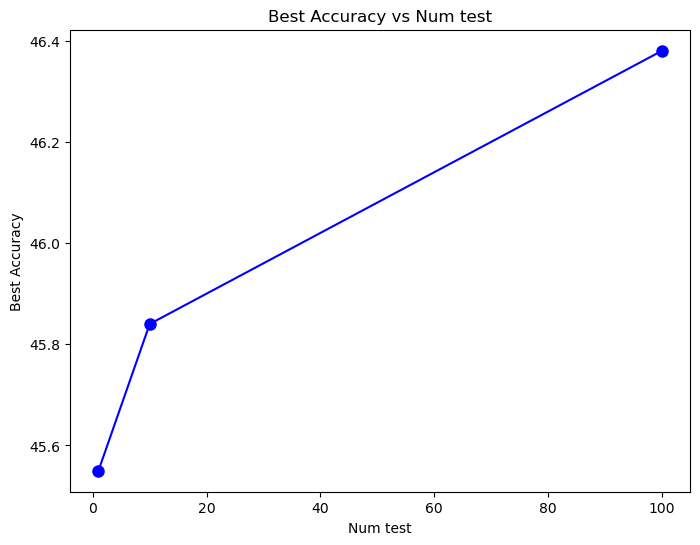

In [2]:
import matplotlib.pyplot as plt

num_test_values = [1,10,100]
best_acc_values = [45.55, 45.84, 46.38]

plt.figure(figsize=(8, 6))

plt.plot(num_test_values, best_acc_values, color='blue', linestyle='-', marker='o', markersize=8)

plt.title('Best Accuracy vs Num test')
plt.xlabel('Num test')
plt.ylabel('Best Accuracy')
plt.show()